## Preproccessing and Setup

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
sns.set(style="white")
import warnings
warnings.filterwarnings('ignore')
import pickle
# import dcor 
# from statsmodels.tsa.seasonal import seasonal_decompose

import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization

# from sklearn.preprocessing import MinMaxScaler, StandardScaler
# from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
tf.random.set_seed(13)
def mean_absolute_percentage_error(y_true, y_pred): 
  for i in range(len(y_true)):
    if y_true[i] == 0:
      print('MAPE * Founded')
      y_true[i] = np.mean(y_true)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
data = pd.read_csv('DowDataset.csv', sep=',', date_parser=True)
dataset1 = data.iloc[:343].copy()
dataset2 = data.iloc[396:754].copy()
dataset_test = data.iloc[761:].copy()
full_dataset = pd.concat([dataset1, dataset2, dataset_test], axis=0 , ignore_index=True)
full_dataset = full_dataset.drop(['DATE', 'Flow_to_EQ'], axis=1)

In [ ]:
class approach1:
  def __init__(self, df, goal):
    self.df = df.copy()
    self.goal = goal

    self.df['trend'] = self.df[self.goal].rolling(7).mean().fillna(method='bfill')
    self.df['residual'] = self.df[self.goal] - self.df['trend']
    self.df['target'] = self.df['residual'].shift(-1).fillna(method='ffill')

    if self.goal == 'D_COD_ON':
      self.X = self.df[['D_SS', 'BT_C_N', 'EQ_N', 'BT_C_DO', 'ST_COD', 'EQ_COD', 'D_COD_ON', 'residual']].fillna(method='ffill')
      self.model_optimizer = 'adam'
      self.model_layers = 2
      self.model_neurons = [26, 30]
    elif self.goal == 'EQ_COD':
      self.X = self.df[['BT_C_MVLSS', 'D_SS', 'EQ_N', 'BT_C_N', 'OxT_PH_PM', 'BT_N_DO', 'Clari_DO', 'ST_COD', 'EQ_COD', 'residual']].fillna(method='ffill')
      self.model_optimizer = 'adam'
      self.model_layers = 1
      self.model_neurons = 32
    elif self.goal == 'BT_C_MVLSS':
      self.X = self.df[['BT_C_MVLSS', 'D_SS', 'EQ_N', 'BT_C_N', 'OxT_PH_PM', 'BT_C_DO', 'Clari_DO', 'ST_COD', 'EQ_COD', 'residual']].fillna(method='ffill')
      self.model_optimizer = 'SGD'
      self.model_layers = 1
      self.model_neurons = 26

    self.Y = self.df['target'] 
    # print(self.X)

    self.x_mean = self.X.mean()
    self.x_std = self.X.std()
    self.y_mean = self.Y.mean()
    self.y_std = self.Y.std()
    # print(self.x_mean, self.y_mean)  
  
    self.X_train = (self.X - self.x_mean)/self.x_std
    self.Y_train = (self.Y - self.y_mean)/self.y_std

    # print(self.X_test, self.Y_train)
  
  def pearson_corr(self):
    pearson = self.df.corr(method='pearson')
    fig = plt.figure(figsize=(30,10))
    fig.suptitle('Pearson Correlation', fontsize=16)
    sns.heatmap(pearson,vmax=1, cmap="bwr", linewidths=0.1, annot=True)
    plt.show()

  def training(self, neurons = 6, max_epochs = 50):
    self.model = tf.keras.Sequential()
    self.model.add(Dense(neurons, activation='relu', input_dim= self.X_train.shape[1]))
    self.model.add(Dense(1))

    self.model.compile(optimizer= 'adam', loss='mse', metrics=['MAPE'])    
    history_Ann = self.model.fit(self.X_train, self.Y_train, epochs=max_epochs, verbose=0, validation_split=0.1)
    # Plot training & validation loss values
    plt.plot(history_Ann.history['loss'])
    plt.plot(history_Ann.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    self.model.save('approach1.h5')

  def tune(self, max_epochs = 50):
    self.tune_results = {}
    OPTIMIZER = ['SGD', 'adam']
    NUM_UNITS = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32]
    NUM_LAYER = [1, 2]
    n = 1
    min_score = 100    
    for optimizer in OPTIMIZER:
      for num_layer in NUM_LAYER:
        if num_layer == 1:
          for neurons in NUM_UNITS:
            self.model = tf.keras.Sequential()
            self.model.add(Dense(neurons, activation='relu', input_dim= self.X_train.shape[1]))
            self.model.add(Dense(1))
            self.model.compile(optimizer= optimizer, loss='mse', metrics=['MAPE'])    
            history_Ann = self.model.fit(self.X_train, self.Y_train, epochs=max_epochs, verbose=0, validation_split=0.1)
            # print('Optimizer: ', optimizer, ' - Layers: ', num_layer , ' - neurons: ', neurons, ' - Score: ', min(history_Ann.history['val_loss']))
            self.tune_results[f'{n}']  = {'Optimizer': optimizer, 'Layers':num_layer , 'Neurons': {neurons}, 'Score' : min(history_Ann.history['val_loss']), 'Epoch':history_Ann.history['val_loss'].index(min(history_Ann.history['val_loss']))}
            print(self.tune_results[f'{n}'])
            if min(history_Ann.history['val_loss']) < min_score:
              min_score = min(history_Ann.history['val_loss'])
              min_score_pos = n
            n+=1
        if num_layer == 2:
          for neurons in NUM_UNITS:
            for neurons2 in NUM_UNITS:
              self.model = tf.keras.Sequential()
              self.model.add(Dense(neurons, activation='relu', input_dim= self.X_train.shape[1]))
              self.model.add(Dense(neurons2, activation='relu'))
              self.model.add(Dense(1))
              self.model.compile(optimizer= optimizer, loss='mse', metrics=['MAPE'])    
              history_Ann = self.model.fit(self.X_train, self.Y_train, epochs=max_epochs, verbose=0, validation_split=0.1)   
              # print('Optimizer: ', optimizer, ' - Layers: ', num_layer , ' - neurons: ', neurons, ' - ', neurons2, ' - Score: ', min(history_Ann.history['val_loss'])) 
              self.tune_results[f'{n}']  = {'Optimizer': optimizer, 'Layers':num_layer , 'Neurons': {neurons, neurons2}, 'Score' : min(history_Ann.history['val_loss']), 'Epoch':history_Ann.history['val_loss'].index(min(history_Ann.history['val_loss']))}
              print(self.tune_results[f'{n}'])
              if min(history_Ann.history['val_loss']) < min_score:
                min_score = min(history_Ann.history['val_loss'])
                min_score_pos = n
              n+=1  
    self.best_tuned = self.tune_results[f'{min_score_pos}']
  
  def testing(self, df_test):
    self.df_test = df_test.copy()
    self.df_test['trend'] = self.df_test[self.goal].rolling(7).mean().fillna(method='ffill')
    self.df_test = self.df_test.iloc[-self.df_test.shape[0]+7:]
    self.df_test['residual'] = self.df_test[self.goal] - self.df_test['trend']
    self.df_test['target'] = self.df_test['residual'].shift(-1).fillna(method='ffill')

    if self.goal == 'D_COD_ON':
      self.Xt = self.df_test[['D_SS', 'BT_C_N', 'EQ_N', 'BT_C_DO', 'ST_COD', 'EQ_COD', 'D_COD_ON', 'residual']].fillna(method='ffill')
    elif self.goal == 'EQ_COD':
      self.Xt = self.df_test[['BT_C_MVLSS', 'D_SS', 'EQ_N', 'BT_C_N', 'OxT_PH_PM', 'BT_N_DO', 'Clari_DO', 'ST_COD', 'EQ_COD', 'residual']].fillna(method='ffill')
    elif self.goal == 'BT_C_MVLSS':
      self.Xt = self.df_test[['BT_C_MVLSS', 'D_SS', 'EQ_N', 'BT_C_N', 'OxT_PH_PM', 'BT_C_DO', 'Clari_DO', 'ST_COD', 'EQ_COD', 'residual']].fillna(method='ffill')

    self.X_test = (self.Xt - self.x_mean)/self.x_std
    self.Y_test = self.df_test[self.goal].shift(-1).fillna(method='ffill')
    
    self.prediction = pd.DataFrame(self.model.predict(self.X_test), columns=['Prediction'])

    self.prediction = self.prediction*self.y_std + self.y_mean
    self.full_prediction = self.df_test['trend'].reset_index(drop=True) + self.prediction['Prediction']

    print('*** ANN estimation ***')
    print ('MAPE: ',mean_absolute_percentage_error(self.Y_test.values, self.full_prediction))
    print ('R2: ',r2_score(self.Y_test.values, self.full_prediction.values))
    print ('RMSE: ',mean_squared_error(self.Y_test.values, self.full_prediction.values, squared=False))
    # plot baseline and predictions
    plt.figure(figsize=(28,10))
    plt.plot(self.Y_test.values, label = 'real ')
    plt.plot(self.full_prediction, label = 'predicted ')
    plt.ylabel(f'{self.goal} (mg/L)')
    plt.xlabel('Testing samples (2020)')
    plt.legend()
    plt.show()


In [ ]:
class approach2:
  def __init__(self, df, goal):
    self.df = df.copy()
    self.goal = goal

    self.df['target'] = self.df[self.goal].shift(-1).fillna(method='ffill')

    if self.goal == 'D_COD_ON':
      self.X = self.df[['D_SS', 'BT_C_N', 'EQ_N', 'BT_C_DO', 'ST_COD', 'EQ_COD', 'D_COD_ON']].fillna(method='ffill')
      self.model_optimizer = 'SGD'
      self.model_layers = 2
      self.model_neurons = [32, 4]
    elif self.goal == 'EQ_COD':
      self.X = self.df[['BT_C_MVLSS', 'D_SS', 'EQ_N', 'BT_C_N', 'OxT_PH_PM', 'BT_N_DO', 'Clari_DO', 'ST_COD', 'EQ_COD']].fillna(method='ffill')
      self.model_optimizer = 'adam'
      self.model_layers = 2
      self.model_neurons = [2, 18]
    elif self.goal == 'BT_C_MVLSS':
      self.X = self.df[['BT_C_MVLSS', 'D_SS', 'EQ_N', 'BT_C_N', 'OxT_PH_PM', 'BT_C_DO', 'Clari_DO', 'ST_COD', 'EQ_COD']].fillna(method='ffill')
      self.model_optimizer = 'adam'
      self.model_layers = 2
      self.model_neurons = [18, 26]

    self.Y = self.df['target'] 
    # print(self.X)

    self.x_mean = self.X.mean()
    self.x_std = self.X.std()
    self.y_mean = self.Y.mean()
    self.y_std = self.Y.std()
    # print(self.x_mean, self.y_mean)  
  
    self.X_train = (self.X - self.x_mean)/self.x_std
    self.Y_train = (self.Y - self.y_mean)/self.y_std
    # print(self.X_test, self.Y_train)
  
  def pearson_corr(self):
    pearson = self.df.corr(method='pearson')
    fig = plt.figure(figsize=(30,10))
    fig.suptitle('Pearson Correlation', fontsize=16)
    sns.heatmap(pearson,vmax=1, cmap="bwr", linewidths=0.1, annot=True)
    plt.show()

  def series_to_supervised(self, n_in=5, n_out=1, dropnan=True):
    self.n_in = n_in
    self.n_out = n_out

    n_vars = 1 if type(self.X_train) is list else self.X_train.shape[1]
    df = pd.DataFrame(self.X_train)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
      cols.append(df.shift(i))
      names += [('%s(t-%d)' % (df.columns[j],i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('%s(t)' % (df.columns[j])) for j in range(n_vars)]
      else:
        names += [('%s(t+%d)' % (df.columns[j], i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
      agg.dropna(inplace=True)
    self.supervised = agg
    self.supervised_train = self.supervised.values.reshape((self.supervised.shape[0], 1, self.supervised.shape[1]))
    self.Y_train = self.Y_train.iloc[n_in:]

  def training(self, neurons = [10, 14], max_epochs = 50):
    #print(neurons)
    self.model = tf.keras.Sequential()
    self.model.add(LSTM(self.model_neurons[0], activation='linear', return_sequences=True, input_shape=(self.supervised_train.shape[1:])))
    self.model.add(Dropout(0.1))
    if self.model_layers == 2:
      self.model.add(BatchNormalization())
      self.model.add(LSTM(self.model_neurons[1], activation='linear'))
    self.model.add(Dense(1))
    self.model.compile(loss='mse', optimizer=self.model_optimizer, metrics=['mape'])  
    history = self.model.fit(self.supervised_train, self.Y_train, epochs=max_epochs, verbose=0, validation_split=0.1)
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    self.model.save('approach2.h5')
  
  def tune(self, max_epochs = 50):
    self.tune_results = {}
    OPTIMIZER = ['SGD', 'adam']
    NUM_UNITS = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32]
    NUM_LAYER = [1, 2]
    n = 1
    min_score = 100    
    for optimizer in OPTIMIZER:
      for num_layer in NUM_LAYER:
        if num_layer == 1:
          for neurons in NUM_UNITS:
            self.models = tf.keras.Sequential()
            self.models.add(LSTM(neurons, activation='relu', return_sequences=True, input_shape=(self.supervised_train.shape[1:])))
            self.models.add(Dropout(0.1))
            self.models.add(Dense(1))
            self.models.compile(loss='mse', optimizer=optimizer, metrics=['mape'])  
            history = self.models.fit(self.supervised_train, self.Y_train, epochs=max_epochs, verbose=0, validation_split=0.1)
            # print('Optimizer: ', optimizer, ' - Layers: ', num_layer , ' - neurons: ', neurons, ' - Score: ', min(history.history['val_loss']))
            self.tune_results[f'{n}']  = {'Optimizer': optimizer, 'Layers':num_layer , 'Neurons': {neurons}, 'Score' : min(history.history['val_loss']), 'Epoch':history.history['val_loss'].index(min(history.history['val_loss']))}
            print(self.tune_results[f'{n}'])
            if min(history.history['val_loss']) < min_score:
              min_score = min(history.history['val_loss'])
              min_score_pos = n
            n+=1
        if num_layer == 2:
          for neurons in NUM_UNITS:
            for neurons2 in NUM_UNITS:
              self.models = tf.keras.Sequential()
              self.models.add(LSTM(neurons, activation='relu', return_sequences=True, input_shape=(self.supervised_train.shape[1:])))
              self.models.add(Dropout(0.1))
              self.models.add(BatchNormalization())
              self.models.add(LSTM(neurons2, activation='relu', return_sequences=True))
              self.models.add(Dense(1))
              self.models.compile(loss='mse', optimizer=optimizer, metrics=['mape'])  
              history = self.models.fit(self.supervised_train, self.Y_train, epochs=max_epochs, verbose=0, validation_split=0.1) 
              # print('Optimizer: ', optimizer, ' - Layers: ', num_layer , ' - neurons: ', neurons, ' - ', neurons2, ' - Score: ', min(history.history['val_loss'])) 
              self.tune_results[f'{n}']  = {'Optimizer': optimizer, 'Layers':num_layer , 'Neurons': {neurons, neurons2}, 'Score' : min(history.history['val_loss']), 'Epoch':history.history['val_loss'].index(min(history.history['val_loss']))}
              print(self.tune_results[f'{n}'])
              if min(history.history['val_loss']) < min_score:
                min_score = min(history.history['val_loss'])
                min_score_pos = n
              n+=1  
    self.best_tuned = self.tune_results[f'{min_score_pos}'] 

  def testing(self, df_test):
    self.df_test = df_test.copy()
    
    def series_to_supervised_test(X_test, n_in=self.n_in, n_out=self.n_out, dropnan=True):
      n_vars = 1 if type(X_test) is list else X_test.shape[1]
      df = pd.DataFrame(X_test)
      cols, names = list(), list()
      # input sequence (t-n, ... t-1)
      for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (df.columns[j],i)) for j in range(n_vars)]
      # forecast sequence (t, t+1, ... t+n)
      for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
          names += [('%s(t)' % (df.columns[j])) for j in range(n_vars)]
        else:
          names += [('%s(t+%d)' % (df.columns[j], i)) for j in range(n_vars)]
      # put it all together
      agg = pd.concat(cols, axis=1)
      agg.columns = names
      # drop rows with NaN values
      if dropnan:
        agg.dropna(inplace=True)
      supervised = agg
      supervised_test = supervised.values.reshape((supervised.shape[0], 1, supervised.shape[1]))
      return supervised_test
    # self.df_test['target'] = self.df_test[self.goal].shift(-1).fillna(method='ffill')

    if self.goal == 'D_COD_ON':
      self.Xt = self.df_test[['D_SS', 'BT_C_N', 'EQ_N', 'BT_C_DO', 'ST_COD', 'EQ_COD', 'D_COD_ON']].fillna(method='ffill')
    elif self.goal == 'EQ_COD':
      self.Xt = self.df_test[['BT_C_MVLSS', 'D_SS', 'EQ_N', 'BT_C_N', 'OxT_PH_PM', 'BT_N_DO', 'Clari_DO', 'ST_COD', 'EQ_COD']].fillna(method='ffill')
    elif self.goal == 'BT_C_MVLSS':
      self.Xt = self.df_test[['BT_C_MVLSS', 'D_SS', 'EQ_N', 'BT_C_N', 'OxT_PH_PM', 'BT_C_DO', 'Clari_DO', 'ST_COD', 'EQ_COD']].fillna(method='ffill')

    # self.Xt = self.df_test[['BT_C_MLSS','EQ_N', 'BT_C_N', 'D_COD_ON']].fillna(method='ffill')
    self.X_test = (self.Xt - self.x_mean)/self.x_std
    self.Y_test = self.df_test[self.goal].shift(-1).fillna(method='ffill').iloc[self.n_in:]
    self.supervised_test = series_to_supervised_test(self.X_test)
    
    self.prediction = pd.DataFrame(self.model.predict(self.supervised_test).reshape(-1,1), columns=['Prediction'])
    self.full_prediction = self.prediction*self.y_std + self.y_mean
    
    print('*** LSTM estimation ***')
    # print ('MAPE: ',mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    # print ('R2: ',r2_score(self.Y_test.values, self.full_prediction.values))
    # print ('RMSE: ',mean_squared_error(self.Y_test.values, self.full_prediction.values, squared=False))
    print ('MAPE: ',mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    print ('R2: ',r2_score(self.Y_test.values, self.full_prediction.values))
    print ('RMSE: ',mean_squared_error(self.Y_test.values, self.full_prediction.values, squared=False))
    # plot baseline and predictions
    plt.figure(figsize=(28,10))
    plt.plot(self.Y_test.values, label = 'real ')
    plt.plot(self.full_prediction.values, label = 'predicted ')
    plt.ylabel(f'{self.goal} (mg/L)')
    plt.xlabel('Testing samples (2020)')
    plt.legend()
    plt.show()

In [ ]:
class approach3:
  def __init__(self, df, goal):    
    self.df = df.copy()
    self.goal = goal

    self.df['target'] = self.df[self.goal].shift(-1).fillna(method='ffill')

    if self.goal == 'D_COD_ON':
      self.X = self.df[['D_SS', 'BT_C_N', 'EQ_N', 'BT_C_DO', 'ST_COD', 'EQ_COD', 'D_COD_ON']].fillna(method='bfill')
    elif self.goal == 'EQ_COD':
      self.X = self.df[['BT_C_MVLSS', 'D_SS', 'EQ_N', 'BT_C_N', 'OxT_PH_PM', 'BT_N_DO', 'Clari_DO', 'ST_COD', 'EQ_COD']].fillna(method='bfill')
    elif self.goal == 'BT_C_MVLSS':
      self.X = self.df[['BT_C_MVLSS', 'D_SS', 'EQ_N', 'BT_C_N', 'OxT_PH_PM', 'BT_C_DO', 'Clari_DO', 'ST_COD', 'EQ_COD']].fillna(method='bfill')
    
    # self.X = self.df[['BT_C_MLSS','EQ_N', 'BT_C_N', 'D_COD_ON']].fillna(method='bfill')
    self.Y = self.df['target'].fillna(method='bfill')
    # print(self.X)

    self.x_mean = self.X.mean()
    self.x_std = self.X.std()
    self.y_mean = self.Y.mean()
    self.y_std = self.Y.std()
    # print(self.x_mean, self.y_mean)  
  
    self.X_train = self.X
    self.Y_train = self.Y
    self.X_train = (self.X - self.x_mean)/self.x_std
    self.Y_train = (self.Y - self.y_mean)/self.y_std
    # print(self.X_test, self.Y_train)
  
  def pearson_corr(self):
    pearson = self.df.corr(method='pearson')
    fig = plt.figure(figsize=(30,10))
    fig.suptitle('Pearson Correlation', fontsize=16)
    sns.heatmap(pearson,vmax=1, cmap="bwr", linewidths=0.1, annot=True)
    plt.show()

  def training(self):
    from sklearn.svm import SVR
    self.model = SVR(kernel='rbf', C=10, gamma=0.001, epsilon=0.2)
    self.model = self.model.fit(self.X_train.values, self.Y_train.values)
    # self.model.save('approach3.h5')
  
  def testing(self, df_test):
    self.df_test = df_test.copy()
    
    if self.goal == 'D_COD_ON':
      self.X_test = self.df_test[['D_SS', 'BT_C_N', 'EQ_N', 'BT_C_DO', 'ST_COD', 'EQ_COD', 'D_COD_ON']].fillna(method='bfill').fillna(method='ffill')
    elif self.goal == 'EQ_COD':
      self.X_test = self.df_test[['BT_C_MVLSS', 'D_SS', 'EQ_N', 'BT_C_N', 'OxT_PH_PM', 'BT_N_DO', 'Clari_DO', 'ST_COD', 'EQ_COD']].fillna(method='bfill').fillna(method='ffill')
    elif self.goal == 'BT_C_MVLSS':
      self.X_test = self.df_test[['BT_C_MVLSS', 'D_SS', 'EQ_N', 'BT_C_N', 'OxT_PH_PM', 'BT_C_DO', 'Clari_DO', 'ST_COD', 'EQ_COD']].fillna(method='bfill').fillna(method='ffill')

    # self.X_test = self.df_test[['BT_C_MLSS','EQ_N', 'BT_C_N', 'D_COD_ON']].fillna(method='ffill').fillna(method='bfill')
    self.X_test = (self.X_test - self.x_mean)/self.x_std
    self.Y_test = self.df_test[self.goal].shift(-1).fillna(method='ffill')
        
    self.prediction = self.model.predict(self.X_test)
    # self.prediction = pd.DataFrame(self.model.predict(self.X_test), columns=['Prediction'])
    self.amplifier = 10
    full_prediction = self.prediction*self.y_std + self.y_mean

    self.full_prediction = full_prediction
    # self.full_prediction = np.zeros(len(self.prediction))
    # self.full_prediction[0] = self.df_test[self.goal].reset_index(drop=True)[0] + full_prediction[0] 
    # for i in range(1,len(self.prediction)):
    #   self.full_prediction[i] = self.full_prediction[i-1] - full_prediction[i]
    # self.full_prediction = 3*self.prediction
    
    print('*** Delta estimation ***')
    print ('MAPE: ',mean_absolute_percentage_error(self.Y_test.values, self.full_prediction))
    print ('R2: ',r2_score(self.Y_test.values, self.full_prediction))
    print ('RMSE: ',mean_squared_error(self.Y_test.values, self.full_prediction, squared=False))
    # plot baseline and predictions
    plt.figure(figsize=(28,10))
    plt.plot(self.Y_test.values, label = 'real ')
    plt.plot(self.full_prediction, label = 'predicted ')
    plt.ylabel(f'{self.goal} (mg/L)')
    plt.xlabel('Testing samples (2020)')
    plt.legend()
    plt.show()

# BT_C_MVLSS

In [ ]:
active_target = "BT_C_MVLSS"
dataset = dataset2.copy()
dataset.shape
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358 entries, 396 to 753
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        358 non-null    object 
 1   Flow_to_EQ  358 non-null    object 
 2   Flow_efl    358 non-null    float64
 3   BT_C_MLSS   358 non-null    float64
 4   BT_C_MVLSS  358 non-null    float64
 5   BT_N_MLSS   358 non-null    float64
 6   BT_N_MVLSS  358 non-null    float64
 7   D_SS        358 non-null    float64
 8   EQ_N        358 non-null    float64
 9   BT_C_N      358 non-null    float64
 10  BT_N_N      358 non-null    float64
 11  D_N         358 non-null    float64
 12  OxT_PH_PM   358 non-null    float64
 13  EQ_PH       358 non-null    float64
 14  BT_N_PH     358 non-null    float64
 15  D_PH        358 non-null    float64
 16  BT_N_DO     358 non-null    float64
 17  BT_C_DO     358 non-null    float64
 18  Clari_DO    358 non-null    float64
 19  F/M         358 non-null   

## Approach 1

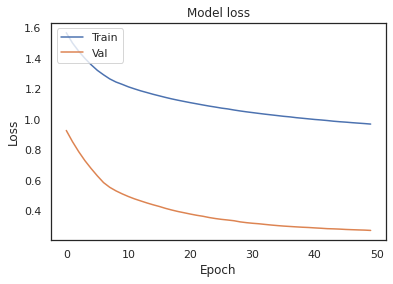

*** ANN estimation ***
MAPE:  15.159056867577581
R2:  0.8427434512252907
RMSE:  712.2932195604318


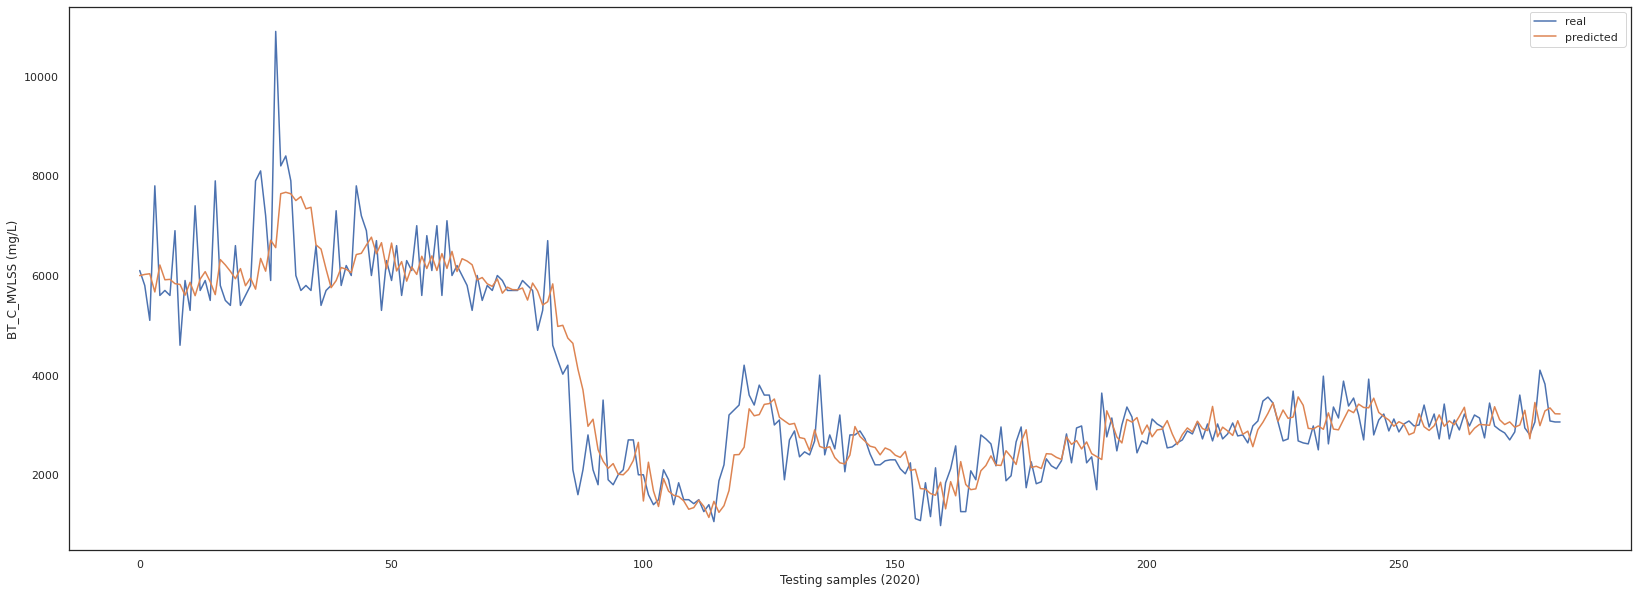

(283,)

In [ ]:
cut_off = 68
app1 = approach1(dataset.iloc[:-cut_off], active_target)
# app1.tune()
# print(app1.best_tuned)
# with open('EQ_COD1.pickle', 'wb') as handle:
#   pickle.dump(app1.best_tuned, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('EQ_COD_tuning_1.pickle', 'wb') as handle:
#   pickle.dump(app1.tune_results, handle, protocol=pickle.HIGHEST_PROTOCOL)
app1.training()
app1.testing(dataset.iloc[:-cut_off])
# app1.testing(dataset.iloc[-142:])
app1.full_prediction.shape


 ## Approach 2

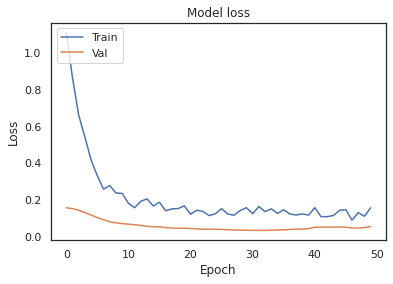

*** LSTM estimation ***
MAPE:  58.26077765192934
R2:  0.9276813093195881
RMSE:  483.036242652924


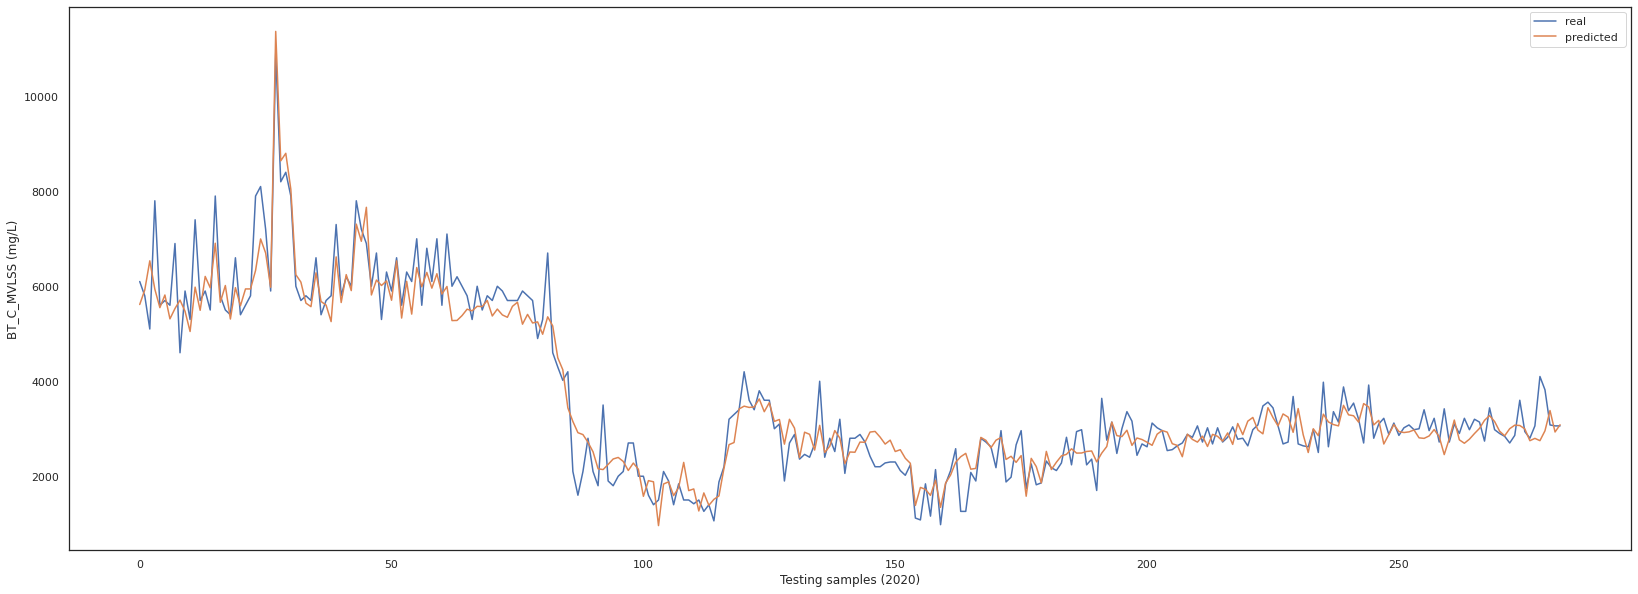

(283, 1)

In [ ]:
app2 = approach2(dataset.iloc[:-cut_off], active_target)
app2.series_to_supervised(n_in=2)
app2.supervised
app2.training()
# app2.testing(dataset.iloc[-137:])
app2.testing(dataset.iloc[5:-cut_off])
app2.full_prediction.shape

## Approach 3

*** Delta estimation ***
MAPE:  16.676051443645367
R2:  0.824839227210377
RMSE:  751.7490127554727


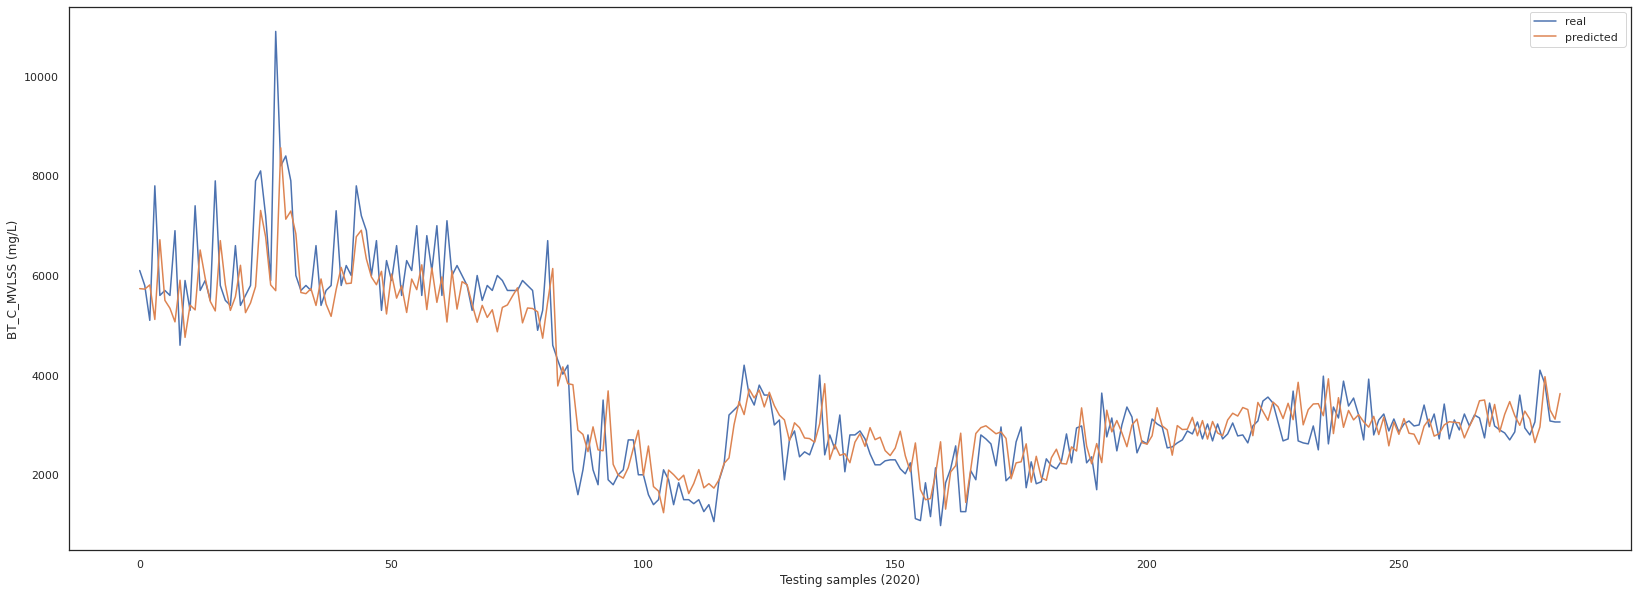

(283,)

In [ ]:
app3 = approach3(dataset.iloc[:-cut_off], active_target)
app3.training()
app3.testing(dataset.iloc[7:-cut_off])
# app3.testing(dataset.iloc[-135:])
app3.full_prediction.shape

## Approaches

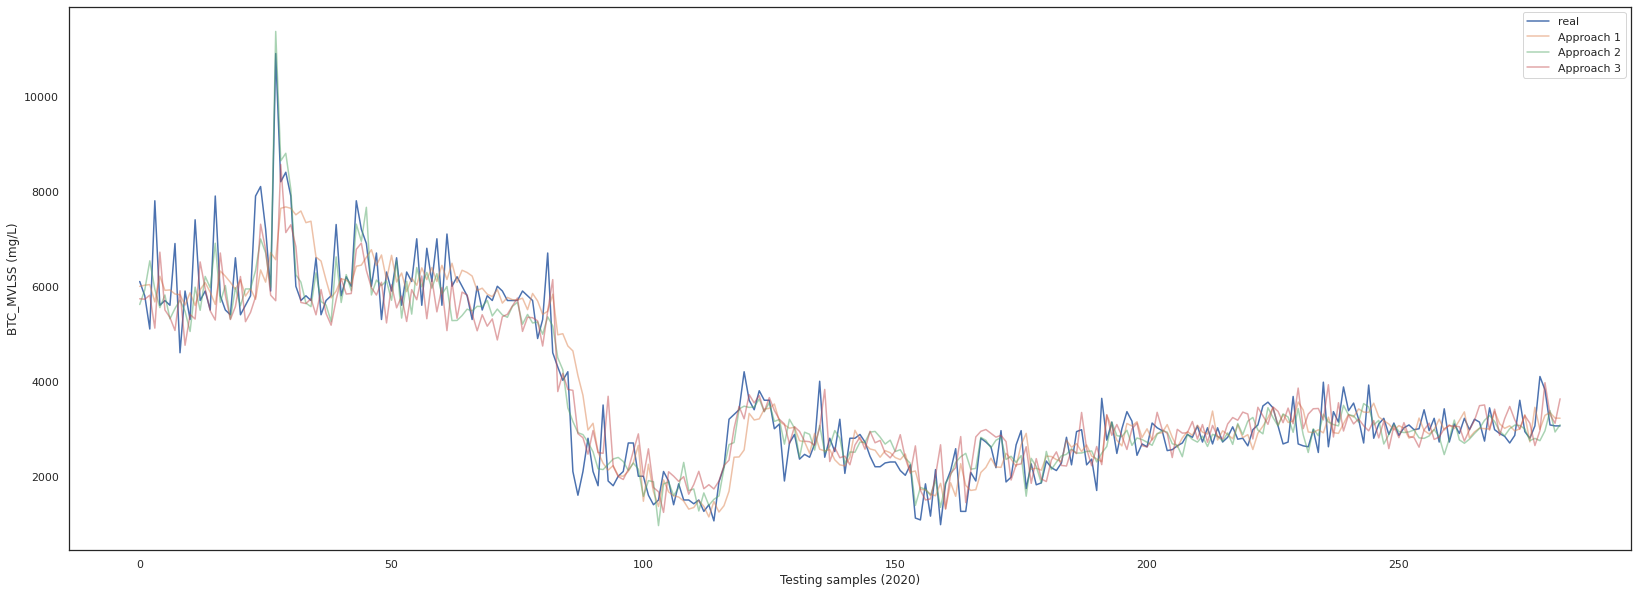

In [ ]:
plt.figure(figsize=(28,10))
plt.plot(app1.Y_test.values, label = 'real ')
plt.plot(app1.full_prediction,'-', alpha= 0.5, label = 'Approach 1')
plt.plot(app2.full_prediction['Prediction'], alpha= 0.5, label = 'Approach 2')
plt.plot(app3.full_prediction, alpha= 0.5, label = 'Approach 3')
plt.ylabel('BTC_MVLSS (mg/L)')
plt.xlabel('Testing samples (2020)')
plt.legend()
plt.show()

## Ensemble

In [ ]:
app1.full_prediction + app2.full_prediction['Prediction'] + app3.full_prediction

0      17350.640877
1      17669.443697
2      18382.665946
3      16727.103901
4      18479.610285
           ...     
278     8694.899317
279    10208.702377
280    10027.974102
281     9271.735923
282     9935.821708
Length: 283, dtype: float64

### Ensemble AVG

*** Ensemble estimation ***
MAPE:  14.84900729172348
R2:  0.8532463408903578
RMSE:  688.0958038653564


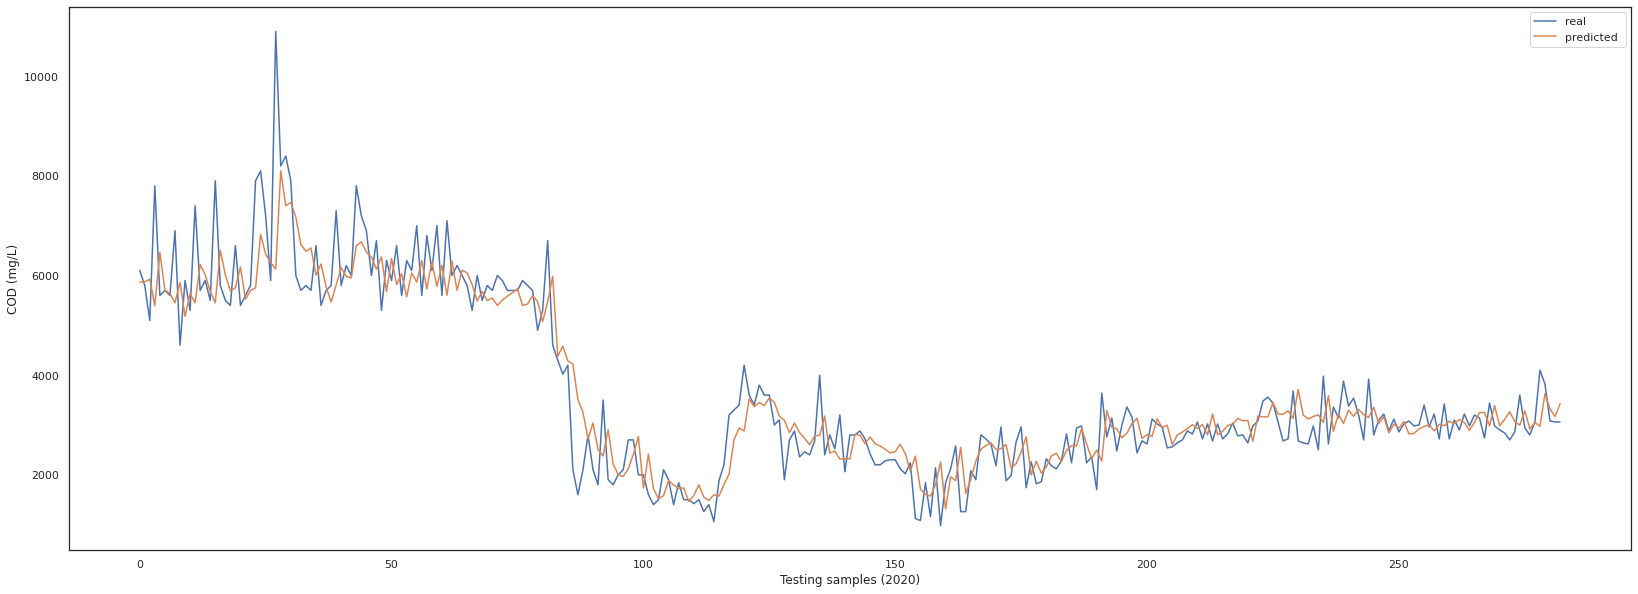

In [ ]:
ensemble = (app1.full_prediction + app3.full_prediction)/2
print('*** Ensemble estimation ***')
print ('MAPE: ',mean_absolute_percentage_error(app2.Y_test.values, ensemble))
print ('R2: ',r2_score(app2.Y_test.values, ensemble))
print ('RMSE: ',mean_squared_error(app2.Y_test.values, ensemble, squared=False))
# plot baseline and predictions
plt.figure(figsize=(28,10))
plt.plot(app2.Y_test.values, label = 'real ')
plt.plot(ensemble.values, label = 'predicted ')
plt.ylabel('COD (mg/L)')
plt.xlabel('Testing samples (2020)')
plt.legend()
plt.show()

*** Ensemble estimation ***
MAPE:  13.235094873800529
R2:  0.8954586922868522
RMSE:  580.7622837184342


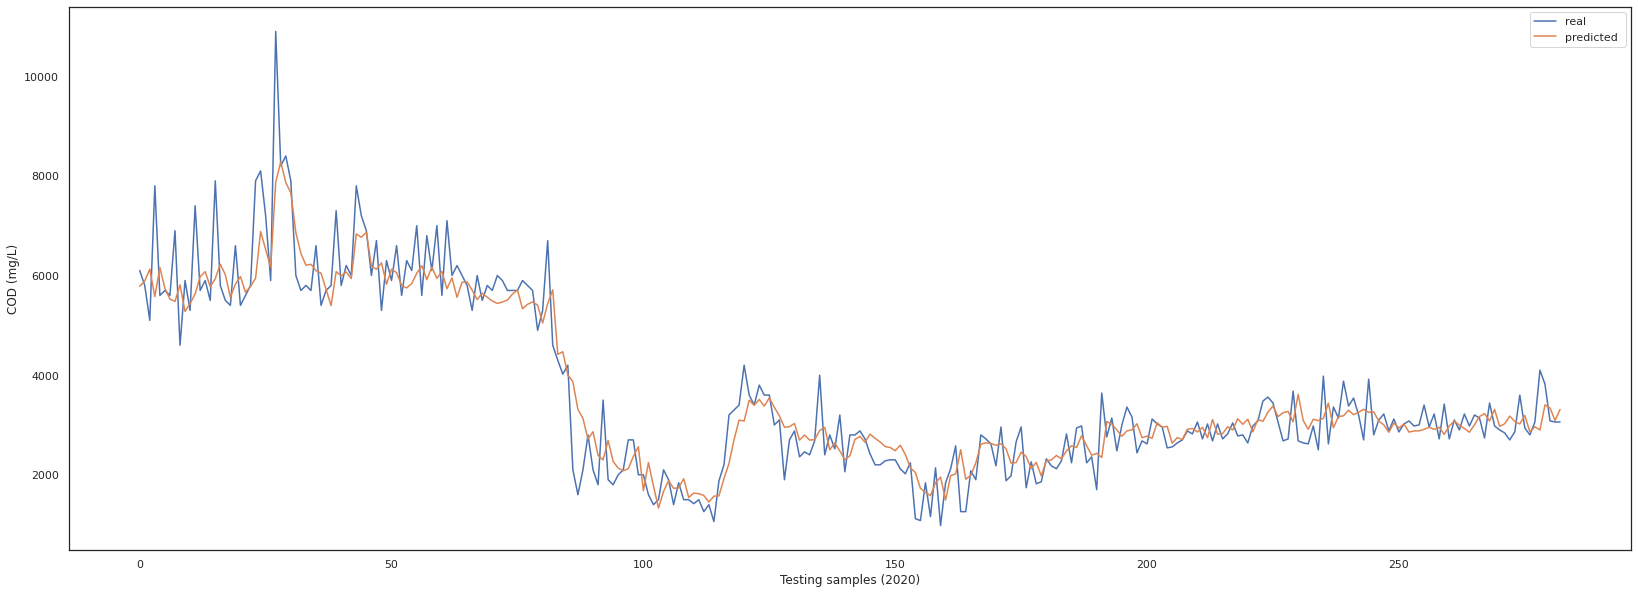

In [ ]:
ensemble = (app1.full_prediction + app2.full_prediction['Prediction'] + app3.full_prediction)/3
print('*** Ensemble estimation ***')
print ('MAPE: ',mean_absolute_percentage_error(app2.Y_test.values, ensemble))
print ('R2: ',r2_score(app2.Y_test.values, ensemble))
print ('RMSE: ',mean_squared_error(app2.Y_test.values, ensemble, squared=False))
# plot baseline and predictions
plt.figure(figsize=(28,10))
plt.plot(app2.Y_test.values, label = 'real ')
plt.plot(ensemble.values, label = 'predicted ')
plt.ylabel('COD (mg/L)')
plt.xlabel('Testing samples (2020)')
plt.legend()
plt.show()

### Ensemble 1 - Model Fusion

In [ ]:
class Ensemble:
  def __init__(self, df, goal, model1, model2, model3):
    self.df = df.iloc[-len(model1):]
    self.goal = goal
    self.df = self.df.reset_index(drop=True)
    
    self.df['model1'] = model1
    self.df['model2'] = model2
    self.df['model3'] = model3

    self.df['target'] = self.df[self.goal].shift(-1).fillna(method='ffill')

    self.X = self.df[['model1', 'model2', 'model3']]
    self.Y = self.df['target'] 
    # print(self.X)

    self.x_mean = self.X.mean()
    self.x_std = self.X.std()
    self.y_mean = self.Y.mean()
    self.y_std = self.Y.std()
    # print(self.x_mean, self.y_mean)  
  
    self.X_train = (self.X - self.x_mean)/self.x_std
    self.Y_train = (self.Y - self.y_mean)/self.y_std
    # print(self.X_test, self.Y_train)
  
  def pearson_corr(self):
    pearson = self.df.corr(method='pearson')
    fig = plt.figure(figsize=(30,10))
    fig.suptitle('Pearson Correlation', fontsize=16)
    sns.heatmap(pearson,vmax=1, cmap="bwr", linewidths=0.1, annot=True)
    plt.show()

  def training(self, neurons = 8, max_epochs = 50):
    self.model = tf.keras.Sequential()
    self.model.add(Dense(neurons, activation='relu', input_dim= self.X_train.shape[1]))
    self.model.add(Dense(1))

    self.model.compile(optimizer= 'adam', loss='mse', metrics=['MAPE'])    
    history_Ann = self.model.fit(self.X_train, self.Y_train, epochs=max_epochs, verbose=1, validation_split=0.1)
    # Plot training & validation loss values
    plt.plot(history_Ann.history['loss'])
    plt.plot(history_Ann.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    self.model.save('Ensemble.h5')
  
  def testing(self, df_test, model1, model2, model3):
    self.df_test = df_test.iloc[-len(model1):]
    self.df_test = self.df_test.reset_index(drop=True)
    
    self.df_test['model1'] = model1
    self.df_test['model2'] = model2
    self.df_test['model3'] = model3

    self.df_test['target'] = self.df_test[self.goal].shift(-1).fillna(method='ffill')

    self.Xt = self.df_test[['model1', 'model2', 'model3']]
    self.Y_test = self.df_test['target'] 
    # print(self.Xt)
  
    self.X_test = (self.Xt - self.x_mean)/self.x_std
    # print(self.X_test, self.Y_train)
    
    self.prediction = pd.DataFrame(self.model.predict(self.X_test), columns=['Prediction'])

    self.full_prediction = self.prediction*self.y_std + self.y_mean
    

    print('*** ANN Ensemble estimation ***')
    print ('MAPEtf: ',tf.keras.losses.mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    print ('MAPEsci: ',mean_absolute_error(self.Y_test.values, self.full_prediction.values)*100)
    print ('MAPE: ',mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    print ('R2: ',r2_score(self.Y_test.values, self.full_prediction))
    print ('RMSE: ',mean_squared_error(self.Y_test.values, self.full_prediction, squared=False))

    # plot baseline and predictions
    plt.figure(figsize=(28,10))
    plt.plot(self.Y_test.values, label = 'real ')
    plt.plot(self.full_prediction.values, label = 'predicted ')
    plt.ylabel('COD (mg/L)')
    plt.xlabel('Testing samples (2020)')
    plt.legend()
    plt.show()

Epoch 1/50
8/8 [==============================] - 1s 23ms/step - loss: 0.9373 - MAPE: 85.3637 - val_loss: 0.0544 - val_MAPE: 73.8313
Epoch 2/50
8/8 [==============================] - 0s 6ms/step - loss: 0.8326 - MAPE: 81.3282 - val_loss: 0.0468 - val_MAPE: 72.5819
Epoch 3/50
8/8 [==============================] - 0s 4ms/step - loss: 0.7327 - MAPE: 76.9164 - val_loss: 0.0433 - val_MAPE: 74.6630
Epoch 4/50
8/8 [==============================] - 0s 4ms/step - loss: 0.6471 - MAPE: 75.4999 - val_loss: 0.0428 - val_MAPE: 78.0222
Epoch 5/50
8/8 [==============================] - 0s 4ms/step - loss: 0.5712 - MAPE: 74.5273 - val_loss: 0.0441 - val_MAPE: 81.6576
Epoch 6/50
8/8 [==============================] - 0s 4ms/step - loss: 0.5039 - MAPE: 73.6865 - val_loss: 0.0463 - val_MAPE: 85.0844
Epoch 7/50
8/8 [==============================] - 0s 4ms/step - loss: 0.4478 - MAPE: 73.3918 - val_loss: 0.0487 - val_MAPE: 87.9888
Epoch 8/50
8/8 [==============================] - 0s 4ms/step - loss: 0.399

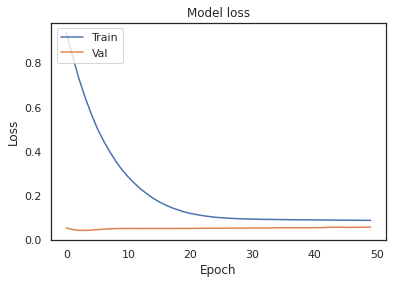

In [ ]:
ensemble_model = Ensemble(dataset.iloc[:-cut_off], active_target, app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)
ensemble_model.training()

*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(
[103.88794  109.75935  120.378006 108.24213   96.12938  107.54808
  99.8716   103.489914 101.991104 101.045906  94.0644   107.30078
  93.64893  114.54591  109.75782  122.98968   99.74053  113.389656
 101.840034 110.16888  100.67227  109.29581  110.389694 113.11716
 122.863815 118.31659  118.88726  208.24069  165.24486  177.32233
 162.11803  126.481995 132.42867  121.53782  120.19503  124.81939
 110.22519  106.77124   97.716286 120.526436 102.7221   116.27346
 109.49236  135.00922  127.19148  145.82784  115.98941  118.20721
 117.77774  116.56259  111.39437  122.15488  100.964    113.21744
 100.0643   118.11252  112.243225 119.40787  112.33959  117.84451
 112.026764 115.229866  99.58901  101.19891  101.96203  104.75794
 105.758224 105.17733  104.335556 105.95025   99.385994 105.18767
  98.05418   98.41057  100.89253  101.16548   97.25209   96.757195
  97.70758   96.5825    91.63419   94.873924  89.731125  83.456924
  79.03051   63.23827

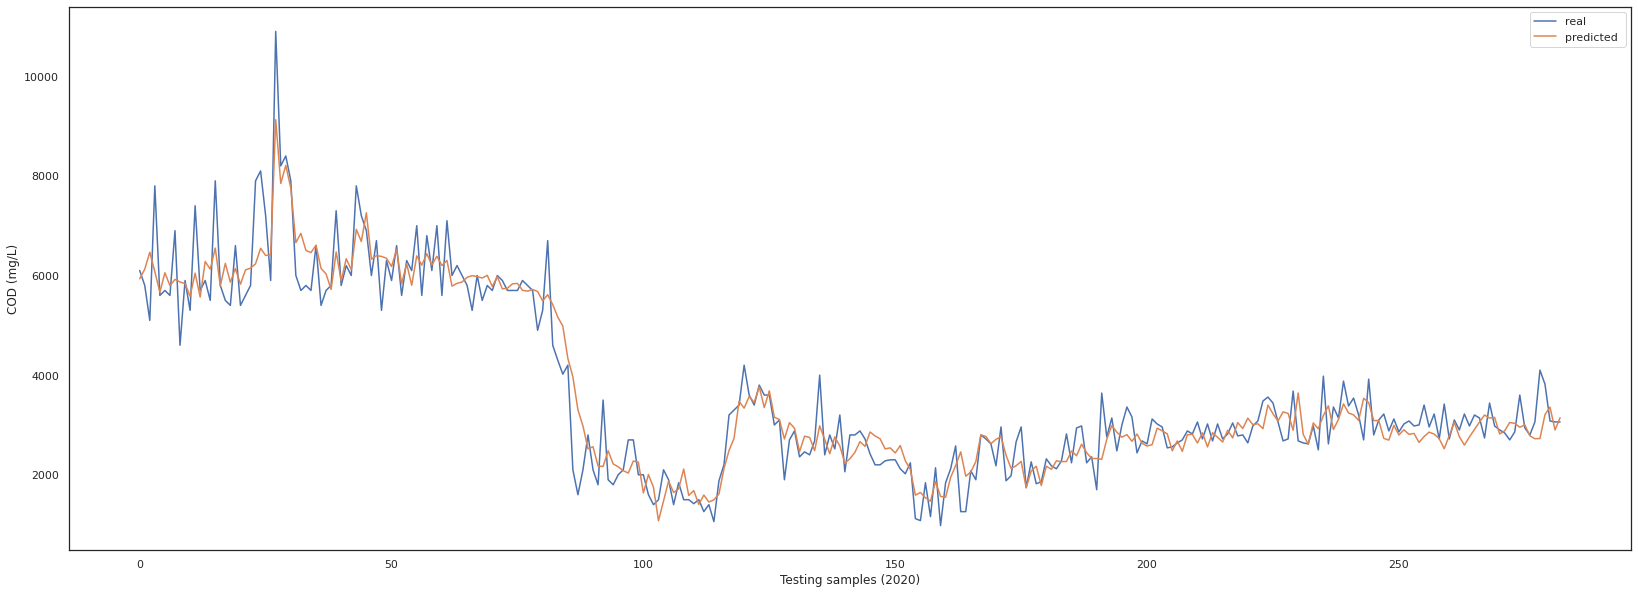

In [ ]:
ensemble_model.testing(dataset.iloc[:-cut_off], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

### Ensemble 2 - Model Fusion + Exo


In [ ]:
class Ensemble2:
  def __init__(self, df, goal, model1, model2, model3):
    self.df = df.iloc[-len(model1):]
    self.goal = goal
    self.df = self.df.reset_index(drop=True)
    
    self.df['model1'] = model1
    self.df['model2'] = model2
    self.df['model3'] = model3

    self.df['target'] = self.df[self.goal].shift(-1).fillna(method='ffill')

    self.X = self.df[[self.goal, 'model1', 'model2', 'model3']]
    self.Y = self.df['target'] 
    # print(self.X)

    self.x_mean = self.X.mean()
    self.x_std = self.X.std()
    self.y_mean = self.Y.mean()
    self.y_std = self.Y.std()
    # print(self.x_mean, self.y_mean)  
  
    self.X_train = (self.X - self.x_mean)/self.x_std
    self.Y_train = (self.Y - self.y_mean)/self.y_std
    # print(self.X_test, self.Y_train)
  
  def pearson_corr(self):
    pearson = self.df.corr(method='pearson')
    fig = plt.figure(figsize=(30,10))
    fig.suptitle('Pearson Correlation', fontsize=16)
    sns.heatmap(pearson,vmax=1, cmap="bwr", linewidths=0.1, annot=True)
    plt.show()

  def training(self, neurons = 8, max_epochs = 50):
    self.model = tf.keras.Sequential()
    self.model.add(Dense(neurons, activation='relu', input_dim= self.X_train.shape[1]))
    self.model.add(Dense(1))

    self.model.compile(optimizer= 'adam', loss='mse', metrics=['MAPE'])    
    history_Ann = self.model.fit(self.X_train, self.Y_train, epochs=max_epochs, verbose=1, validation_split=0.1)
    # Plot training & validation loss values
    plt.plot(history_Ann.history['loss'])
    plt.plot(history_Ann.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    self.model.save('Ensemble.h5')
  
  def testing(self, df_test, model1, model2, model3):
    self.df_test = df_test.iloc[-len(model1):]
    self.df_test = self.df_test.reset_index(drop=True)
    self.df_test[self.goal] = self.df_test[self.goal].fillna(method='ffill')
    
    self.df_test['model1'] = model1
    self.df_test['model2'] = model2
    self.df_test['model3'] = model3

    self.df_test['target'] = self.df_test[self.goal].shift(-1).fillna(method='ffill')

    self.Xt = self.df_test[[self.goal, 'model1', 'model2', 'model3']]
    self.Y_test = self.df_test['target'] 
    # print(self.Xt)
  
    self.X_test = (self.Xt - self.x_mean)/self.x_std
    # print(self.X_test, self.Y_train)
    
    self.prediction = pd.DataFrame(self.model.predict(self.X_test), columns=['Prediction'])

    self.full_prediction = self.prediction*self.y_std + self.y_mean
    

    print('*** ANN Ensemble estimation ***')
    print ('MAPEtf: ',tf.keras.losses.mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    # print ('MAPEsci: ',mean_absolute_error(self.Y_test.values, self.full_prediction.values)*100)
    print ('MAPE: ',mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    print ('R2: ',r2_score(self.Y_test.values, self.full_prediction))
    print ('RMSE: ',mean_squared_error(self.Y_test.values, self.full_prediction, squared=False))

    # plot baseline and predictions
    plt.figure(figsize=(28,10))
    plt.plot(self.Y_test.values, label = 'real ')
    plt.plot(self.full_prediction.values, label = 'predicted ')
    plt.ylabel('COD (mg/L)')
    plt.xlabel('Testing samples (2020)')
    plt.legend()
    plt.show()

Epoch 1/50
8/8 [==============================] - 1s 20ms/step - loss: 2.2586 - MAPE: 119.9127 - val_loss: 0.0932 - val_MAPE: 77.7639
Epoch 2/50
8/8 [==============================] - 0s 4ms/step - loss: 2.0196 - MAPE: 115.1306 - val_loss: 0.0817 - val_MAPE: 72.8540
Epoch 3/50
8/8 [==============================] - 0s 4ms/step - loss: 1.7961 - MAPE: 108.5050 - val_loss: 0.0718 - val_MAPE: 69.8467
Epoch 4/50
8/8 [==============================] - 0s 4ms/step - loss: 1.5973 - MAPE: 103.8625 - val_loss: 0.0633 - val_MAPE: 67.4725
Epoch 5/50
8/8 [==============================] - 0s 4ms/step - loss: 1.4178 - MAPE: 99.5967 - val_loss: 0.0562 - val_MAPE: 67.3467
Epoch 6/50
8/8 [==============================] - 0s 4ms/step - loss: 1.2548 - MAPE: 95.0453 - val_loss: 0.0505 - val_MAPE: 67.6967
Epoch 7/50
8/8 [==============================] - 0s 3ms/step - loss: 1.1138 - MAPE: 91.2238 - val_loss: 0.0463 - val_MAPE: 68.1205
Epoch 8/50
8/8 [==============================] - 0s 3ms/step - loss: 0

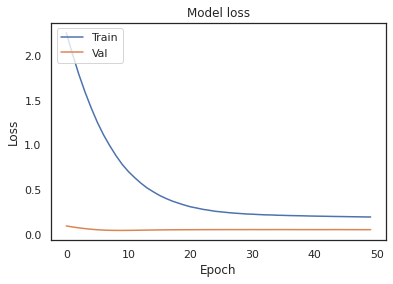

In [ ]:
ensemble_model2 = Ensemble2(dataset.iloc[:-cut_off], active_target, app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)
ensemble_model2.training()

*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(
[108.04505  109.92756  108.750244  87.59051  154.55614  100.62058
  96.69796   89.14527  124.44339   76.0008   100.759544  95.78148
 148.14098  113.53525  102.33946   90.45932  153.06268  108.26066
  92.501015 101.25071  128.5733    93.325874  98.5237   112.734375
 172.1643   159.47585  111.602615  63.431908 222.54262  149.55382
 157.96289  141.31966   87.73823   88.46554   91.808266  90.11616
 113.98091   94.842995  93.86802  106.642654 131.79103  109.93415
 114.2554   123.2841   156.97833  129.30525  114.25052  106.74606
 117.96926   87.5002   113.60378  101.307655 112.79952   93.49313
 116.67442  109.1838   128.15176   92.27765  124.492584 100.016785
 119.21976   85.56975  124.032166  96.28649  112.08807  109.08892
  96.23749   86.445175  99.70378   90.97779   97.95913   83.32409
 102.310455 101.82253  106.62508  111.25083   90.3111   102.95329
  98.06269   97.25422   81.139336 101.27466  131.45685   56.460625
  65.86359   52.40017

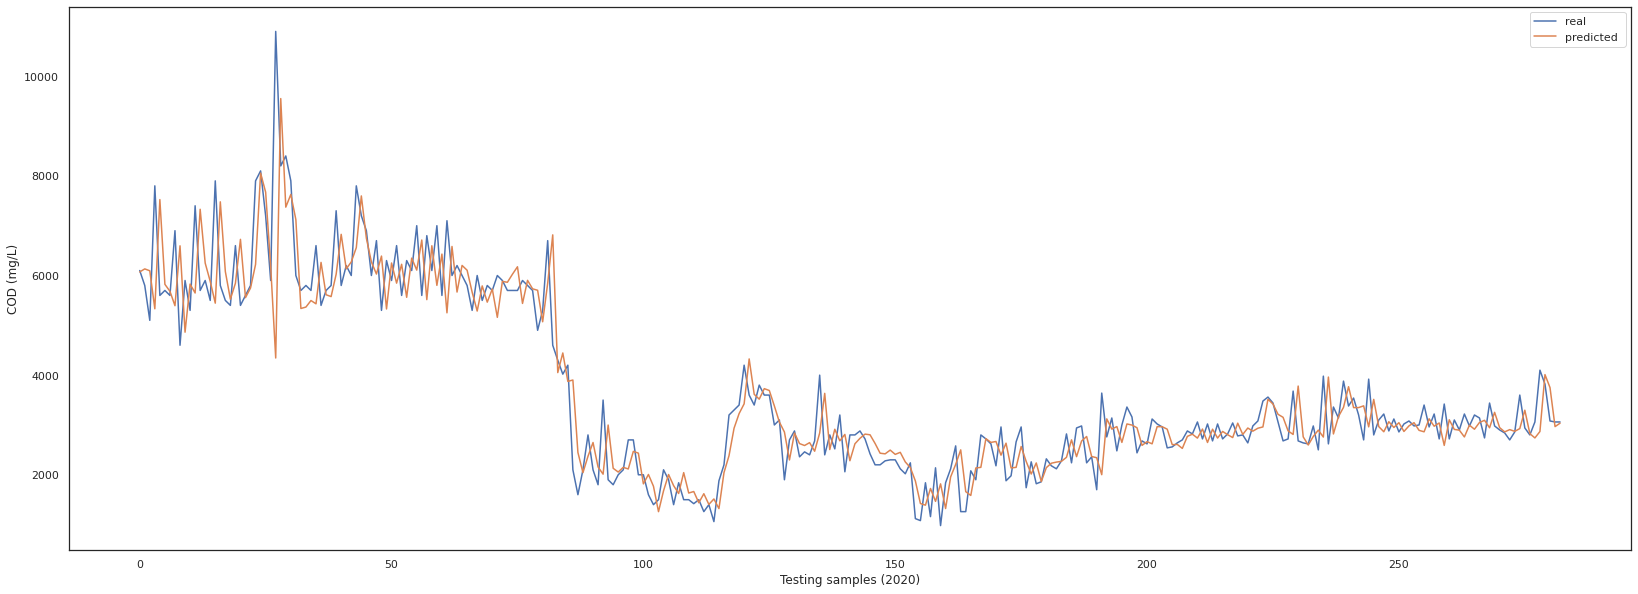

In [ ]:
ensemble_model2.testing(dataset.iloc[:-cut_off], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

### Ensemble 3 - Model Selection

In [ ]:
class Ensemble3:
  def __init__(self, df, goal, model1, model2, model3):
    self.df = df.iloc[-len(model1):]
    self.goal = goal
    self.df = self.df.reset_index(drop=True)

    self.df['model1'] = model1
    self.df['model2'] = model2
    self.df['model3'] = model3
 
    self.df['target'] = self.df[self.goal].shift(-1).fillna(method='ffill')
    self.X = self.df[[self.goal,'model1', 'model2', 'model3']]

    model1 = abs(self.df['model1'] - self.df['target'])
    model2 = abs(self.df['model2'] - self.df['target'])
    model3 = abs(self.df['model3'] - self.df['target'])

    temp = pd.concat([model1, model2, model3], axis=1)
    temp = temp.idxmin(axis=1)  
    self.Y = pd.get_dummies(temp)

    self.x_mean = self.X.mean()
    self.x_std = self.X.std()
  

    self.X_train = (self.X - self.x_mean)/self.x_std
    self.Y_train = self.Y
 
    print(self.Y_train)

  def pearson_corr(self):
    pearson = self.df.corr(method='pearson')
    fig = plt.figure(figsize=(30,10))
    fig.suptitle('Pearson Correlation', fontsize=16)
    sns.heatmap(pearson,vmax=1, cmap="bwr", linewidths=0.1, annot=True)
    plt.show()

  def training(self, neurons = 16, max_epochs = 50):
    self.model = tf.keras.Sequential()
    self.model.add(Dense(neurons/2, activation='relu', input_dim = self.X_train.shape[1]))
    self.model.add(Dense(neurons, activation='relu'))
    self.model.add(Dense(3, activation='softmax'))

    print(self.Y_train.shape)
    print(self.X_train.shape)

    self.model.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history_Ann = self.model.fit(self.X_train, self.Y_train, epochs=max_epochs, verbose=1, validation_split=0.1)
    # Plot training & validation loss values
    plt.plot(history_Ann.history['loss'])
    plt.plot(history_Ann.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    self.model.save('Ensemble.h5')

  def testing(self, df_test, model1, model2, model3):
    self.df_test = df_test.iloc[-len(model1):]
    self.df_test = self.df_test.reset_index(drop=True)
    self.df_test[self.goal] = self.df_test[self.goal].fillna(method='ffill')

    self.df_test['model1'] = model1
    self.df_test['model2'] = model2
    self.df_test['model3'] = model3

    self.df_test['target'] = self.df_test[self.goal].shift(-1).fillna(method='ffill')

    self.Xt = self.df_test[[self.goal,'model1', 'model2', 'model3']]

    model1 = abs(self.df_test['model1'] - self.df_test['target'])
    model2 = abs(self.df_test['model2'] - self.df_test['target'])
    model3 = abs(self.df_test['model3'] - self.df_test['target'])

    temp = pd.concat([model1, model2, model3], axis=1)
    temp = temp.idxmin(axis=1)  
    self.Yt = pd.get_dummies(temp)   

    self.Y_test = self.Yt
    self.X_test = (self.Xt - self.x_mean)/self.x_std
    print(self.X_test, self.Y_train)

    self.score = self.model.evaluate(self.X_test, self.Y_test)
    self.prediction = self.model.predict(self.X_test)
    
    self.full_prediction = np.zeros(len(self.prediction))
    self.selection = pd.DataFrame(self.prediction).idxmax(axis=1)

    
    for i in range(len(self.prediction)):
      self.full_prediction[i] = self.df_test[f'model{int(self.selection[i])+1}'][i]
    # print(self.full_prediction)

    self.Ys_test = self.df_test['target']
    print('*** ANN Ensemble estimation ***')
    print ('MAPEtf: ',tf.keras.losses.mean_absolute_percentage_error(self.Ys_test, self.full_prediction))
    print ('MAPEsci: ',mean_absolute_error(self.Ys_test, self.full_prediction)*100)
    print ('MAPE: ',mean_absolute_percentage_error(self.Ys_test, self.full_prediction))
    print ('R2: ',r2_score(self.Ys_test, self.full_prediction))
    print ('RMSE: ',mean_squared_error(self.Ys_test, self.full_prediction, squared=False))

    # plot baseline and predictions
    plt.figure(figsize=(28,10))
    plt.plot(self.Ys_test, label = 'real ')
    plt.plot(self.full_prediction, label = 'predicted ')
    plt.ylabel('COD (mg/L)')
    plt.xlabel('Testing samples (2020)')
    plt.legend()
    plt.show()

     0  1  2
0    1  0  0
1    0  0  1
2    0  0  1
3    0  1  0
4    0  1  0
..  .. .. ..
278  1  0  0
279  0  0  1
280  0  0  1
281  0  0  1
282  0  1  0

[283 rows x 3 columns]
(283, 3)
(283, 4)
Epoch 1/50
8/8 [==============================] - 1s 26ms/step - loss: 1.2254 - accuracy: 0.3071 - val_loss: 1.1108 - val_accuracy: 0.2414
Epoch 2/50
8/8 [==============================] - 0s 4ms/step - loss: 1.1977 - accuracy: 0.3031 - val_loss: 1.1058 - val_accuracy: 0.2414
Epoch 3/50
8/8 [==============================] - 0s 4ms/step - loss: 1.1766 - accuracy: 0.3150 - val_loss: 1.1012 - val_accuracy: 0.3448
Epoch 4/50
8/8 [==============================] - 0s 4ms/step - loss: 1.1589 - accuracy: 0.3583 - val_loss: 1.0980 - val_accuracy: 0.3793
Epoch 5/50
8/8 [==============================] - 0s 4ms/step - loss: 1.1452 - accuracy: 0.3898 - val_loss: 1.0956 - val_accuracy: 0.4138
Epoch 6/50
8/8 [==============================] - 0s 3ms/step - loss: 1.1300 - accuracy: 0.3858 - val_loss: 1.0

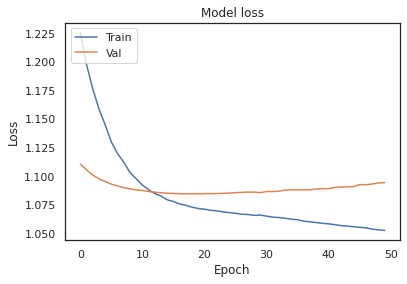

In [ ]:
ensemble_model3 = Ensemble3(dataset.iloc[:-cut_off], active_target, app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)
ensemble_model3.training()

     BT_C_MVLSS    model1    model2    model3
0      1.104038  1.335583  1.182308  1.399651
1      1.325904  1.349545  1.366237  1.392829
2      1.159505  1.357382  1.736667  1.450428
3      0.771239  1.143379  1.376915  0.982669
4      2.268835  1.460553  1.142401  2.061839
..          ...       ...       ...       ...
278   -0.360277 -0.429457 -0.546053 -0.472746
279    0.216574 -0.255689 -0.420777  0.208024
280    0.061268 -0.220383 -0.163785 -0.241993
281   -0.349184 -0.289441 -0.436010 -0.367991
282   -0.360277 -0.291018 -0.344424 -0.020759

[283 rows x 4 columns]      0  1  2
0    1  0  0
1    0  0  1
2    0  0  1
3    0  1  0
4    0  1  0
..  .. .. ..
278  1  0  0
279  0  0  1
280  0  0  1
281  0  0  1
282  0  1  0

[283 rows x 3 columns]
9/9 [==============================] - 0s 1ms/step - loss: 1.0565 - accuracy: 0.4452
*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(11.721548247891672, shape=(), dtype=float64)
MAPEsci:  36150.37683653506
MAPE:  11.72154824789167
R2:  0.927

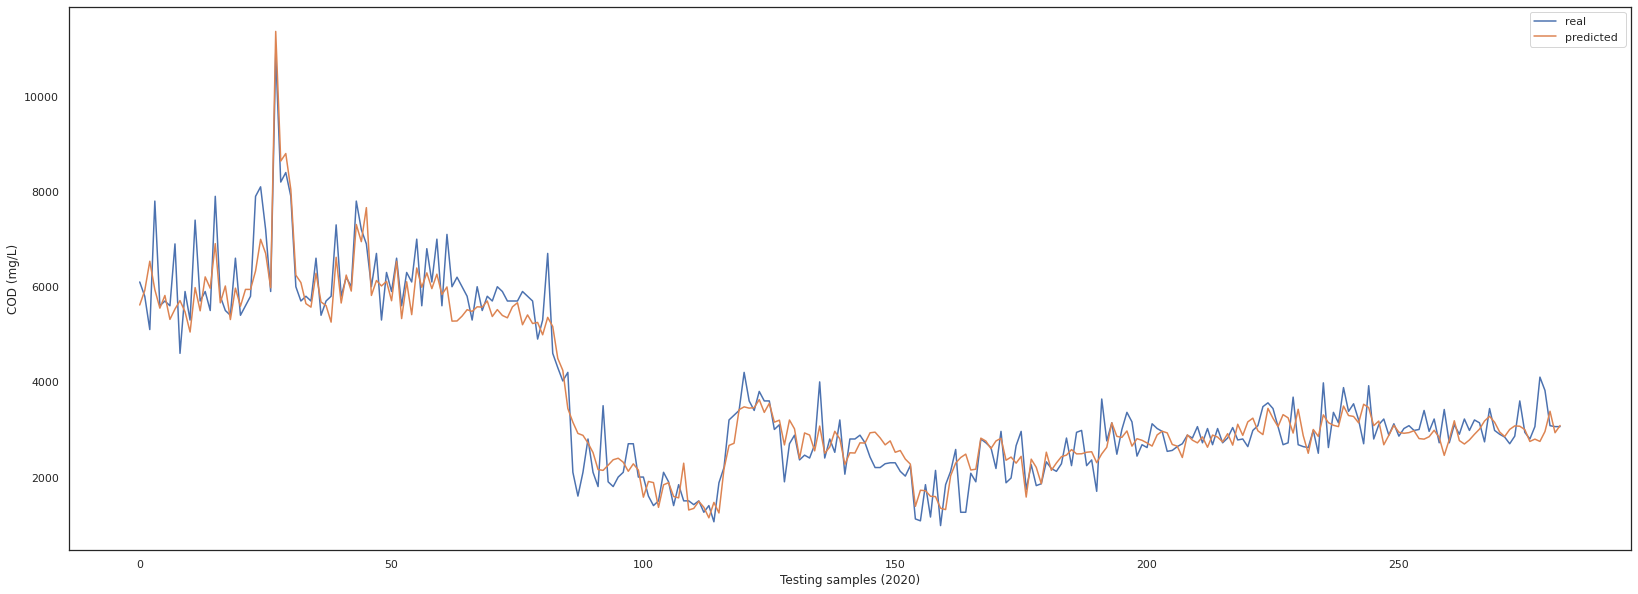

In [ ]:
ensemble_model3.testing(dataset.iloc[:-cut_off], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

In [ ]:
ensemble_model3.selection.to_list().count(1)

270

## Testing


*** ANN estimation ***
MAPE:  10.030612440999509
R2:  -0.1723843237892253
RMSE:  498.48191599753255


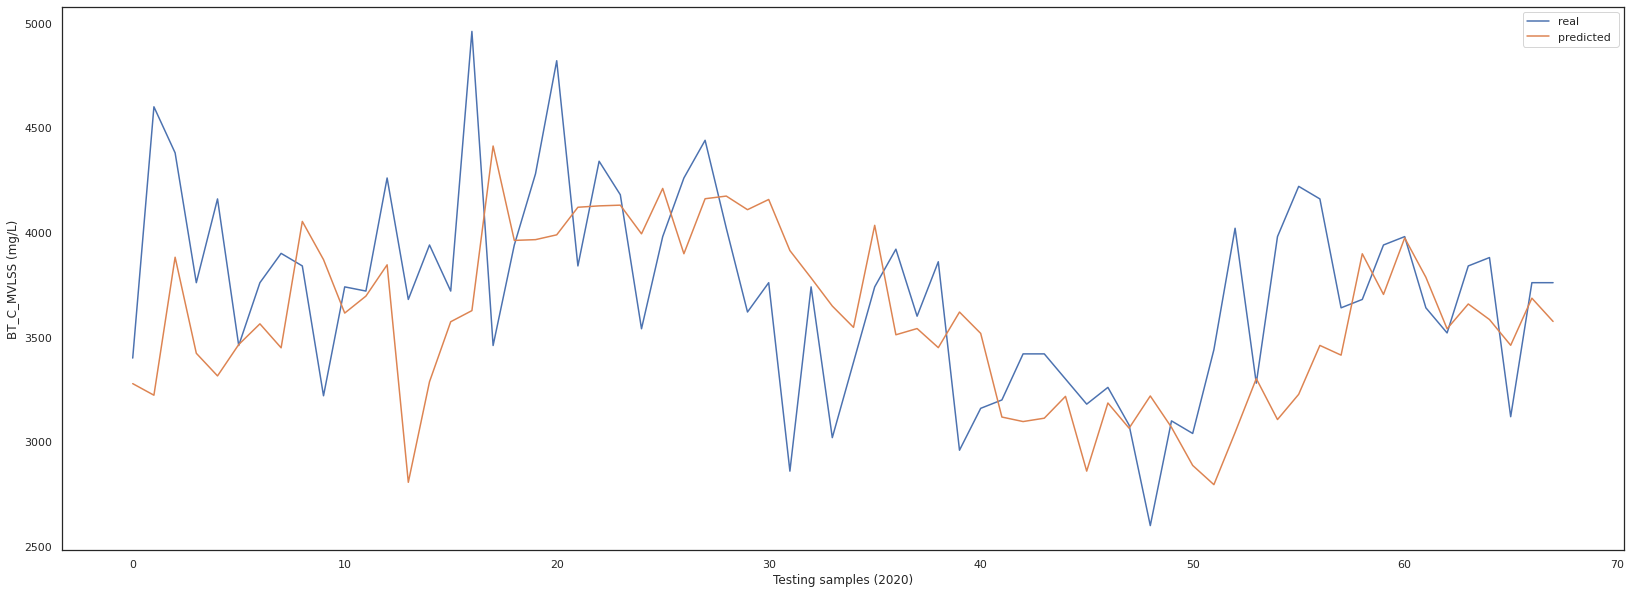

(68,)

In [ ]:
app1.testing(dataset.iloc[-(cut_off + 7):])
app1.full_prediction.shape

*** LSTM estimation ***
MAPE:  18.929247208724746
R2:  -2.4419946610231262
RMSE:  854.121201524332


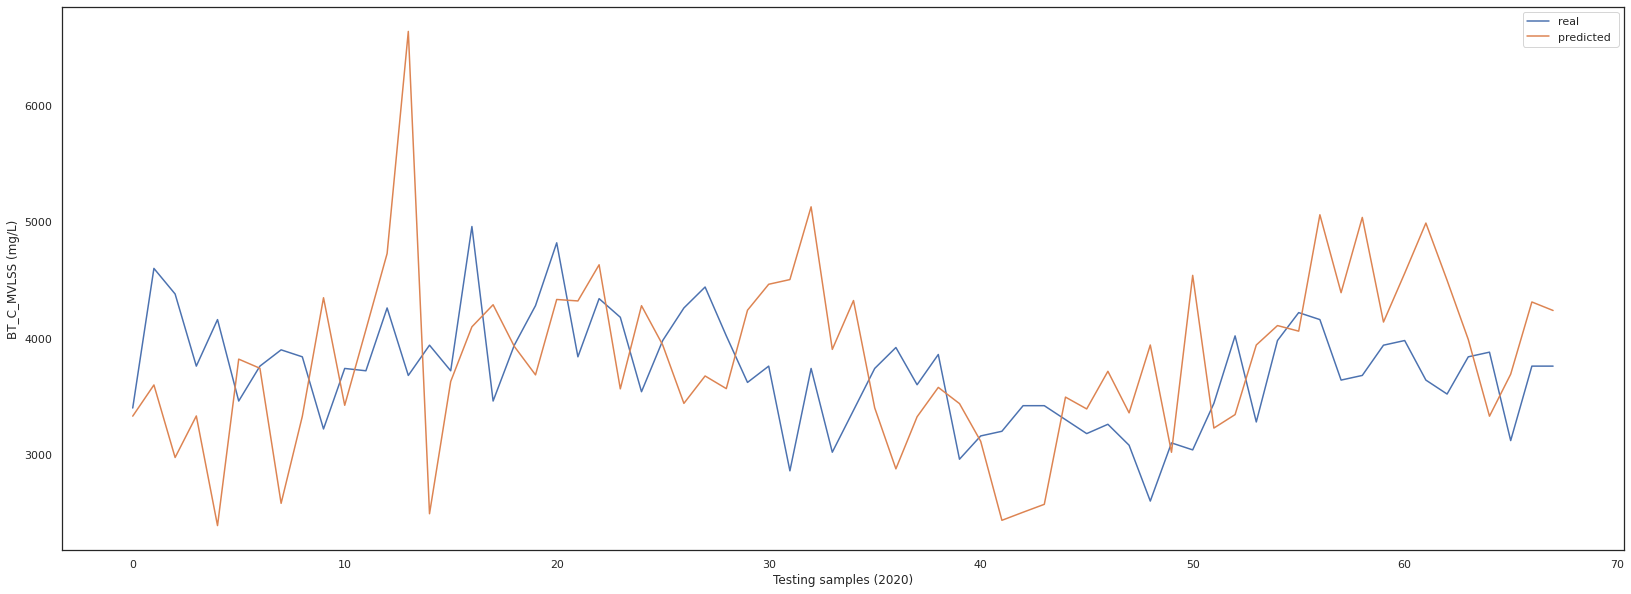

(68, 1)

In [ ]:
app2.testing(dataset.iloc[-(cut_off+2):])
app2.full_prediction.shape

*** Delta estimation ***
MAPE:  15.630236953885143
R2:  -1.4818412560284866
RMSE:  725.2728260588102


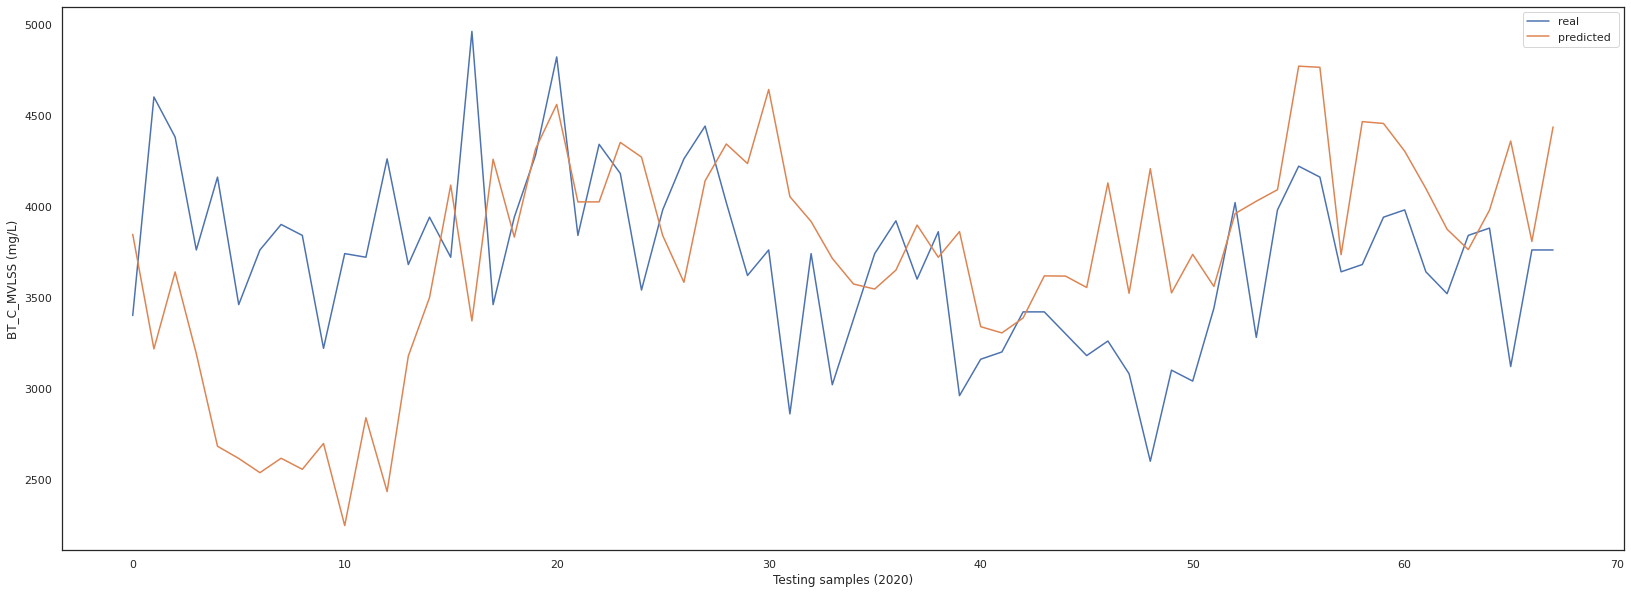

(68,)

In [ ]:
app3.testing(dataset.iloc[-cut_off:])
app3.full_prediction.shape

*** Ensemble estimation ***
MAPE:  12.363818720405805
R2:  -0.4934129427286975


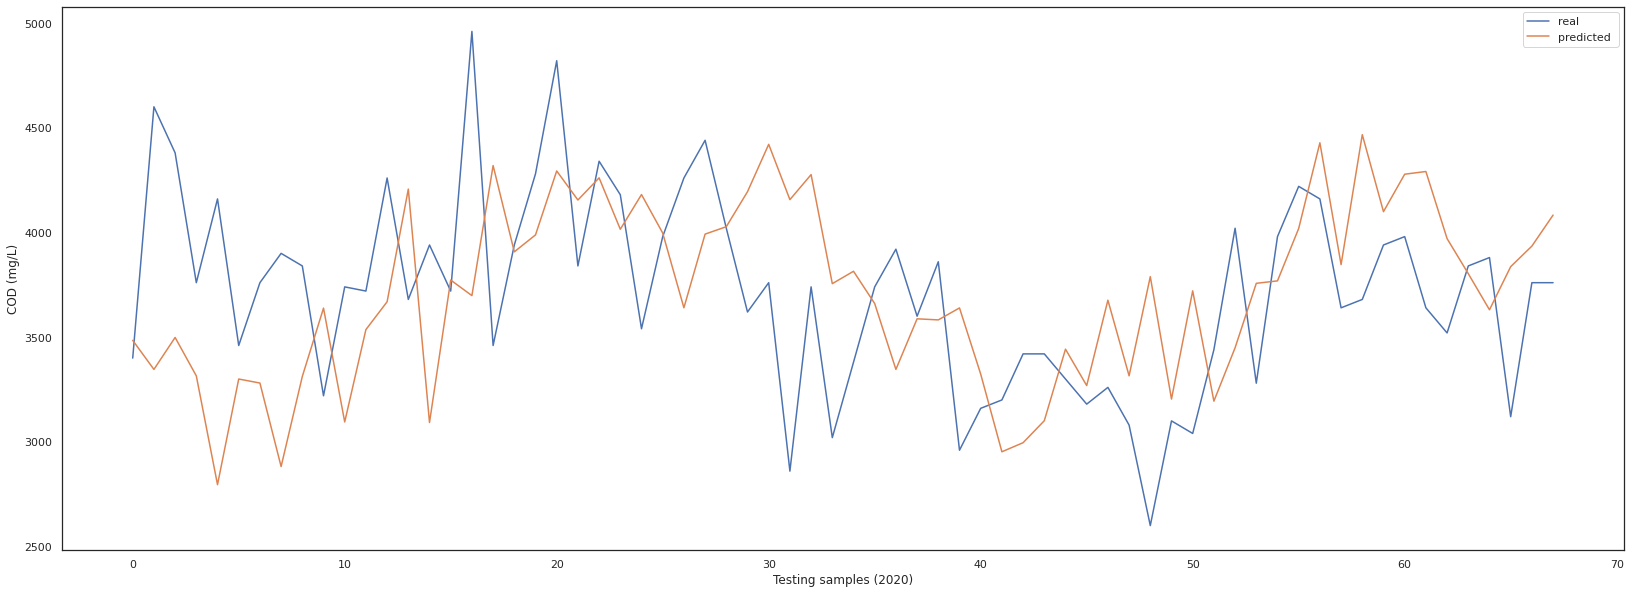

In [ ]:
ensemble = (app1.full_prediction + app2.full_prediction['Prediction'] + app3.full_prediction)/3
print('*** Ensemble estimation ***')
print ('MAPE: ',mean_absolute_percentage_error(app2.Y_test.values, ensemble.values))
print ('R2: ',r2_score(app2.Y_test.values, ensemble.values))
#print ('R2: ',r2_score(app2.Y_test.values, ensemble.values))
# plot baseline and predictions
plt.figure(figsize=(28,10))
plt.plot(app2.Y_test.values, label = 'real ')
plt.plot(ensemble.values, label = 'predicted ')
plt.ylabel('COD (mg/L)')
plt.xlabel('Testing samples (2020)')
plt.legend()
plt.show()

*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(
[10.571297 10.302292 13.319081 12.669128 34.968422 10.79125  10.249607
 31.25642   9.941566 24.96604  11.038316 17.057713 32.735237 64.16745
 27.923525 11.352919 20.693367 30.46286  22.120697 15.172694 25.05987
 28.7305   33.397655 15.131903 25.983557 24.762596 10.119052 18.744194
 15.781854 26.7187   28.617283 29.196194 38.68905  17.377872 25.512466
 10.490088 18.014229 10.402695 10.042989  9.945572 16.080847 30.058283
 28.140718 25.607365 10.518151 11.198666 12.010962 12.083715 13.7844
 16.921972 25.091112 13.18979  10.060235 15.275967 16.810026 15.227845
 35.250835 25.49413  35.802944 18.74173  29.759962 36.217697 28.081816
 18.851912 10.034511 11.895502 25.381815 20.252722], shape=(68,), dtype=float32)
MAPEsci:  69123.27521829044
MAPE:  20.76917412282695
R2:  -2.5072046013435236
RMSE:  862.1740700568076


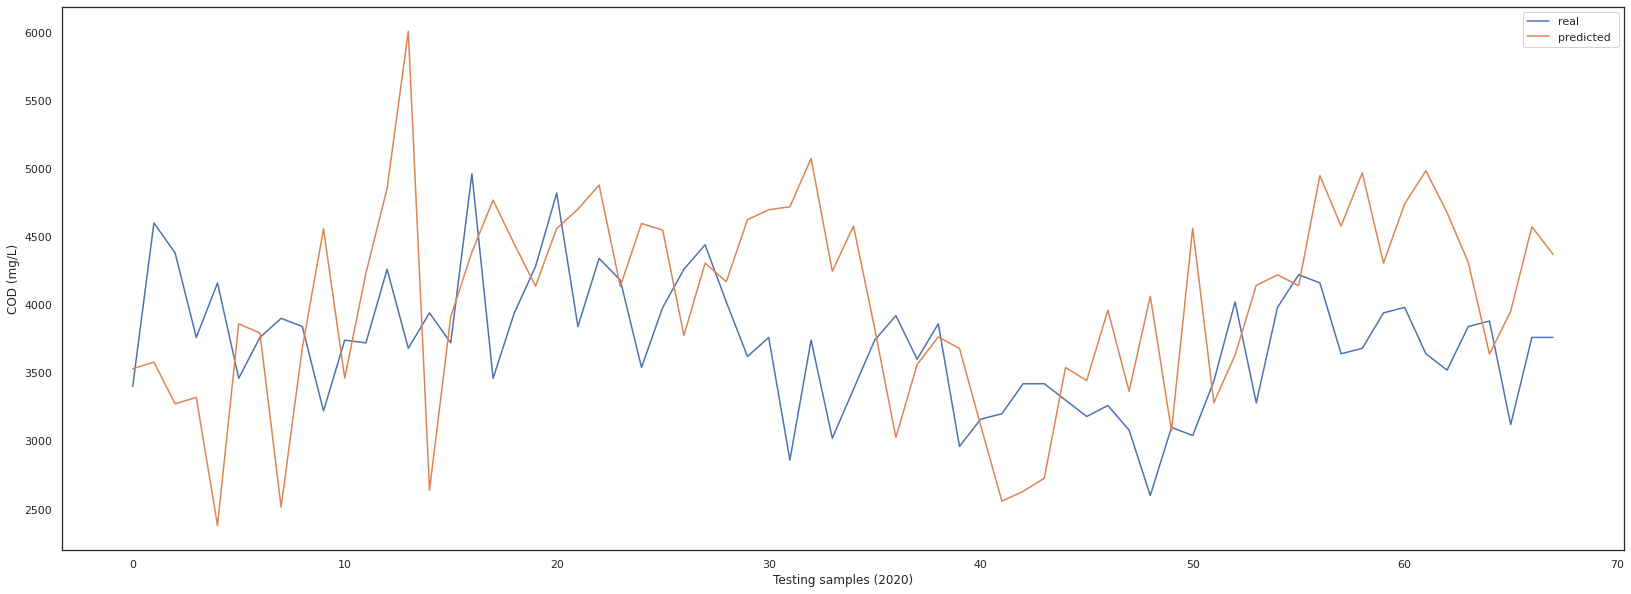

In [ ]:
ensemble_model.testing(dataset.iloc[-142:], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(
[16.887957  10.5688505 18.148224  11.5788555 21.520325  12.657136
 15.170127  22.735733  24.19682   12.19893   24.70001   10.8857
 14.379591   9.932488  14.342755  16.455599  12.362218  36.39679
 10.227862  18.984795  28.559034  31.949657  17.643517  26.414417
 25.674667  10.769331  12.667664  24.862438  28.711092  22.082333
 14.798275  15.527217  16.477623  13.6007595 12.331522  12.462574
 10.711788  12.439377   9.923091  12.207731  18.310577  23.982292
 22.55636   16.964533  11.161655  13.69649   11.064465  14.060537
 11.707169  24.656162  13.495801  17.652317  10.420185  19.66142
 10.171222  22.534191  25.371918  22.804901  11.633647  15.506685
 20.065361  19.761513  12.392936  10.719284  11.799186  17.7565
 11.907995  16.140226 ], shape=(68,), dtype=float32)
MAPE:  16.94265325919142
R2:  -0.8993551976226517
RMSE:  634.4793631237877


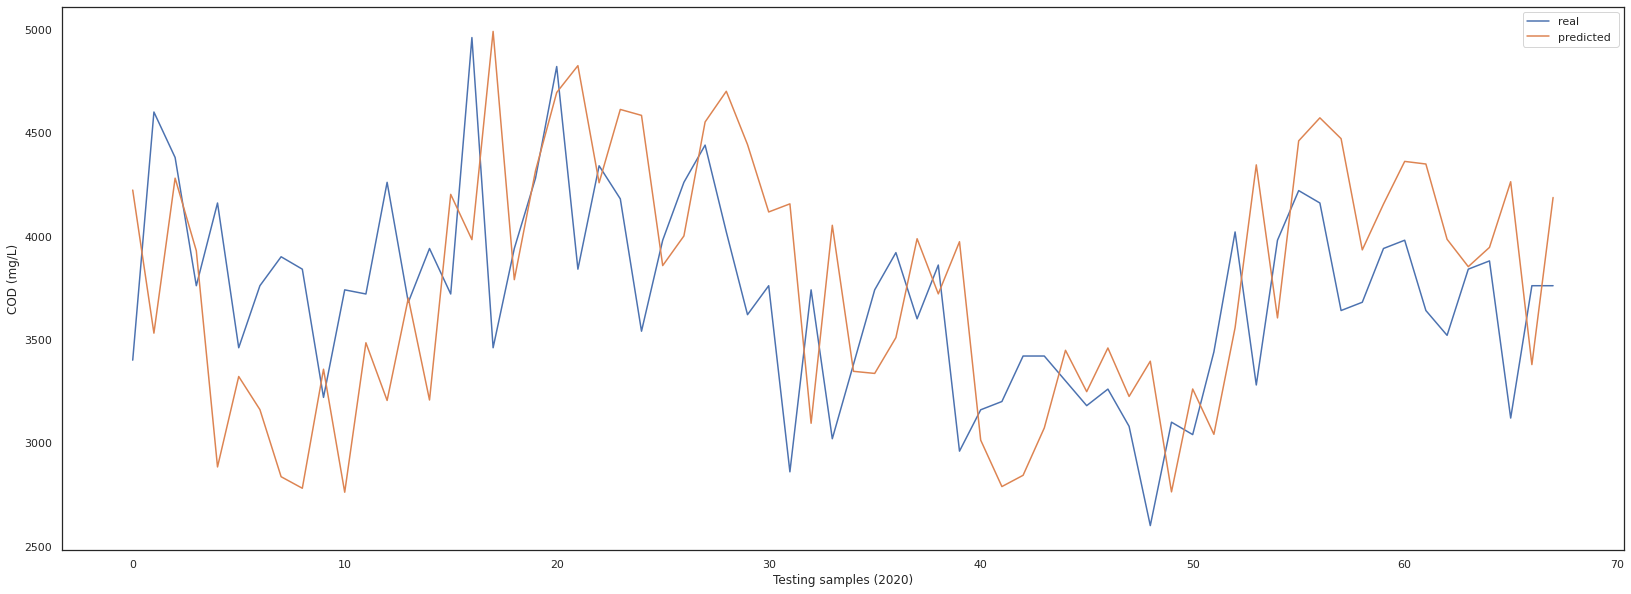

In [ ]:
ensemble_model2.testing(dataset.iloc[-142:], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

    BT_C_MVLSS    model1    model2    model3
0     0.238761 -0.258116 -0.195885  0.124496
1    -0.171691 -0.290506 -0.034211 -0.299699
2     0.493907  0.095538 -0.410092 -0.014897
3     0.371880 -0.173218 -0.194800 -0.317691
4     0.027988 -0.236498 -0.762952 -0.660309
..         ...       ...       ...       ...
63   -0.105132 -0.035266  0.201345  0.067863
64    0.072361 -0.078836 -0.196151  0.213845
65    0.094548 -0.150863  0.021607  0.469931
66   -0.326998 -0.019064  0.395788  0.098201
67    0.027988 -0.084112  0.351673  0.522215

[68 rows x 4 columns]      0  1  2
0    1  0  0
1    0  0  1
2    0  0  1
3    0  1  0
4    0  1  0
..  .. .. ..
278  1  0  0
279  0  0  1
280  0  0  1
281  0  0  1
282  0  1  0

[283 rows x 3 columns]
3/3 [==============================] - 0s 3ms/step - loss: 1.1942 - accuracy: 0.1765
*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(18.656896446088204, shape=(), dtype=float64)
MAPEsci:  67834.11147173712
MAPE:  18.656896446088204
R2:  -2.44199466102312

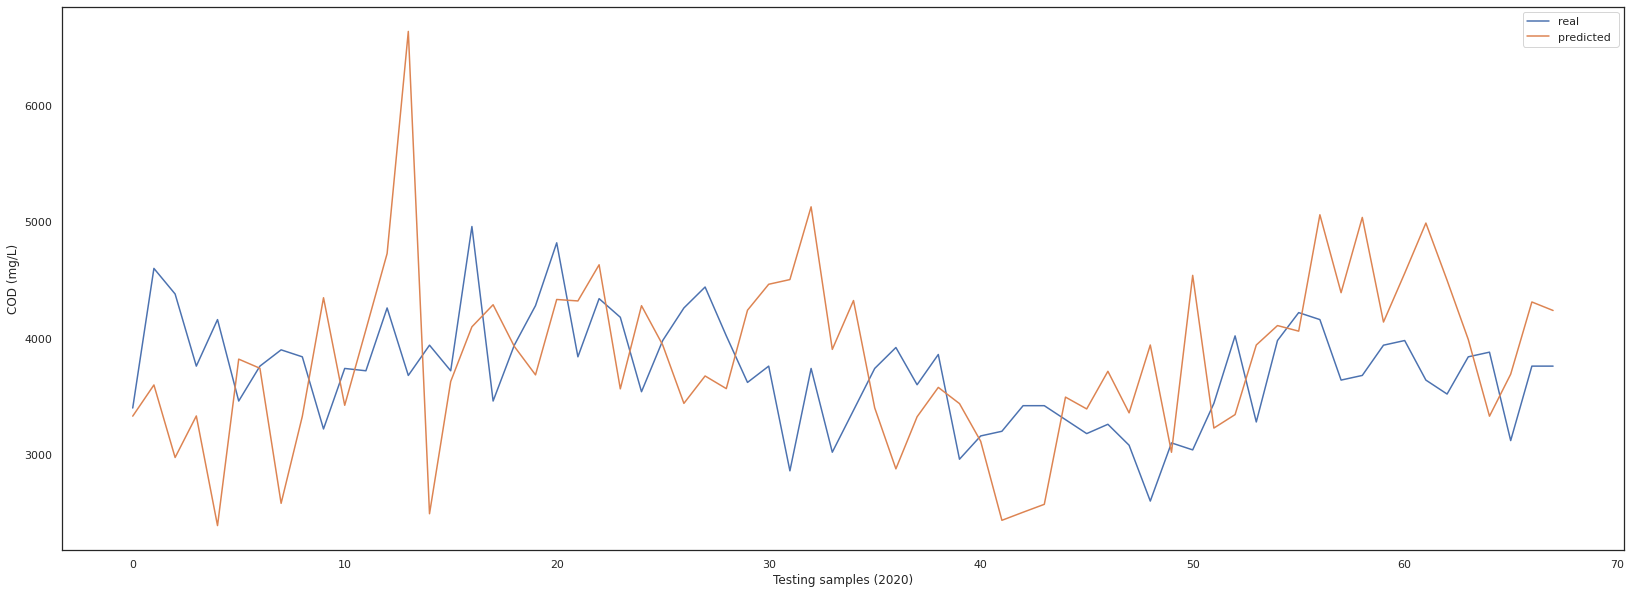

In [ ]:
ensemble_model3.testing(dataset.iloc[-142:], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

In [ ]:
ensemble_model3.selection.to_list().count(3)

0

# EQ_COD

In [ ]:
active_target = "EQ_COD"
dataset = dataset2.copy()
dataset.shape
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358 entries, 396 to 753
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        358 non-null    object 
 1   Flow_to_EQ  358 non-null    object 
 2   Flow_efl    358 non-null    float64
 3   BT_C_MLSS   358 non-null    float64
 4   BT_C_MVLSS  358 non-null    float64
 5   BT_N_MLSS   358 non-null    float64
 6   BT_N_MVLSS  358 non-null    float64
 7   D_SS        358 non-null    float64
 8   EQ_N        358 non-null    float64
 9   BT_C_N      358 non-null    float64
 10  BT_N_N      358 non-null    float64
 11  D_N         358 non-null    float64
 12  OxT_PH_PM   358 non-null    float64
 13  EQ_PH       358 non-null    float64
 14  BT_N_PH     358 non-null    float64
 15  D_PH        358 non-null    float64
 16  BT_N_DO     358 non-null    float64
 17  BT_C_DO     358 non-null    float64
 18  Clari_DO    358 non-null    float64
 19  F/M         358 non-null   

## Approach 1

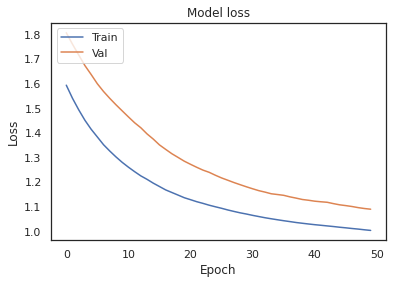

*** ANN estimation ***
MAPE:  7.830131714604543
R2:  0.1679860174096467
RMSE:  38.541485090749134


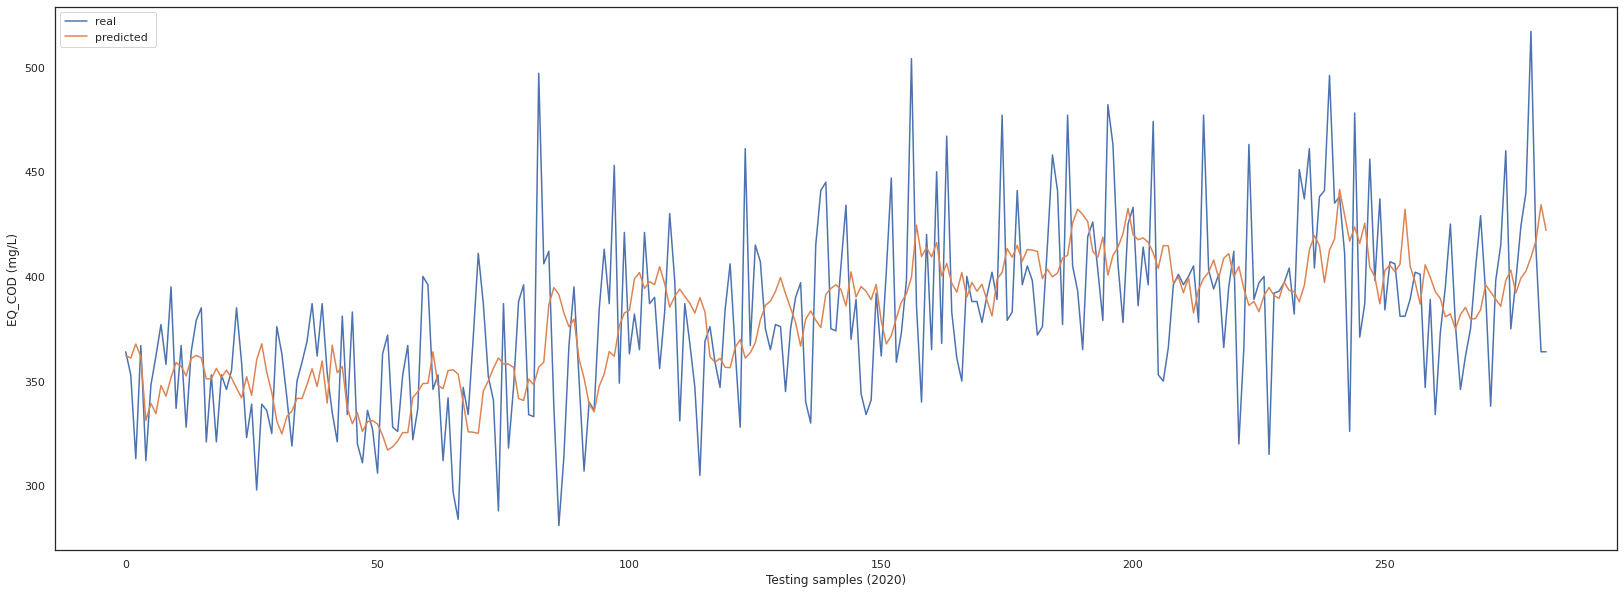

(283,)

In [ ]:
cut_off = 68
app1 = approach1(dataset.iloc[:-cut_off], active_target)
# app1.tune()
# print(app1.best_tuned)
# with open('EQ_COD1.pickle', 'wb') as handle:
#   pickle.dump(app1.best_tuned, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('EQ_COD_tuning_1.pickle', 'wb') as handle:
#   pickle.dump(app1.tune_results, handle, protocol=pickle.HIGHEST_PROTOCOL)
app1.training()
app1.testing(dataset.iloc[:-cut_off])
# app1.testing(dataset.iloc[-142:])
app1.full_prediction.shape

## Approach 2

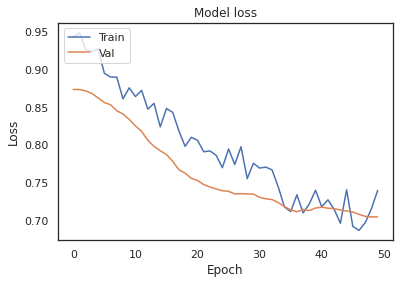

*** LSTM estimation ***
MAPE:  9.75707392656925
R2:  0.32081160583553014
RMSE:  34.82236477568104


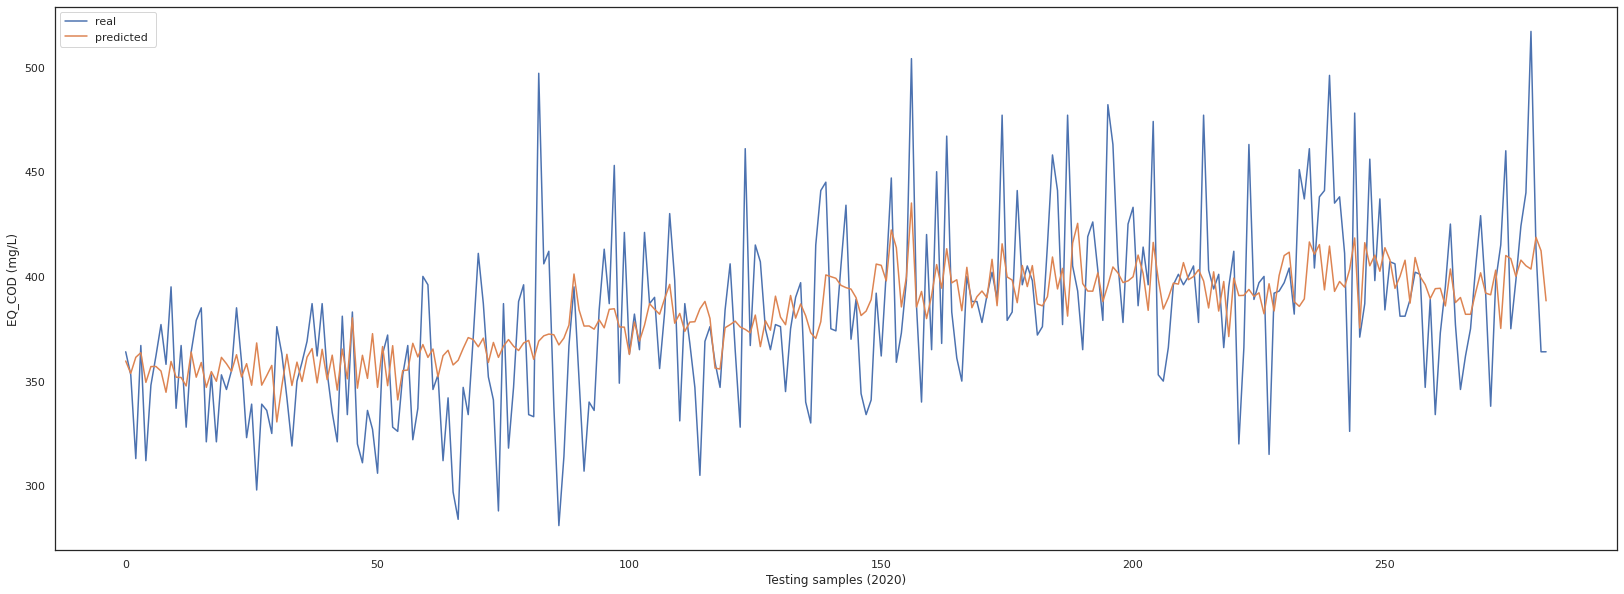

(283, 1)

In [ ]:
app2 = approach2(dataset.iloc[:-cut_off], active_target)
app2.series_to_supervised(n_in=2)
app2.supervised
app2.training()
# app2.testing(dataset.iloc[-137:])
app2.testing(dataset.iloc[5:-cut_off])
app2.full_prediction.shape

## Approach 3

*** Delta estimation ***
MAPE:  7.257767521494459
R2:  0.2530625728742921
RMSE:  36.51785359862309


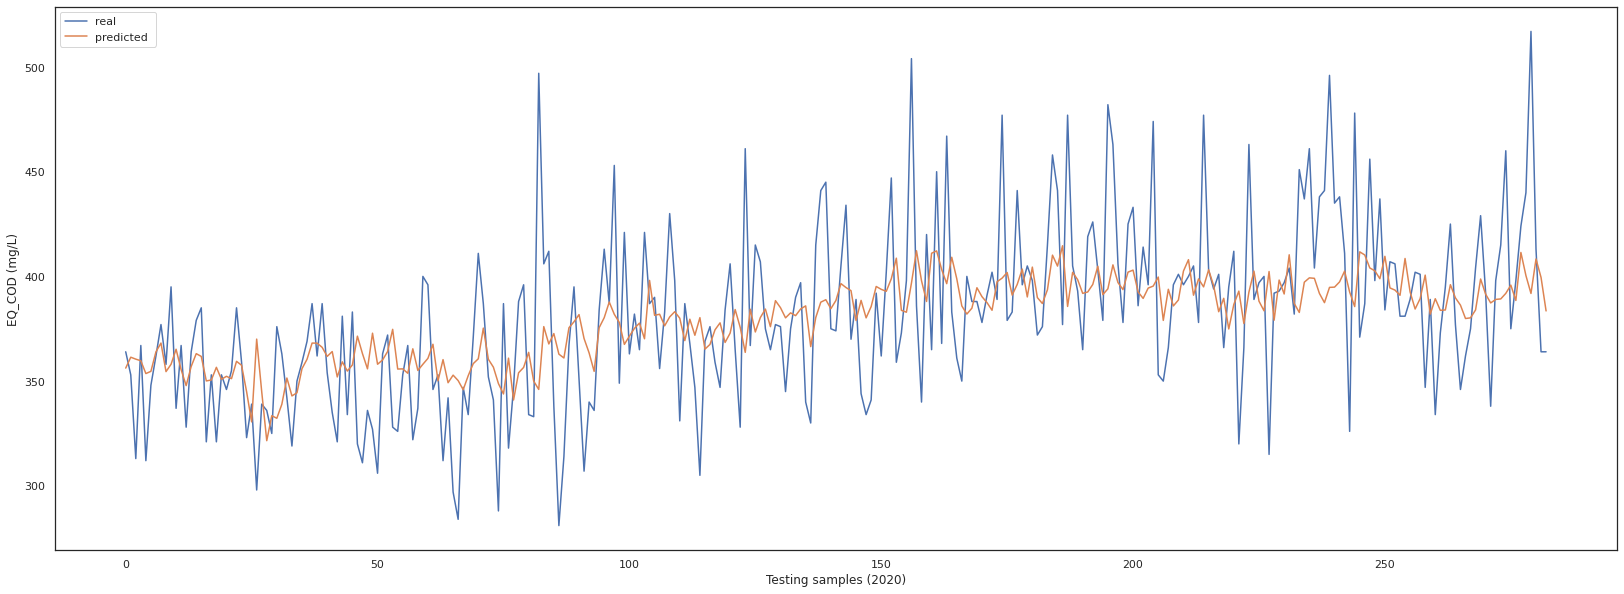

(283,)

In [ ]:
app3 = approach3(dataset.iloc[:-cut_off], active_target)
app3.training()
app3.testing(dataset.iloc[7:-cut_off])
# app3.testing(dataset.iloc[-135:])
app3.full_prediction.shape

## Approaches

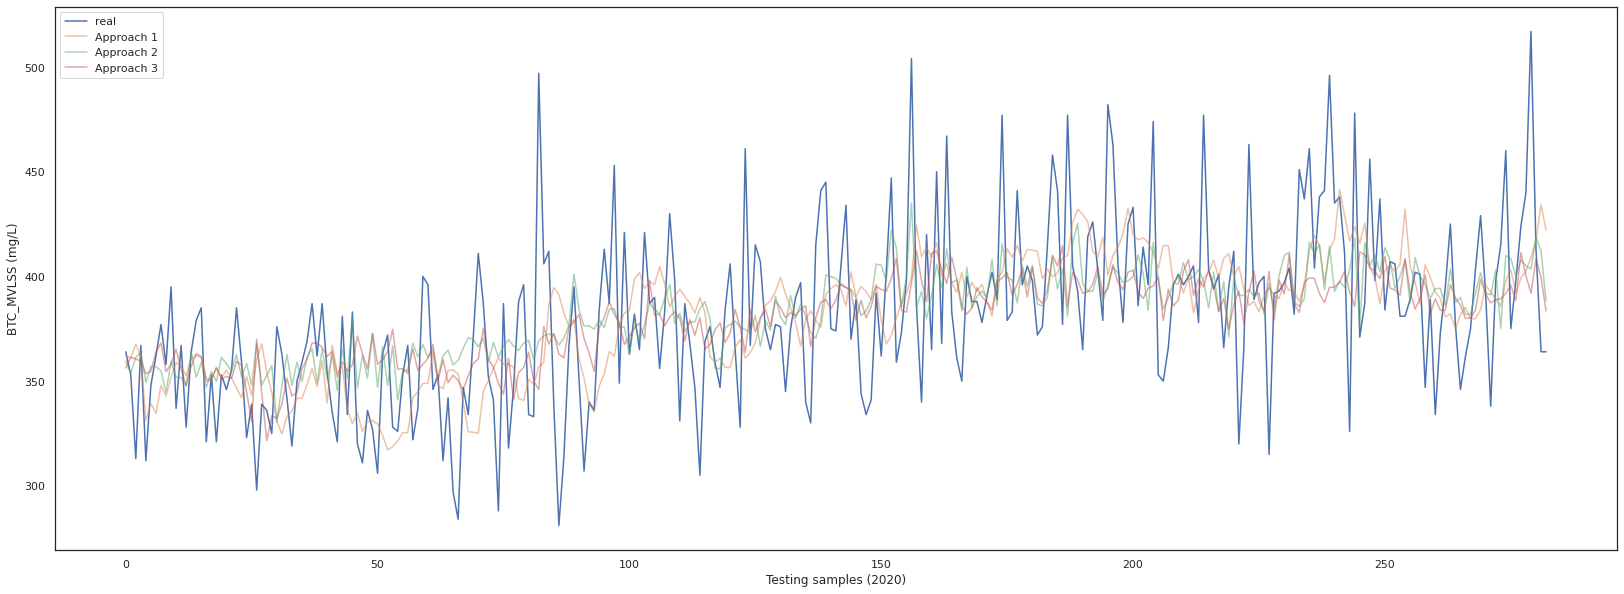

In [ ]:
plt.figure(figsize=(28,10))
plt.plot(app1.Y_test.values, label = 'real ')
plt.plot(app1.full_prediction,'-', alpha= 0.5, label = 'Approach 1')
plt.plot(app2.full_prediction['Prediction'], alpha= 0.5, label = 'Approach 2')
plt.plot(app3.full_prediction, alpha= 0.5, label = 'Approach 3')
plt.ylabel('BTC_MVLSS (mg/L)')
plt.xlabel('Testing samples (2020)')
plt.legend()
plt.show()

## Ensemble

In [ ]:
app1.full_prediction + app2.full_prediction['Prediction'] + app3.full_prediction

0      1077.959854
1      1076.156549
2      1089.560756
3      1085.065745
4      1034.171155
          ...     
278    1208.003017
279    1204.504219
280    1244.050125
281    1245.966174
282    1193.810763
Length: 283, dtype: float64

### Ensemble AVG

*** Ensemble estimation ***
MAPE:  7.32926667972678
R2:  0.2504458193317658
RMSE:  36.58176435811738


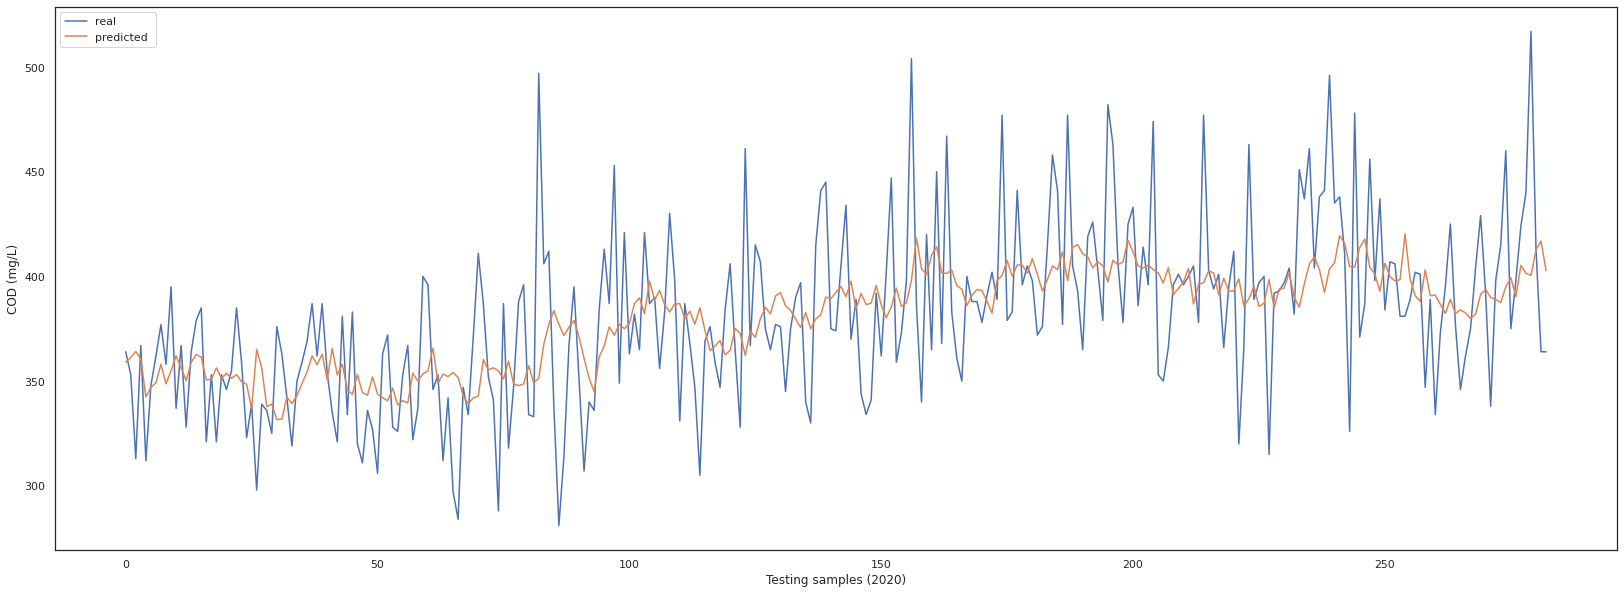

In [ ]:
ensemble = (app1.full_prediction + app3.full_prediction)/2
print('*** Ensemble estimation ***')
print ('MAPE: ',mean_absolute_percentage_error(app2.Y_test.values, ensemble))
print ('R2: ',r2_score(app2.Y_test.values, ensemble))
print ('RMSE: ',mean_squared_error(app2.Y_test.values, ensemble, squared=False))
# plot baseline and predictions
plt.figure(figsize=(28,10))
plt.plot(app2.Y_test.values, label = 'real ')
plt.plot(ensemble.values, label = 'predicted ')
plt.ylabel('COD (mg/L)')
plt.xlabel('Testing samples (2020)')
plt.legend()
plt.show()

*** Ensemble estimation ***
MAPE:  7.170300687521765
R2:  0.2912805241866777
RMSE:  35.571347414792555


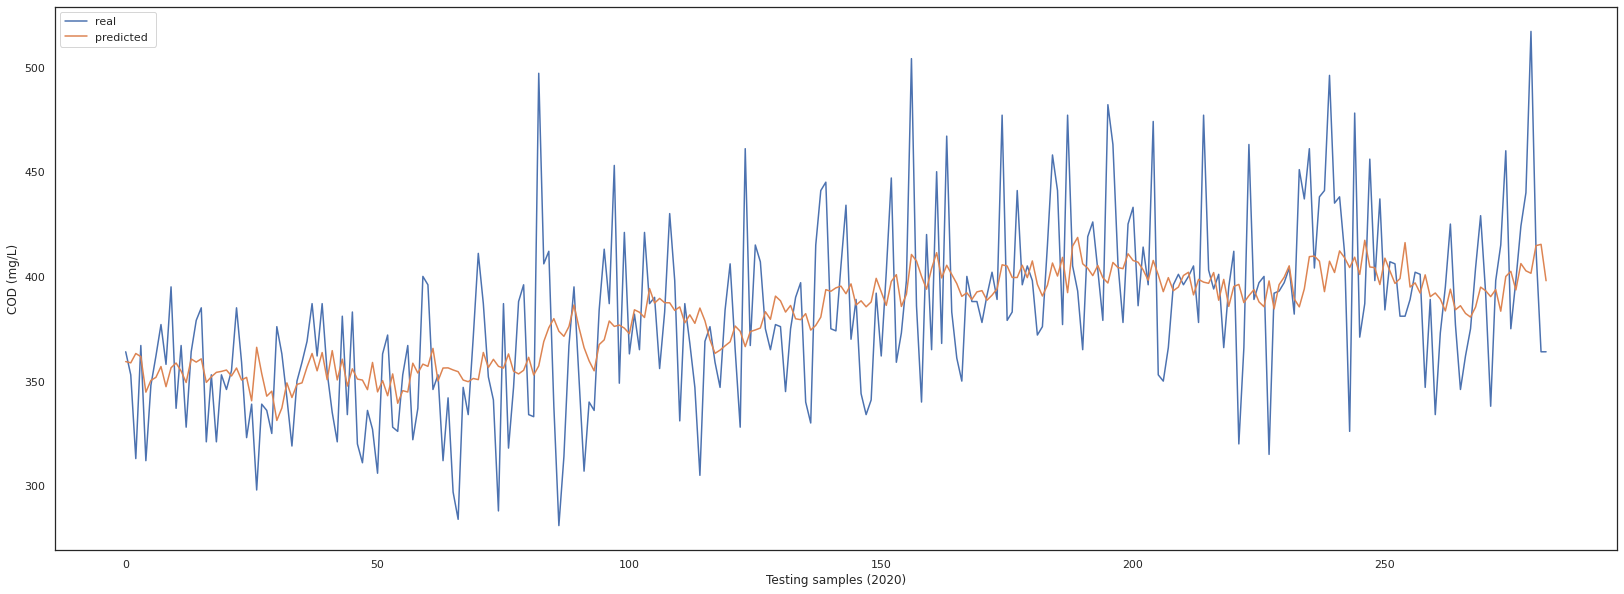

In [ ]:
ensemble = (app1.full_prediction + app2.full_prediction['Prediction'] + app3.full_prediction)/3
print('*** Ensemble estimation ***')
print ('MAPE: ',mean_absolute_percentage_error(app2.Y_test.values, ensemble))
print ('R2: ',r2_score(app2.Y_test.values, ensemble))
print ('RMSE: ',mean_squared_error(app2.Y_test.values, ensemble, squared=False))
# plot baseline and predictions
plt.figure(figsize=(28,10))
plt.plot(app2.Y_test.values, label = 'real ')
plt.plot(ensemble.values, label = 'predicted ')
plt.ylabel('COD (mg/L)')
plt.xlabel('Testing samples (2020)')
plt.legend()
plt.show()

### Ensemble 1 - Model Fusion

In [ ]:
class Ensemble:
  def __init__(self, df, goal, model1, model2, model3):
    self.df = df.iloc[-len(model1):]
    self.goal = goal
    self.df = self.df.reset_index(drop=True)
    
    self.df['model1'] = model1
    self.df['model2'] = model2
    self.df['model3'] = model3

    self.df['target'] = self.df[self.goal].shift(-1).fillna(method='ffill')

    self.X = self.df[['model1', 'model2', 'model3']]
    self.Y = self.df['target'] 
    # print(self.X)

    self.x_mean = self.X.mean()
    self.x_std = self.X.std()
    self.y_mean = self.Y.mean()
    self.y_std = self.Y.std()
    # print(self.x_mean, self.y_mean)  
  
    self.X_train = (self.X - self.x_mean)/self.x_std
    self.Y_train = (self.Y - self.y_mean)/self.y_std
    # print(self.X_test, self.Y_train)
  
  def pearson_corr(self):
    pearson = self.df.corr(method='pearson')
    fig = plt.figure(figsize=(30,10))
    fig.suptitle('Pearson Correlation', fontsize=16)
    sns.heatmap(pearson,vmax=1, cmap="bwr", linewidths=0.1, annot=True)
    plt.show()

  def training(self, neurons = 8, max_epochs = 50):
    self.model = tf.keras.Sequential()
    self.model.add(Dense(neurons, activation='relu', input_dim= self.X_train.shape[1]))
    self.model.add(Dense(1))

    self.model.compile(optimizer= 'adam', loss='mse', metrics=['MAPE'])    
    history_Ann = self.model.fit(self.X_train, self.Y_train, epochs=max_epochs, verbose=1, validation_split=0.1)
    # Plot training & validation loss values
    plt.plot(history_Ann.history['loss'])
    plt.plot(history_Ann.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    self.model.save('Ensemble.h5')
  
  def testing(self, df_test, model1, model2, model3):
    self.df_test = df_test.iloc[-len(model1):]
    self.df_test = self.df_test.reset_index(drop=True)
    
    self.df_test['model1'] = model1
    self.df_test['model2'] = model2
    self.df_test['model3'] = model3

    self.df_test['target'] = self.df_test[self.goal].shift(-1).fillna(method='ffill')

    self.Xt = self.df_test[['model1', 'model2', 'model3']]
    self.Y_test = self.df_test['target'] 
    # print(self.Xt)
  
    self.X_test = (self.Xt - self.x_mean)/self.x_std
    # print(self.X_test, self.Y_train)
    
    self.prediction = pd.DataFrame(self.model.predict(self.X_test), columns=['Prediction'])

    self.full_prediction = self.prediction*self.y_std + self.y_mean
    

    print('*** ANN Ensemble estimation ***')
    print ('MAPEtf: ',tf.keras.losses.mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    print ('MAPEsci: ',mean_absolute_error(self.Y_test.values, self.full_prediction.values)*100)
    print ('MAPE: ',mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    print ('R2: ',r2_score(self.Y_test.values, self.full_prediction))
    print ('RMSE: ',mean_squared_error(self.Y_test.values, self.full_prediction, squared=False))

    # plot baseline and predictions
    plt.figure(figsize=(28,10))
    plt.plot(self.Y_test.values, label = 'real ')
    plt.plot(self.full_prediction.values, label = 'predicted ')
    plt.ylabel('COD (mg/L)')
    plt.xlabel('Testing samples (2020)')
    plt.legend()
    plt.show()

Epoch 1/50
8/8 [==============================] - 0s 21ms/step - loss: 1.7041 - MAPE: 261.3541 - val_loss: 0.8732 - val_MAPE: 328.3620
Epoch 2/50
8/8 [==============================] - 0s 4ms/step - loss: 1.5421 - MAPE: 234.6975 - val_loss: 0.8709 - val_MAPE: 348.6329
Epoch 3/50
8/8 [==============================] - 0s 4ms/step - loss: 1.3918 - MAPE: 199.7067 - val_loss: 0.8677 - val_MAPE: 371.7220
Epoch 4/50
8/8 [==============================] - 0s 5ms/step - loss: 1.2712 - MAPE: 186.9413 - val_loss: 0.8641 - val_MAPE: 393.3187
Epoch 5/50
8/8 [==============================] - 0s 5ms/step - loss: 1.1687 - MAPE: 168.0825 - val_loss: 0.8591 - val_MAPE: 418.4085
Epoch 6/50
8/8 [==============================] - 0s 4ms/step - loss: 1.0747 - MAPE: 153.3876 - val_loss: 0.8544 - val_MAPE: 441.8861
Epoch 7/50
8/8 [==============================] - 0s 4ms/step - loss: 1.0081 - MAPE: 147.2180 - val_loss: 0.8498 - val_MAPE: 465.2520
Epoch 8/50
8/8 [==============================] - 0s 4ms/step

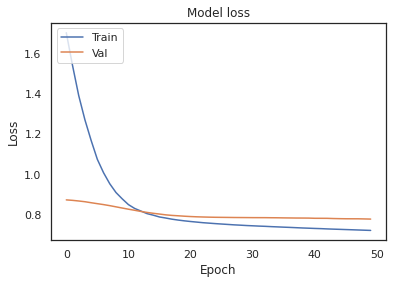

In [ ]:
ensemble_model = Ensemble(dataset.iloc[:-cut_off], active_target, app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)
ensemble_model.training()

*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(
[ 9.423211   9.009443   9.051163   9.37993   10.675536  10.497973
 10.067446   9.167914   9.789727   9.747636   8.876969   9.391422
  9.894076   9.587563   8.866892   9.138775   9.788488  10.070442
  9.31024   10.323532   9.905271  10.012118  10.017799   9.92127
 10.618477  11.957586   9.054506   9.427619  12.396093  12.166147
 11.571125  12.449463  11.494812  11.264716  11.364733   9.9530945
  9.8252325  9.2167225  9.014513   9.174513   9.718659   8.939248
  9.505012   9.6741    10.337494  11.1238365  9.215101  10.672445
 10.620815   9.661973  10.304449  11.084349  10.554651   9.876456
 10.637265  11.151892  11.365643   9.905038  10.379051  10.222776
  9.768161   8.963253  10.14891    9.9556675 10.429934   9.840204
 10.220322  11.737214  11.892153  11.218972  10.981483   9.133462
  9.649558   9.998864   9.990956  10.786639   9.685906  11.146381
 10.812577  10.782781   9.781903  10.532663  10.823029   8.837528
  8.674333   8.720026   

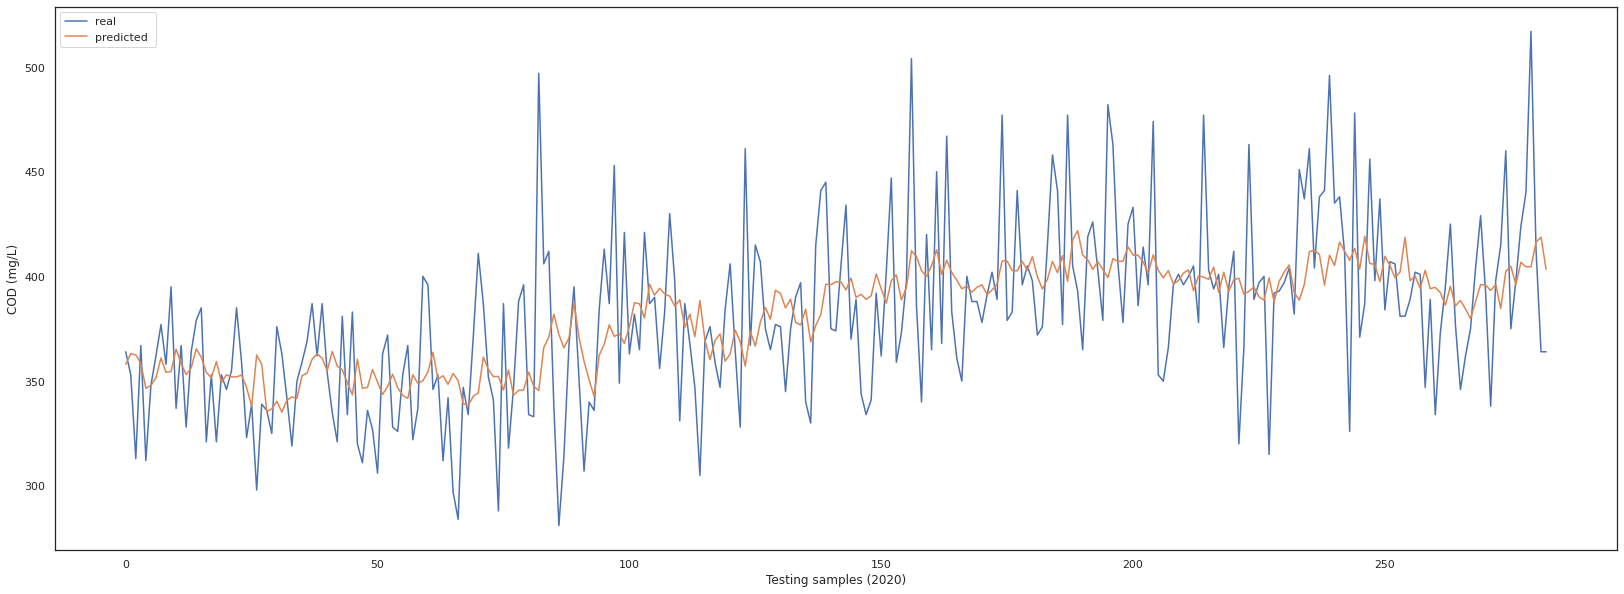

In [ ]:
ensemble_model.testing(dataset.iloc[:-cut_off], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

### Ensemble 2 - Model Fusion + Exo


In [ ]:
class Ensemble2:
  def __init__(self, df, goal, model1, model2, model3):
    self.df = df.iloc[-len(model1):]
    self.goal = goal
    self.df = self.df.reset_index(drop=True)
    
    self.df['model1'] = model1
    self.df['model2'] = model2
    self.df['model3'] = model3

    self.df['target'] = self.df[self.goal].shift(-1).fillna(method='ffill')

    self.X = self.df[[self.goal, 'model1', 'model2', 'model3']]
    self.Y = self.df['target'] 
    # print(self.X)

    self.x_mean = self.X.mean()
    self.x_std = self.X.std()
    self.y_mean = self.Y.mean()
    self.y_std = self.Y.std()
    # print(self.x_mean, self.y_mean)  
  
    self.X_train = (self.X - self.x_mean)/self.x_std
    self.Y_train = (self.Y - self.y_mean)/self.y_std
    # print(self.X_test, self.Y_train)
  
  def pearson_corr(self):
    pearson = self.df.corr(method='pearson')
    fig = plt.figure(figsize=(30,10))
    fig.suptitle('Pearson Correlation', fontsize=16)
    sns.heatmap(pearson,vmax=1, cmap="bwr", linewidths=0.1, annot=True)
    plt.show()

  def training(self, neurons = 8, max_epochs = 50):
    self.model = tf.keras.Sequential()
    self.model.add(Dense(neurons, activation='relu', input_dim= self.X_train.shape[1]))
    self.model.add(Dense(1))

    self.model.compile(optimizer= 'adam', loss='mse', metrics=['MAPE'])    
    history_Ann = self.model.fit(self.X_train, self.Y_train, epochs=max_epochs, verbose=1, validation_split=0.1)
    # Plot training & validation loss values
    plt.plot(history_Ann.history['loss'])
    plt.plot(history_Ann.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    self.model.save('Ensemble.h5')
  
  def testing(self, df_test, model1, model2, model3):
    self.df_test = df_test.iloc[-len(model1):]
    self.df_test = self.df_test.reset_index(drop=True)
    self.df_test[self.goal] = self.df_test[self.goal].fillna(method='ffill')
    
    self.df_test['model1'] = model1
    self.df_test['model2'] = model2
    self.df_test['model3'] = model3

    self.df_test['target'] = self.df_test[self.goal].shift(-1).fillna(method='ffill')

    self.Xt = self.df_test[[self.goal, 'model1', 'model2', 'model3']]
    self.Y_test = self.df_test['target'] 
    # print(self.Xt)
  
    self.X_test = (self.Xt - self.x_mean)/self.x_std
    # print(self.X_test, self.Y_train)
    
    self.prediction = pd.DataFrame(self.model.predict(self.X_test), columns=['Prediction'])

    self.full_prediction = self.prediction*self.y_std + self.y_mean
    

    print('*** ANN Ensemble estimation ***')
    print ('MAPEtf: ',tf.keras.losses.mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    # print ('MAPEsci: ',mean_absolute_error(self.Y_test.values, self.full_prediction.values)*100)
    print ('MAPE: ',mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    print ('R2: ',r2_score(self.Y_test.values, self.full_prediction))
    print ('RMSE: ',mean_squared_error(self.Y_test.values, self.full_prediction, squared=False))

    # plot baseline and predictions
    plt.figure(figsize=(28,10))
    plt.plot(self.Y_test.values, label = 'real ')
    plt.plot(self.full_prediction.values, label = 'predicted ')
    plt.ylabel('COD (mg/L)')
    plt.xlabel('Testing samples (2020)')
    plt.legend()
    plt.show()

Epoch 1/50
8/8 [==============================] - 1s 21ms/step - loss: 1.8162 - MAPE: 348.1357 - val_loss: 2.3627 - val_MAPE: 1339.3097
Epoch 2/50
8/8 [==============================] - 0s 4ms/step - loss: 1.7197 - MAPE: 338.3271 - val_loss: 2.2308 - val_MAPE: 1244.2517
Epoch 3/50
8/8 [==============================] - 0s 4ms/step - loss: 1.6310 - MAPE: 336.3501 - val_loss: 2.1116 - val_MAPE: 1152.8485
Epoch 4/50
8/8 [==============================] - 0s 4ms/step - loss: 1.5544 - MAPE: 324.6267 - val_loss: 2.0059 - val_MAPE: 1067.1844
Epoch 5/50
8/8 [==============================] - 0s 4ms/step - loss: 1.4852 - MAPE: 317.4501 - val_loss: 1.9113 - val_MAPE: 985.0305
Epoch 6/50
8/8 [==============================] - 0s 3ms/step - loss: 1.4210 - MAPE: 313.6798 - val_loss: 1.8267 - val_MAPE: 909.1957
Epoch 7/50
8/8 [==============================] - 0s 3ms/step - loss: 1.3644 - MAPE: 302.1842 - val_loss: 1.7522 - val_MAPE: 839.0673
Epoch 8/50
8/8 [==============================] - 0s 3ms/

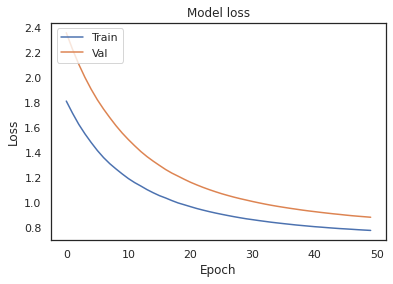

In [ ]:
ensemble_model2 = Ensemble2(dataset.iloc[:-cut_off], active_target, app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)
ensemble_model2.training()

*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(
[ 9.877823   9.6998625  9.073882   9.751673  11.164482  11.461363
 10.588701  10.000244  11.085678   9.559146   9.502803  10.439558
 10.539548   9.389801   9.823355   9.104519  10.34944   10.635526
 10.398473  10.038167   9.62633   10.174932   9.465739  10.125502
  9.64551   11.804191   9.042984  11.234255  10.597398  10.315298
 15.483692  11.703565   9.744472  11.717829  10.703175  11.015594
  9.46506    8.896567  10.187928   8.911419  10.300744   9.0062275
 11.347936   9.626984  10.458669   9.3728    11.040935  11.538963
 12.809489   9.940399  12.74426   11.703172  12.1101675 10.01695
 14.124341  12.043035  10.948636   9.045063  10.3614235  9.408382
  9.065407   8.684215  10.58031    9.539784   9.861216   9.819764
 10.816271  11.430586   9.78892   10.284439   9.64997    8.684413
  9.271512   8.88875    9.384648  10.17293    8.679472   9.44887
  9.591005   8.969784   8.720945   9.899209   9.035228   8.662859
  8.685428   8.762716   8

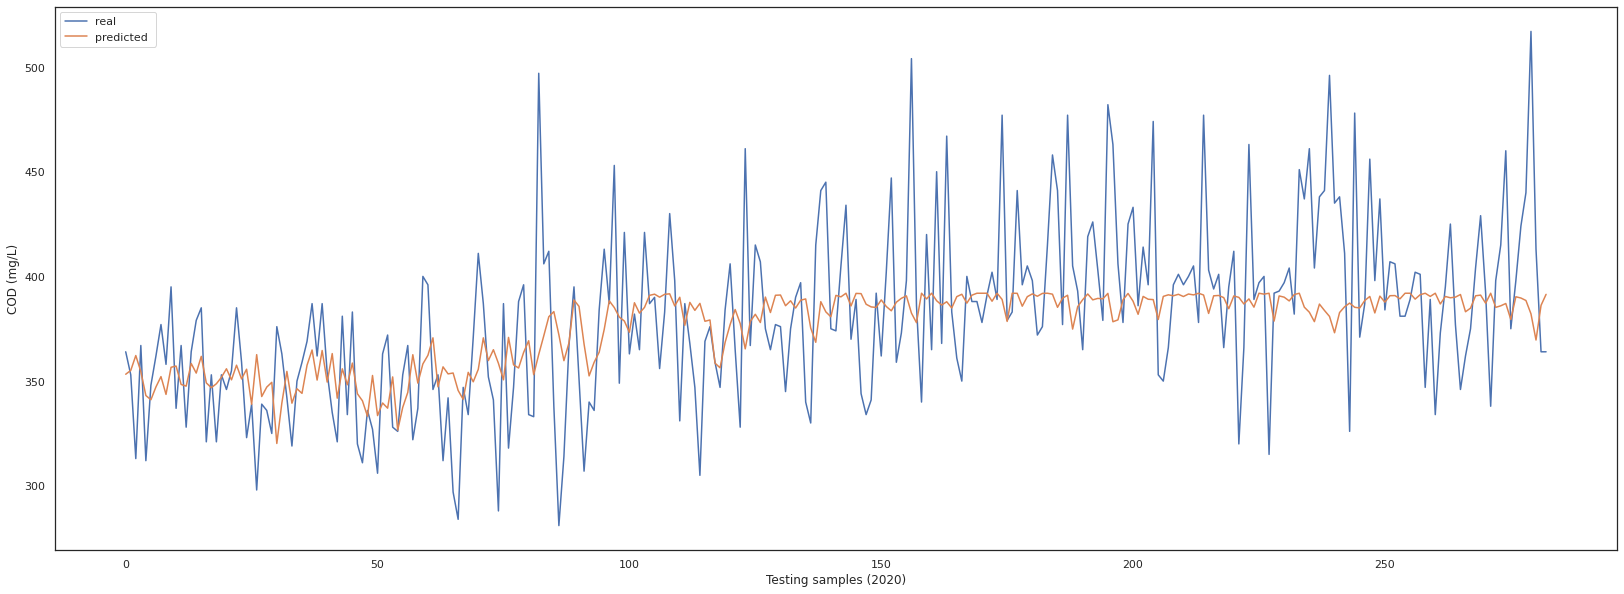

In [ ]:
ensemble_model2.testing(dataset.iloc[:-cut_off], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

### Ensemble 3 - Model Selection

In [ ]:
class Ensemble3:
  def __init__(self, df, goal, model1, model2, model3):
    self.df = df.iloc[-len(model1):]
    self.goal = goal
    self.df = self.df.reset_index(drop=True)

    self.df['model1'] = model1
    self.df['model2'] = model2
    self.df['model3'] = model3
 
    self.df['target'] = self.df[self.goal].shift(-1).fillna(method='ffill')
    self.X = self.df[[self.goal,'model1', 'model2', 'model3']]

    model1 = abs(self.df['model1'] - self.df['target'])
    model2 = abs(self.df['model2'] - self.df['target'])
    model3 = abs(self.df['model3'] - self.df['target'])

    temp = pd.concat([model1, model2, model3], axis=1)
    temp = temp.idxmin(axis=1)  
    self.Y = pd.get_dummies(temp)

    self.x_mean = self.X.mean()
    self.x_std = self.X.std()
  

    self.X_train = (self.X - self.x_mean)/self.x_std
    self.Y_train = self.Y
 
    print(self.Y_train)

  def pearson_corr(self):
    pearson = self.df.corr(method='pearson')
    fig = plt.figure(figsize=(30,10))
    fig.suptitle('Pearson Correlation', fontsize=16)
    sns.heatmap(pearson,vmax=1, cmap="bwr", linewidths=0.1, annot=True)
    plt.show()

  def training(self, neurons = 16, max_epochs = 50):
    self.model = tf.keras.Sequential()
    self.model.add(Dense(neurons/2, activation='relu', input_dim = self.X_train.shape[1]))
    self.model.add(Dense(neurons, activation='relu'))
    self.model.add(Dense(3, activation='softmax'))

    print(self.Y_train.shape)
    print(self.X_train.shape)

    self.model.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history_Ann = self.model.fit(self.X_train, self.Y_train, epochs=max_epochs, verbose=1, validation_split=0.1)
    # Plot training & validation loss values
    plt.plot(history_Ann.history['loss'])
    plt.plot(history_Ann.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    self.model.save('Ensemble.h5')

  def testing(self, df_test, model1, model2, model3):
    self.df_test = df_test.iloc[-len(model1):]
    self.df_test = self.df_test.reset_index(drop=True)
    self.df_test[self.goal] = self.df_test[self.goal].fillna(method='ffill')

    self.df_test['model1'] = model1
    self.df_test['model2'] = model2
    self.df_test['model3'] = model3

    self.df_test['target'] = self.df_test[self.goal].shift(-1).fillna(method='ffill')

    self.Xt = self.df_test[[self.goal,'model1', 'model2', 'model3']]

    model1 = abs(self.df_test['model1'] - self.df_test['target'])
    model2 = abs(self.df_test['model2'] - self.df_test['target'])
    model3 = abs(self.df_test['model3'] - self.df_test['target'])

    temp = pd.concat([model1, model2, model3], axis=1)
    temp = temp.idxmin(axis=1)  
    self.Yt = pd.get_dummies(temp)   

    self.Y_test = self.Yt
    self.X_test = (self.Xt - self.x_mean)/self.x_std
    # print(self.X_test, self.Y_train)

    self.score = self.model.evaluate(self.X_test, self.Y_test)
    self.prediction = self.model.predict(self.X_test)
    
    self.full_prediction = np.zeros(len(self.prediction))
    self.selection = pd.DataFrame(self.prediction).idxmax(axis=1)

    
    for i in range(len(self.prediction)):
      self.full_prediction[i] = self.df_test[f'model{int(self.selection[i])+1}'][i]
    # print(self.full_prediction)

    self.Ys_test = self.df_test['target']
    print('*** ANN Ensemble estimation ***')
    print ('MAPEtf: ',tf.keras.losses.mean_absolute_percentage_error(self.Ys_test, self.full_prediction))
    print ('MAPEsci: ',mean_absolute_error(self.Ys_test, self.full_prediction)*100)
    print ('MAPE: ',mean_absolute_percentage_error(self.Ys_test, self.full_prediction))
    print ('R2: ',r2_score(self.Ys_test, self.full_prediction))
    print ('RMSE: ',mean_squared_error(self.Ys_test, self.full_prediction, squared=False))

    # plot baseline and predictions
    plt.figure(figsize=(28,10))
    plt.plot(self.Ys_test, label = 'real ')
    plt.plot(self.full_prediction, label = 'predicted ')
    plt.ylabel('COD (mg/L)')
    plt.xlabel('Testing samples (2020)')
    plt.legend()
    plt.show()

     0  1  2
0    1  0  0
1    0  1  0
2    0  0  1
3    0  1  0
4    1  0  0
..  .. .. ..
278  0  1  0
279  1  0  0
280  1  0  0
281  0  0  1
282  0  0  1

[283 rows x 3 columns]
(283, 3)
(283, 4)
Epoch 1/50
8/8 [==============================] - 1s 24ms/step - loss: 1.1153 - accuracy: 0.3622 - val_loss: 1.1021 - val_accuracy: 0.4483
Epoch 2/50
8/8 [==============================] - 0s 4ms/step - loss: 1.1044 - accuracy: 0.3740 - val_loss: 1.1015 - val_accuracy: 0.4138
Epoch 3/50
8/8 [==============================] - 0s 4ms/step - loss: 1.0995 - accuracy: 0.4055 - val_loss: 1.1002 - val_accuracy: 0.4138
Epoch 4/50
8/8 [==============================] - 0s 4ms/step - loss: 1.0950 - accuracy: 0.4016 - val_loss: 1.0989 - val_accuracy: 0.4138
Epoch 5/50
8/8 [==============================] - 0s 6ms/step - loss: 1.0928 - accuracy: 0.4173 - val_loss: 1.0988 - val_accuracy: 0.4138
Epoch 6/50
8/8 [==============================] - 0s 4ms/step - loss: 1.0907 - accuracy: 0.4173 - val_loss: 1.0

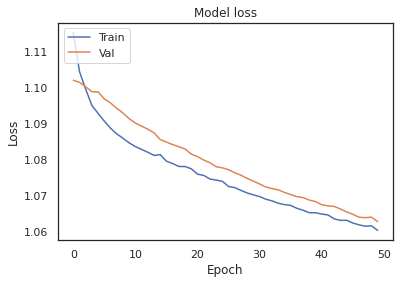

In [ ]:
ensemble_model3 = Ensemble3(dataset.iloc[:-cut_off], active_target, app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)
ensemble_model3.training()

9/9 [==============================] - 0s 1ms/step - loss: 1.0601 - accuracy: 0.4629
*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(7.017490441472028, shape=(), dtype=float64)
MAPEsci:  2684.1716311534997
MAPE:  7.017490441472028
R2:  0.276631246946461
RMSE:  35.9370980811717


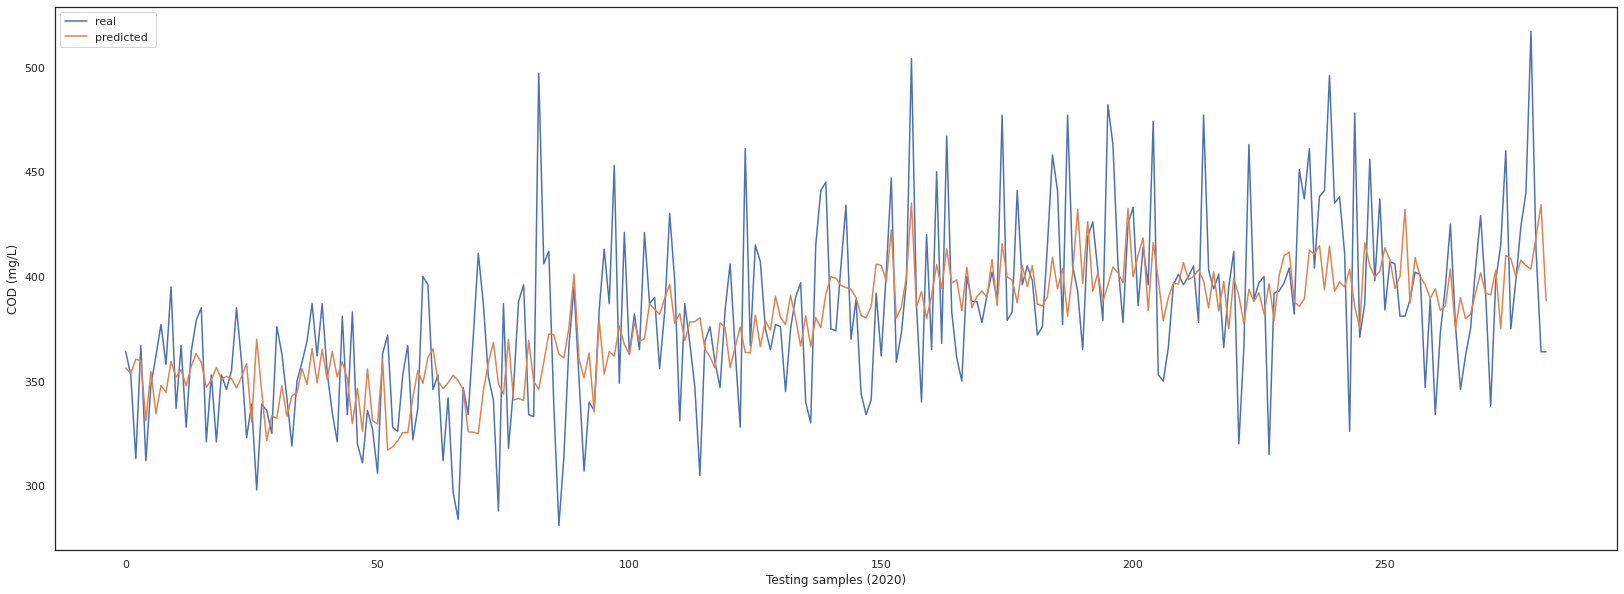

In [ ]:
ensemble_model3.testing(dataset.iloc[:-cut_off], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

In [ ]:
ensemble_model3.selection.to_list().count(1)

170

### Ensemble 4

In [ ]:
class Ensemble4:
  def __init__(self, df, goal, model1, model2, model3):
    self.df = df.iloc[-len(model1):]
    self.goal = goal
    self.df = self.df.reset_index(drop=True)

    self.df['model1'] = model1
    self.df['model2'] = model2
    self.df['model3'] = model3
 
    self.df['target'] = self.df[self.goal].shift(-1).fillna(method='ffill')
    self.X = self.df[['model1', 'model2', 'model3']]

    model1 = abs(self.df['model1'] - self.df['target'])
    model2 = abs(self.df['model2'] - self.df['target'])
    model3 = abs(self.df['model3'] - self.df['target'])

    temp = pd.concat([model1, model2, model3], axis=1)
    temp = temp.idxmin(axis=1)  
    self.Y = pd.get_dummies(temp)

    # self.Y = self.df['target']
    # print(self.X)

    self.x_mean = self.X.mean()
    self.x_std = self.X.std()
    # self.y_mean = self.Y.mean()
    # self.y_std = self.Y.std()
    # print(self.x_mean, self.y_mean)

    self.X_train = (self.X - self.x_mean)/self.x_std
    self.Y_train = self.Y
    # self.Y_train = (self.Y - self.y_mean)/self.y_std
    # print(self.X_test, self.Y_train)
    print(self.Y_train)

  def pearson_corr(self):
    pearson = self.df.corr(method='pearson')
    fig = plt.figure(figsize=(30,10))
    fig.suptitle('Pearson Correlation', fontsize=16)
    sns.heatmap(pearson,vmax=1, cmap="bwr", linewidths=0.1, annot=True)
    plt.show()

  def training(self, neurons = 8, max_epochs = 50):
    from sklearn.svm import SVR
    self.model = SVR(kernel='rbf', C=10, gamma=0.001, epsilon=0.2)
    self.model = self.model.fit(self.X_train.values, self.Y_train.values)
  

  def testing(self, df_test, model1, model2, model3):
    self.df_test = df_test.iloc[-len(model1):]
    self.df_test = self.df_test.reset_index(drop=True)

    self.df_test['model1'] = model1
    self.df_test['model2'] = model2
    self.df_test['model3'] = model3

    self.df_test['target'] = self.df_test[self.goal].shift(-1).fillna(method='ffill')

    self.Xt = self.df_test[[self.goal, 'model1', 'model2', 'model3']]
    self.Y_test = self.df_test['target']
    # print(self.Xt)

    self.X_test = (self.Xt - self.x_mean)/self.x_std
    # print(self.X_test, self.Y_train)

    self.prediction = pd.DataFrame(self.model.predict(self.X_test), columns=['Prediction'])

    self.full_prediction = self.prediction*self.y_std + self.y_mean


    print('*** ANN Ensemble estimation ***')
    print ('MAPEtf: ',tf.keras.losses.mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    print ('MAPEsci: ',mean_absolute_error(self.Y_test.values, self.full_prediction.values)*100)
    print ('MAPE: ',mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    print ('R2: ',r2_score(self.Y_test.values, self.full_prediction))
    print ('RMSE: ',mean_squared_error(self.Y_test.values, self.full_prediction, squared=False))

    # plot baseline and predictions
    plt.figure(figsize=(28,10))
    plt.plot(self.Y_test.values, label = 'real ')
    plt.plot(self.full_prediction.values, label = 'predicted ')
    plt.ylabel('COD (mg/L)')
    plt.xlabel('Testing samples (2020)')
    plt.legend()
    plt.show()

In [ ]:
# ensemble_model4 = Ensemble4(dataset.iloc[:-135], active_target, app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)
# ensemble_model4.training()

## Testing


*** ANN estimation ***
MAPE:  12.11687697163575
R2:  -0.11013164580667212
RMSE:  54.12635570258378


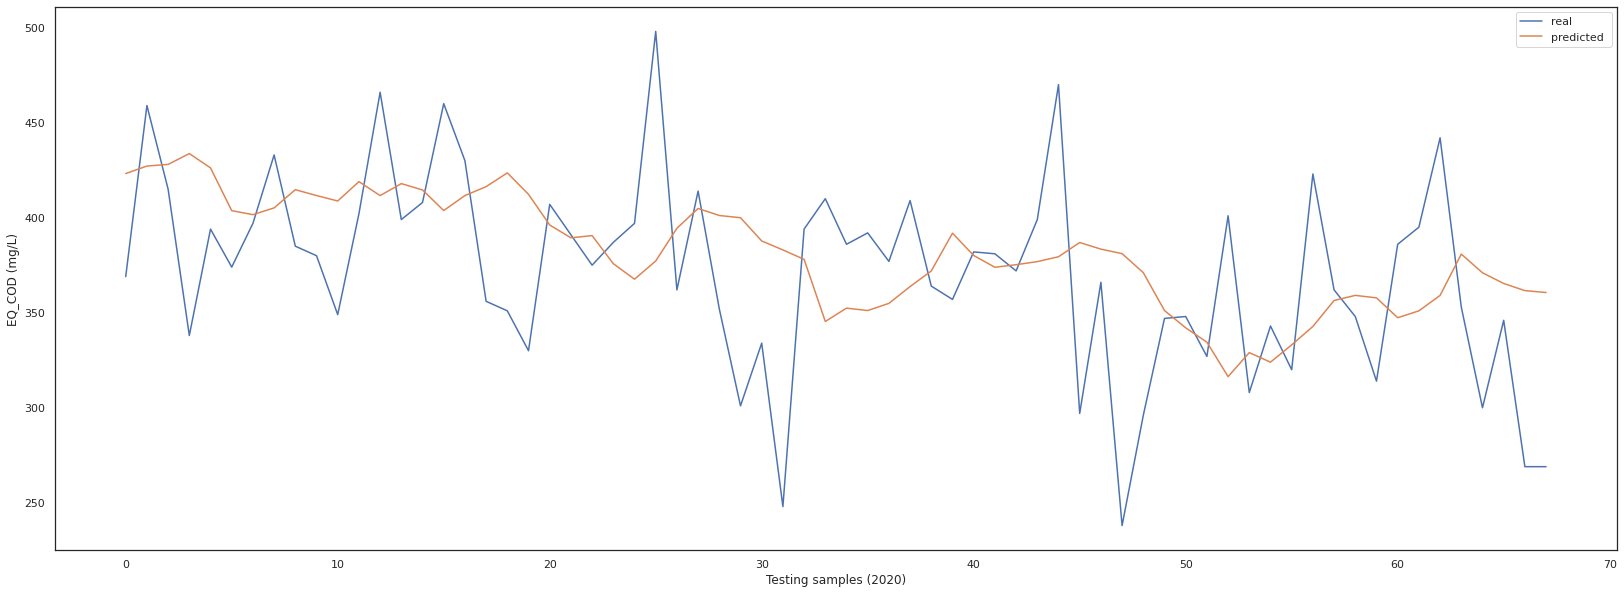

(68,)

In [ ]:
app1.testing(dataset.iloc[-(cut_off + 7):])
app1.full_prediction.shape

*** LSTM estimation ***
MAPE:  11.608751506517184
R2:  0.030472990094846386
RMSE:  50.5826411440774


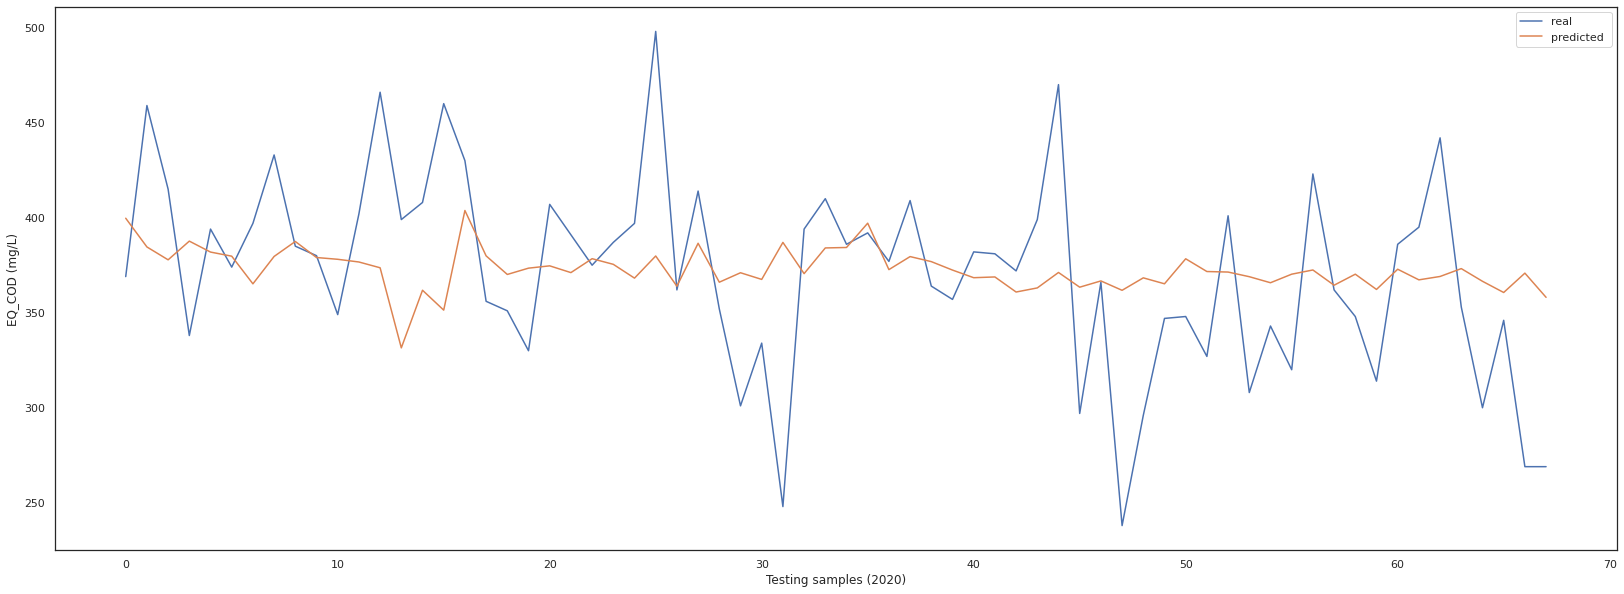

(68, 1)

In [ ]:
app2.testing(dataset.iloc[-(cut_off + 2):])
app2.full_prediction.shape

*** Delta estimation ***
MAPE:  10.902695460642736
R2:  0.08304664998768851
RMSE:  49.192077758524725


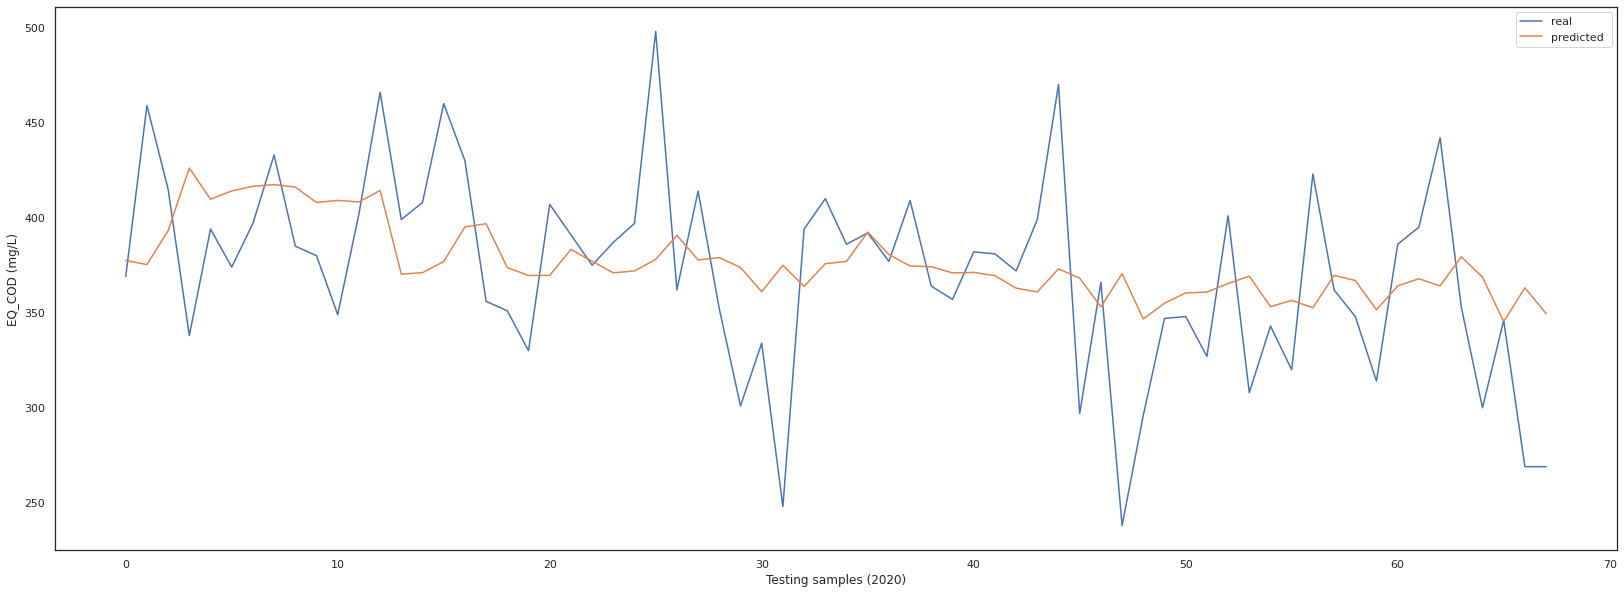

(68,)

In [ ]:
app3.testing(dataset.iloc[-cut_off:])
app3.full_prediction.shape

*** Ensemble estimation ***
MAPE:  10.957005928988728


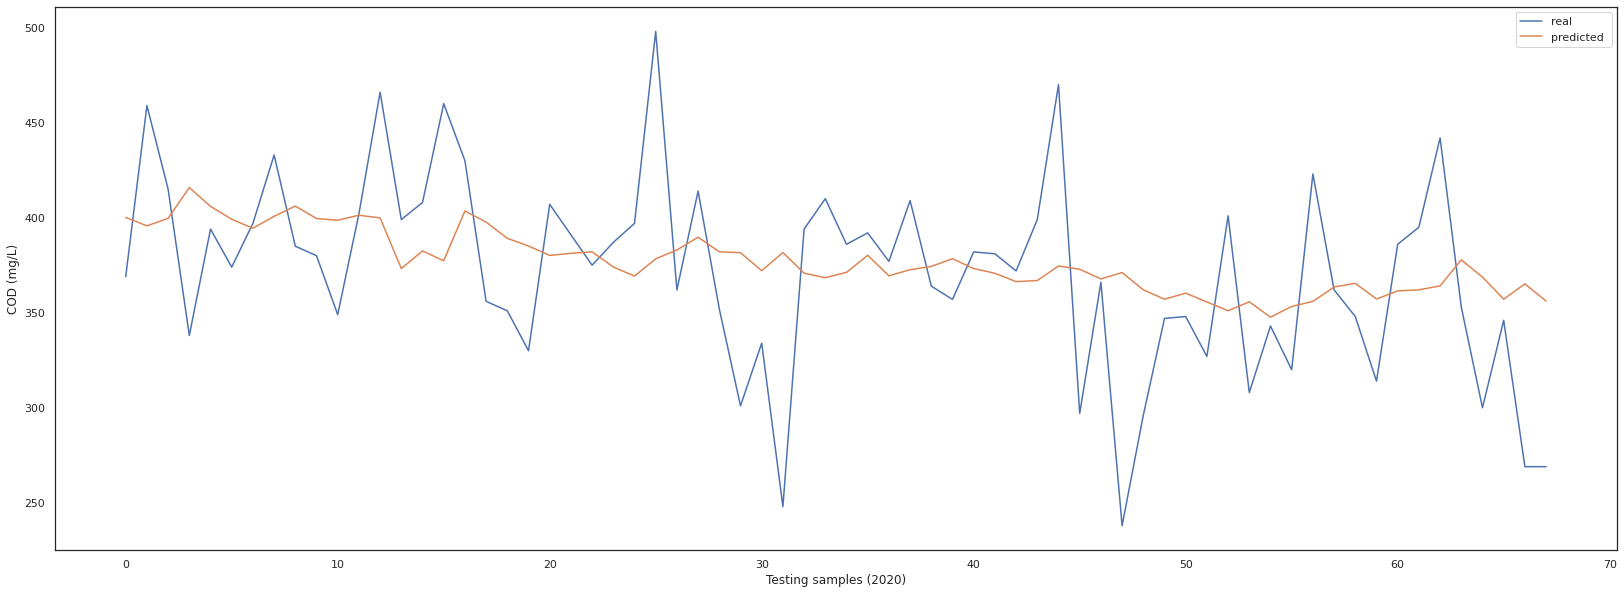

In [ ]:
ensemble = (app1.full_prediction + app2.full_prediction['Prediction'] + app3.full_prediction)/3
print('*** Ensemble estimation ***')
print ('MAPE: ',mean_absolute_percentage_error(app2.Y_test.values, ensemble.values))
#print ('R2: ',r2_score(app2.Y_test.values, ensemble.values))
# plot baseline and predictions
plt.figure(figsize=(28,10))
plt.plot(app2.Y_test.values, label = 'real ')
plt.plot(ensemble.values, label = 'predicted ')
plt.ylabel('COD (mg/L)')
plt.xlabel('Testing samples (2020)')
plt.legend()
plt.show()

*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(
[14.451186  14.4891205 14.950542  16.730858  15.008898  13.554108
 13.119396  13.762036  14.779358  13.778557  13.594431  14.355773
 13.807717  12.85429   12.349322  12.190487  14.625542  13.885296
 13.652098  12.433694  11.644223  11.736898  11.729058  11.341147
 11.341348  11.392409  12.104271  12.735809  12.015832  11.856983
 11.342053  11.622963  11.345683  11.400593  11.3537855 11.403292
 11.339827  11.342264  11.3398    11.521391  11.360041  11.340206
 11.340712  11.342288  11.358385  11.416386  11.381231  11.40353
 11.775592  11.940471  12.023239  12.190538  12.391684  11.8065815
 13.263765  12.616121  12.637351  11.394798  11.487381  11.803794
 11.730411  11.54782   11.531729  11.454393  11.341227  11.800323
 11.537555  11.714196 ], shape=(68,), dtype=float32)
MAPEsci:  3768.332357967601
MAPE:  12.341383608334612
R2:  0.058709319710987806
RMSE:  49.8406187379366


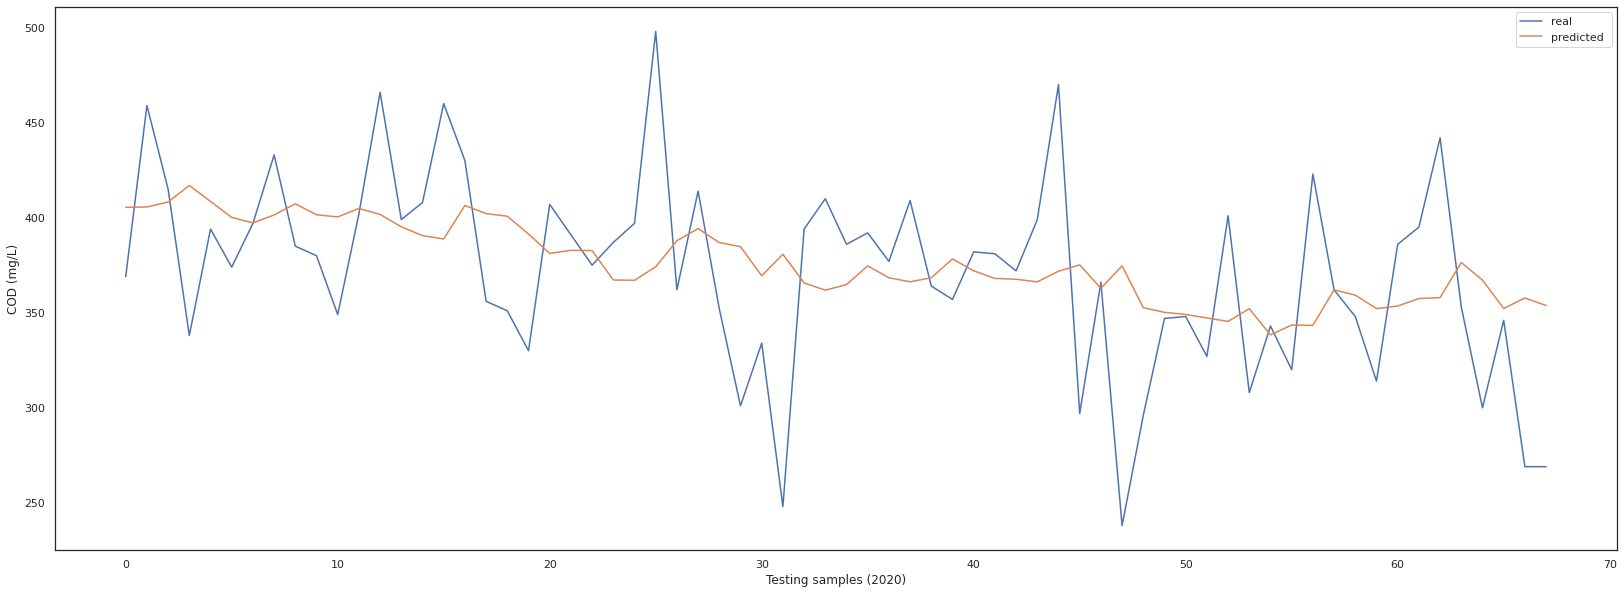

In [ ]:
ensemble_model.testing(dataset.iloc[-142:], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(
[11.68369   12.081083  11.620355  12.487507  12.381976  12.46521
 11.527281  12.49915   12.410957  12.505863  12.359738  12.141773
 12.356604  11.70945   11.47807   11.339169  11.552204  12.091056
 11.909118  11.872387  11.536855  11.823459  12.22164   11.594424
 11.375929  12.068209  11.449498  12.391872  11.62086   11.570543
 11.35425   11.796042  12.000784  11.556465  11.793776  11.860972
 11.38612   11.609812  11.738395  11.608223  11.369226  11.405125
 11.3404045 11.339151  11.600404  11.349543  11.39144   11.339886
 12.53105   12.150695  11.348154  11.536455  12.521283  11.380052
 13.028589  11.63127   11.625796  11.339768  11.339142  11.483674
 11.651849  11.341129  11.356603  11.670094  11.340473  11.802735
 11.340827  13.019771 ], shape=(68,), dtype=float32)
MAPE:  11.785372912629533
R2:  0.10349708435780902
RMSE:  48.64042925324702


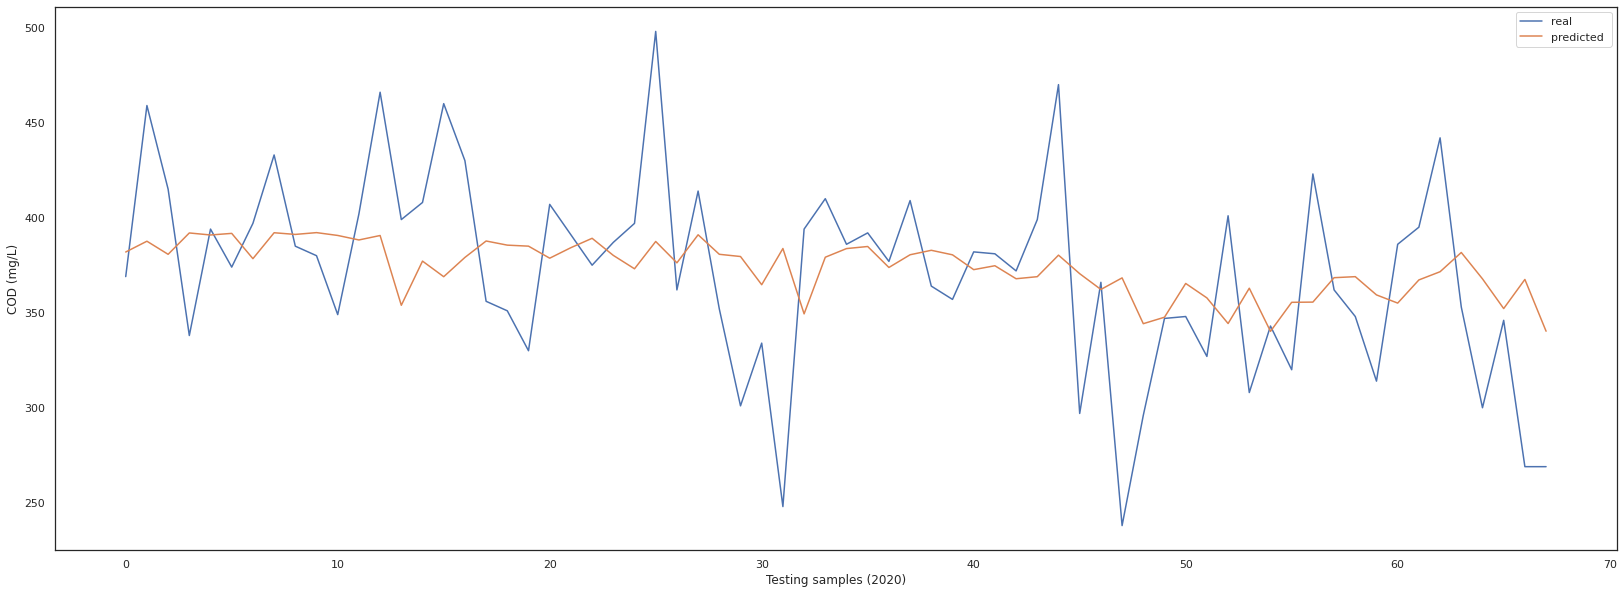

In [ ]:
ensemble_model2.testing(dataset.iloc[-142:], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

3/3 [==============================] - 0s 3ms/step - loss: 1.1309 - accuracy: 0.4265
*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(10.83718796159693, shape=(), dtype=float64)
MAPEsci:  3855.5708023876405
MAPE:  10.83718796159693
R2:  0.014515327350074658
RMSE:  50.997217728061734


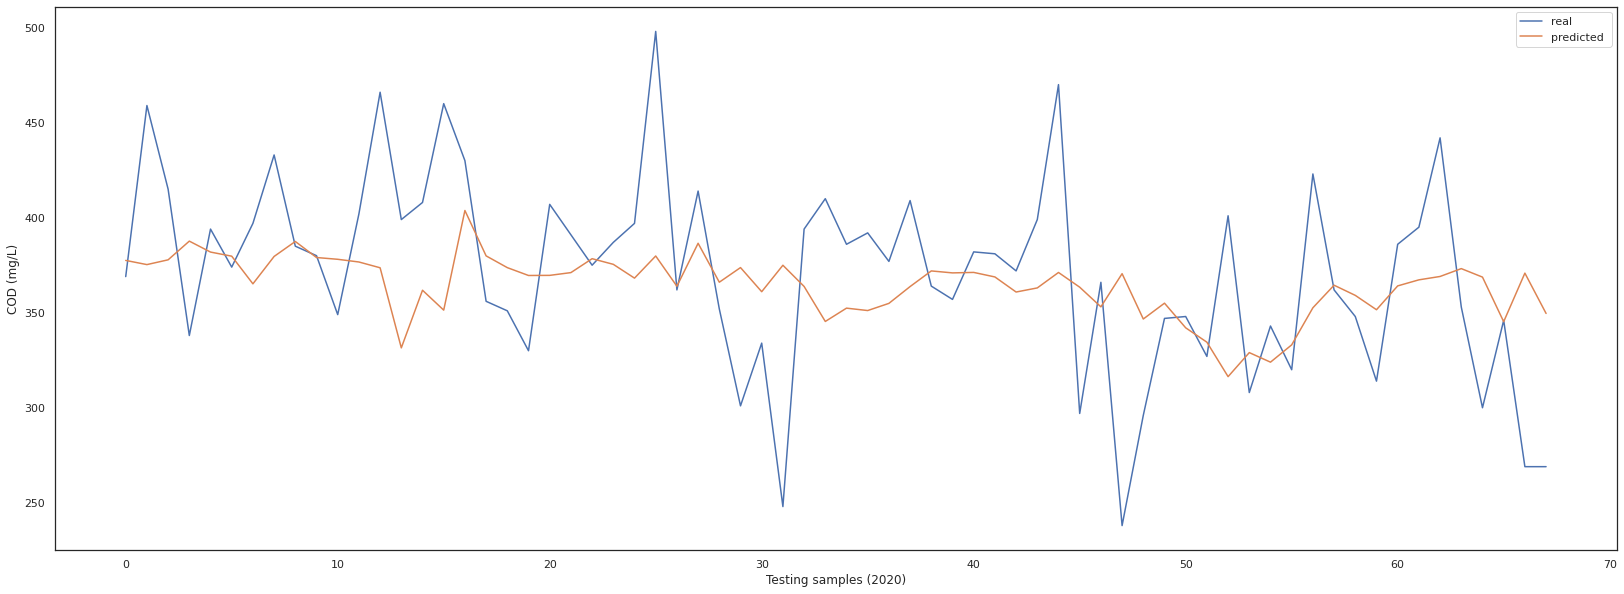

In [ ]:
ensemble_model3.testing(dataset.iloc[-142:], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

In [ ]:
ensemble_model3.selection.to_list().count(3)

0

# D_COD_ON

In [ ]:
active_target = "D_COD_ON"
dataset = dataset2.copy()
dataset.shape
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358 entries, 396 to 753
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        358 non-null    object 
 1   Flow_to_EQ  358 non-null    object 
 2   Flow_efl    358 non-null    float64
 3   BT_C_MLSS   358 non-null    float64
 4   BT_C_MVLSS  358 non-null    float64
 5   BT_N_MLSS   358 non-null    float64
 6   BT_N_MVLSS  358 non-null    float64
 7   D_SS        358 non-null    float64
 8   EQ_N        358 non-null    float64
 9   BT_C_N      358 non-null    float64
 10  BT_N_N      358 non-null    float64
 11  D_N         358 non-null    float64
 12  OxT_PH_PM   358 non-null    float64
 13  EQ_PH       358 non-null    float64
 14  BT_N_PH     358 non-null    float64
 15  D_PH        358 non-null    float64
 16  BT_N_DO     358 non-null    float64
 17  BT_C_DO     358 non-null    float64
 18  Clari_DO    358 non-null    float64
 19  F/M         358 non-null   

## Approach 1

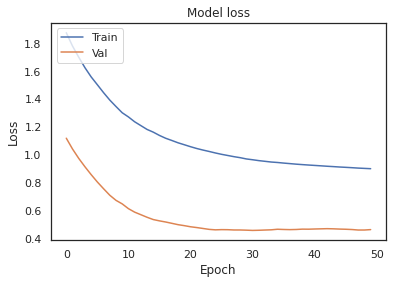

*** ANN estimation ***
MAPE:  15.764672781441297
R2:  0.5149371702306701
RMSE:  21.807708652001008


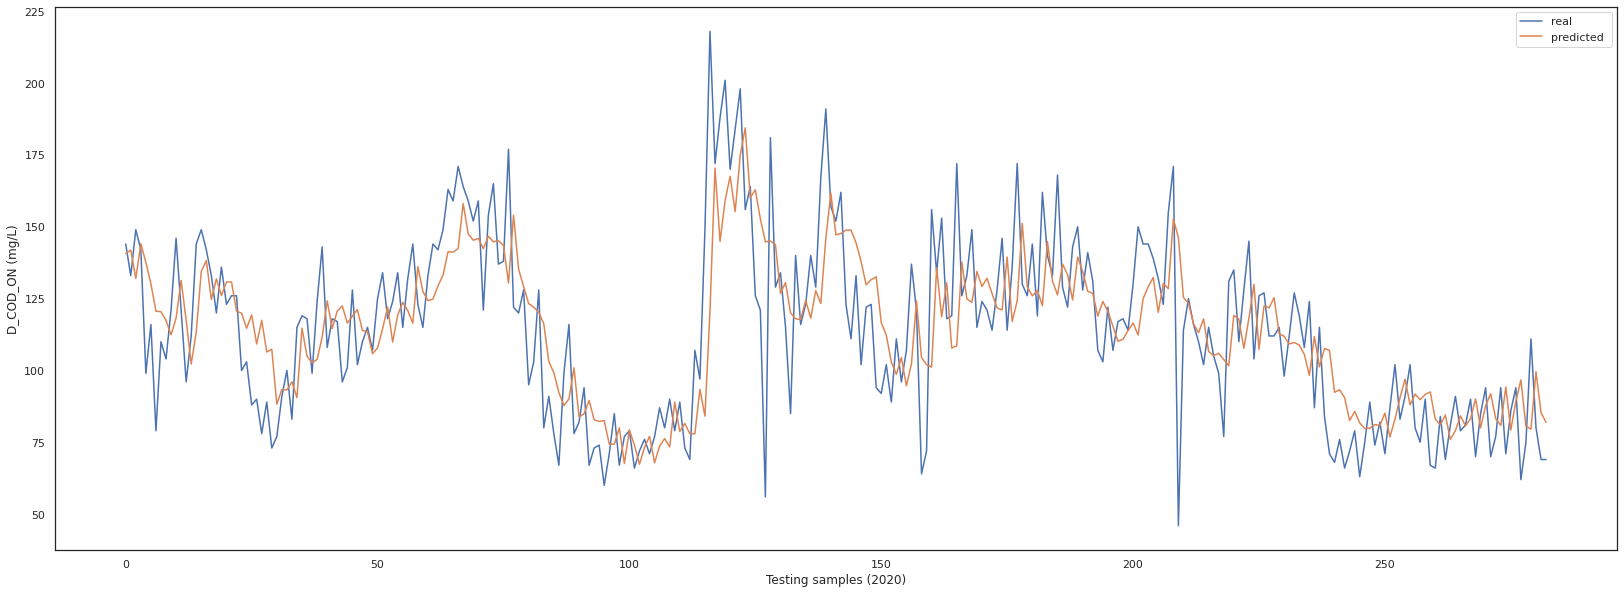

(283,)

In [ ]:
cut_off = 68
app1 = approach1(dataset.iloc[:-cut_off], active_target)
# app1.tune()
# print(app1.best_tuned)
# with open('EQ_COD1.pickle', 'wb') as handle:
#   pickle.dump(app1.best_tuned, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('EQ_COD_tuning_1.pickle', 'wb') as handle:
#   pickle.dump(app1.tune_results, handle, protocol=pickle.HIGHEST_PROTOCOL)
app1.training()
app1.testing(dataset.iloc[:-cut_off])
# app1.testing(dataset.iloc[-142:])
app1.full_prediction.shape

## Approach 2

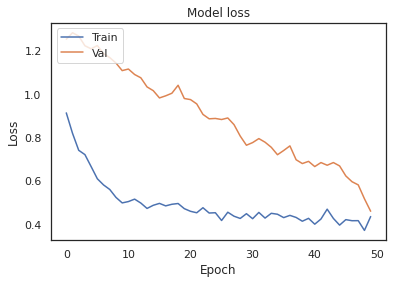

*** LSTM estimation ***
MAPE:  28.99296843920462
R2:  0.6068459692466479
RMSE:  19.633259401804303


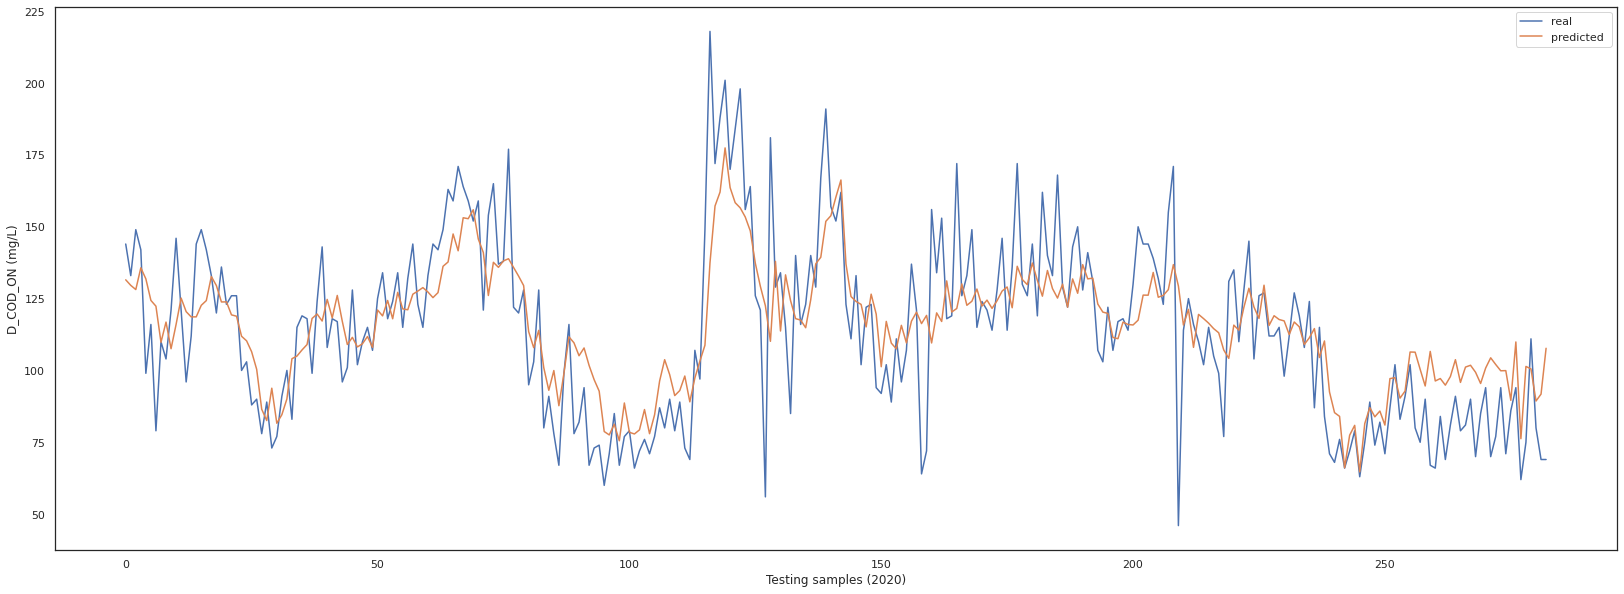

(283, 1)

In [ ]:
app2 = approach2(dataset.iloc[:-cut_off], active_target)
app2.series_to_supervised(n_in=2)
app2.supervised
app2.training()
# app2.testing(dataset.iloc[-137:])
app2.testing(dataset.iloc[5:-cut_off])
app2.full_prediction.shape

## Approach 3

*** Delta estimation ***
MAPE:  15.780568896579267
R2:  0.48690736731514683
RMSE:  22.4289492266545


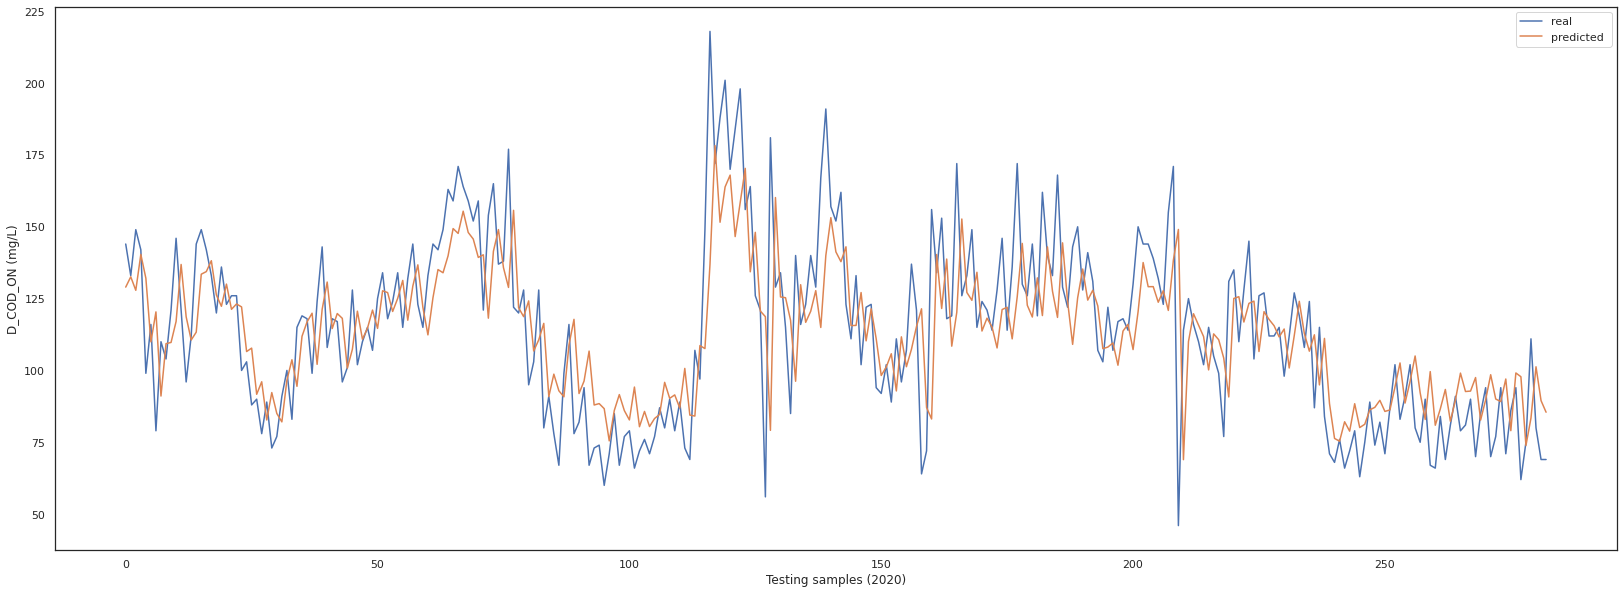

(283,)

In [ ]:
app3 = approach3(dataset.iloc[:-cut_off], active_target)
app3.training()
app3.testing(dataset.iloc[7:-cut_off])
# app3.testing(dataset.iloc[-135:])
app3.full_prediction.shape

## Approaches

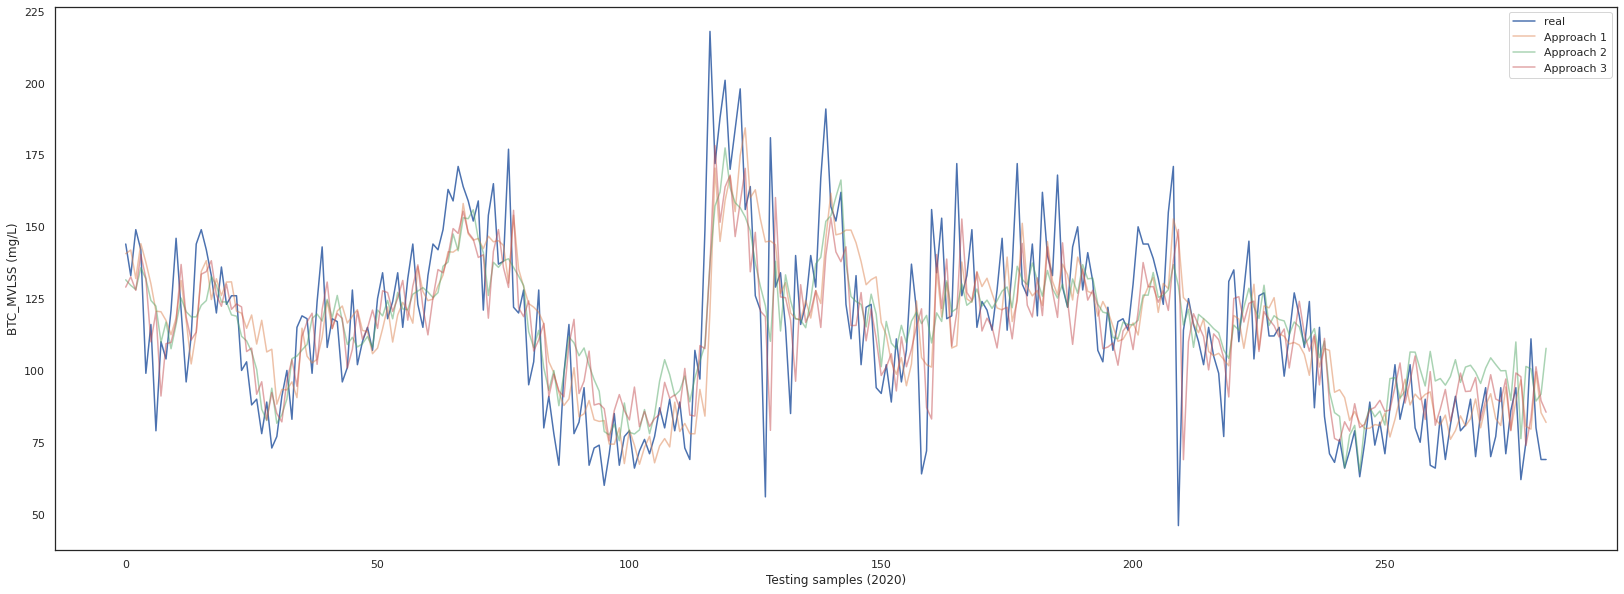

In [ ]:
plt.figure(figsize=(28,10))
plt.plot(app1.Y_test.values, label = 'real ')
plt.plot(app1.full_prediction,'-', alpha= 0.5, label = 'Approach 1')
plt.plot(app2.full_prediction['Prediction'], alpha= 0.5, label = 'Approach 2')
plt.plot(app3.full_prediction, alpha= 0.5, label = 'Approach 3')
plt.ylabel('BTC_MVLSS (mg/L)')
plt.xlabel('Testing samples (2020)')
plt.legend()
plt.show()

## Ensemble

In [ ]:
app1.full_prediction + app2.full_prediction['Prediction'] + app3.full_prediction

0      401.186274
1      404.117159
2      388.040578
3      420.228934
4      401.599792
          ...    
278    255.810044
279    263.546099
280    290.171879
281    266.576733
282    275.073291
Length: 283, dtype: float64

### Ensemble AVG

*** Ensemble estimation ***
MAPE:  15.238269088212828
R2:  0.5349992924500915
RMSE:  21.351964821457077


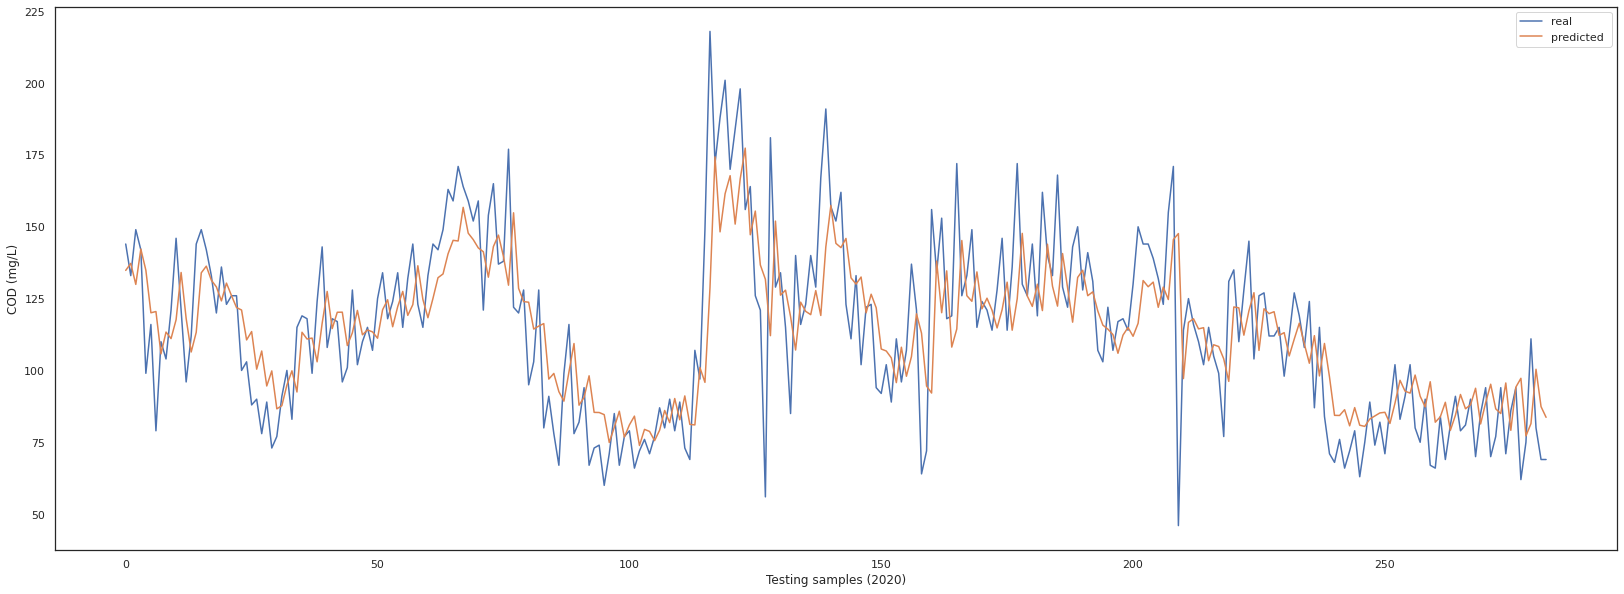

In [ ]:
ensemble = (app1.full_prediction + app3.full_prediction)/2
print('*** Ensemble estimation ***')
print ('MAPE: ',mean_absolute_percentage_error(app2.Y_test.values, ensemble))
print ('R2: ',r2_score(app2.Y_test.values, ensemble))
print ('RMSE: ',mean_squared_error(app2.Y_test.values, ensemble, squared=False))
# plot baseline and predictions
plt.figure(figsize=(28,10))
plt.plot(app2.Y_test.values, label = 'real ')
plt.plot(ensemble.values, label = 'predicted ')
plt.ylabel('COD (mg/L)')
plt.xlabel('Testing samples (2020)')
plt.legend()
plt.show()

*** Ensemble estimation ***
MAPE:  14.567583056426356
R2:  0.5782850594865077
RMSE:  20.33389291700206


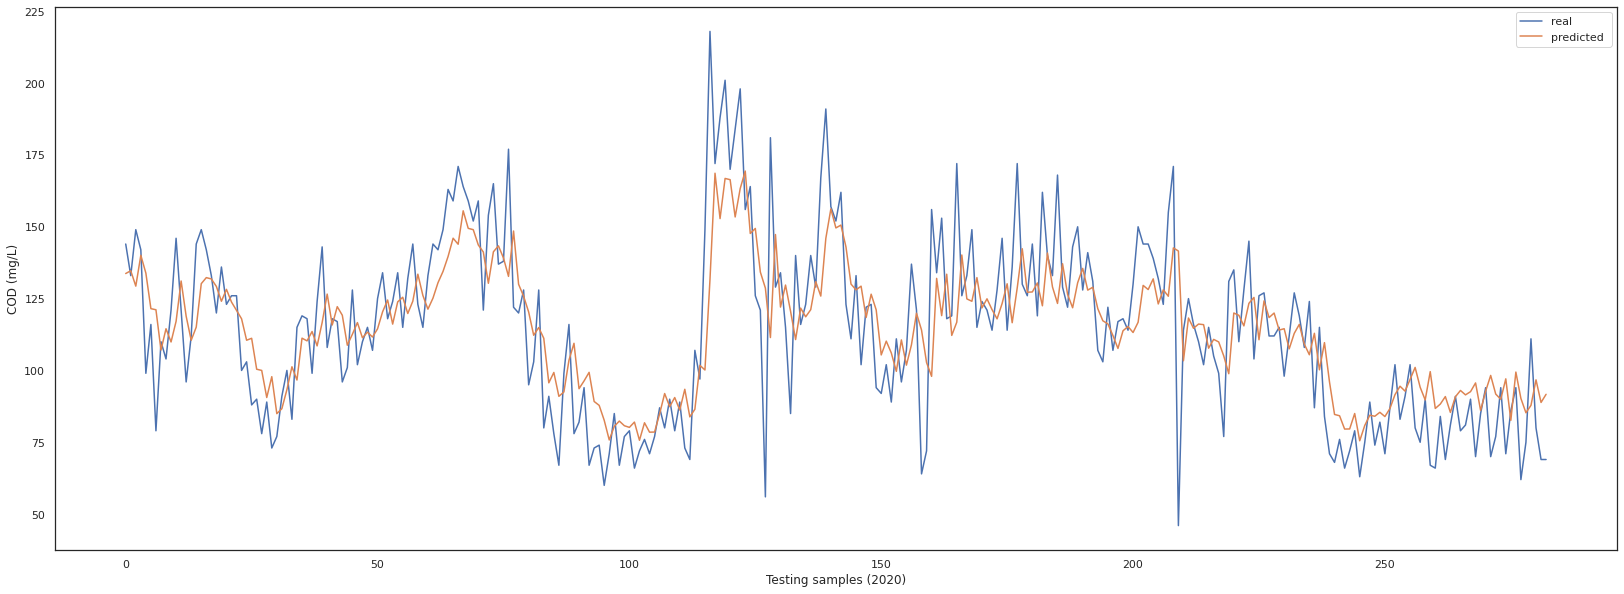

In [ ]:
ensemble = (app1.full_prediction + app2.full_prediction['Prediction'] + app3.full_prediction)/3
print('*** Ensemble estimation ***')
print ('MAPE: ',mean_absolute_percentage_error(app2.Y_test.values, ensemble))
print ('R2: ',r2_score(app2.Y_test.values, ensemble))
print ('RMSE: ',mean_squared_error(app2.Y_test.values, ensemble, squared=False))
# plot baseline and predictions
plt.figure(figsize=(28,10))
plt.plot(app2.Y_test.values, label = 'real ')
plt.plot(ensemble.values, label = 'predicted ')
plt.ylabel('COD (mg/L)')
plt.xlabel('Testing samples (2020)')
plt.legend()
plt.show()

### Ensemble 1 - Model Fusion

In [ ]:
class Ensemble:
  def __init__(self, df, goal, model1, model2, model3):
    self.df = df.iloc[-len(model1):]
    self.goal = goal
    self.df = self.df.reset_index(drop=True)
    
    self.df['model1'] = model1
    self.df['model2'] = model2
    self.df['model3'] = model3

    self.df['target'] = self.df[self.goal].shift(-1).fillna(method='ffill')

    self.X = self.df[['model1', 'model2', 'model3']]
    self.Y = self.df['target'] 
    # print(self.X)

    self.x_mean = self.X.mean()
    self.x_std = self.X.std()
    self.y_mean = self.Y.mean()
    self.y_std = self.Y.std()
    # print(self.x_mean, self.y_mean)  
  
    self.X_train = (self.X - self.x_mean)/self.x_std
    self.Y_train = (self.Y - self.y_mean)/self.y_std
    # print(self.X_test, self.Y_train)
  
  def pearson_corr(self):
    pearson = self.df.corr(method='pearson')
    fig = plt.figure(figsize=(30,10))
    fig.suptitle('Pearson Correlation', fontsize=16)
    sns.heatmap(pearson,vmax=1, cmap="bwr", linewidths=0.1, annot=True)
    plt.show()

  def training(self, neurons = 8, max_epochs = 50):
    self.model = tf.keras.Sequential()
    self.model.add(Dense(neurons, activation='relu', input_dim= self.X_train.shape[1]))
    self.model.add(Dense(1))

    self.model.compile(optimizer= 'adam', loss='mse', metrics=['MAPE'])    
    history_Ann = self.model.fit(self.X_train, self.Y_train, epochs=max_epochs, verbose=1, validation_split=0.1)
    # Plot training & validation loss values
    plt.plot(history_Ann.history['loss'])
    plt.plot(history_Ann.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    self.model.save('Ensemble.h5')
  
  def testing(self, df_test, model1, model2, model3):
    self.df_test = df_test.iloc[-len(model1):]
    self.df_test = self.df_test.reset_index(drop=True)
    
    self.df_test['model1'] = model1
    self.df_test['model2'] = model2
    self.df_test['model3'] = model3

    self.df_test['target'] = self.df_test[self.goal].shift(-1).fillna(method='ffill')

    self.Xt = self.df_test[['model1', 'model2', 'model3']]
    self.Y_test = self.df_test['target'] 
    # print(self.Xt)
  
    self.X_test = (self.Xt - self.x_mean)/self.x_std
    # print(self.X_test, self.Y_train)
    
    self.prediction = pd.DataFrame(self.model.predict(self.X_test), columns=['Prediction'])

    self.full_prediction = self.prediction*self.y_std + self.y_mean
    

    print('*** ANN Ensemble estimation ***')
    print ('MAPEtf: ',tf.keras.losses.mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    print ('MAPEsci: ',mean_absolute_error(self.Y_test.values, self.full_prediction.values)*100)
    print ('MAPE: ',mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    print ('R2: ',r2_score(self.Y_test.values, self.full_prediction))
    print ('RMSE: ',mean_squared_error(self.Y_test.values, self.full_prediction, squared=False))

    # plot baseline and predictions
    plt.figure(figsize=(28,10))
    plt.plot(self.Y_test.values, label = 'real ')
    plt.plot(self.full_prediction.values, label = 'predicted ')
    plt.ylabel('COD (mg/L)')
    plt.xlabel('Testing samples (2020)')
    plt.legend()
    plt.show()

Epoch 1/50
8/8 [==============================] - 0s 20ms/step - loss: 1.3504 - MAPE: 159.7795 - val_loss: 1.7812 - val_MAPE: 139.6934
Epoch 2/50
8/8 [==============================] - 0s 3ms/step - loss: 1.2504 - MAPE: 146.6024 - val_loss: 1.6338 - val_MAPE: 131.5288
Epoch 3/50
8/8 [==============================] - 0s 4ms/step - loss: 1.1627 - MAPE: 140.4644 - val_loss: 1.4948 - val_MAPE: 123.4311
Epoch 4/50
8/8 [==============================] - 0s 4ms/step - loss: 1.0754 - MAPE: 132.6596 - val_loss: 1.3796 - val_MAPE: 116.3233
Epoch 5/50
8/8 [==============================] - 0s 4ms/step - loss: 1.0030 - MAPE: 129.5209 - val_loss: 1.2716 - val_MAPE: 109.3011
Epoch 6/50
8/8 [==============================] - 0s 4ms/step - loss: 0.9348 - MAPE: 130.4409 - val_loss: 1.1703 - val_MAPE: 102.3251
Epoch 7/50
8/8 [==============================] - 0s 4ms/step - loss: 0.8707 - MAPE: 131.3238 - val_loss: 1.0821 - val_MAPE: 95.9199
Epoch 8/50
8/8 [==============================] - 0s 4ms/step 

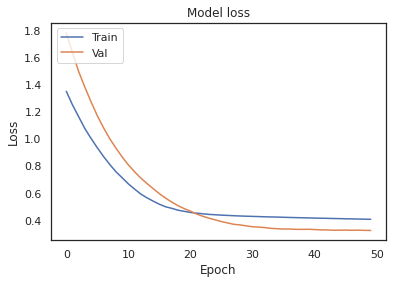

In [ ]:
ensemble_model = Ensemble(dataset.iloc[:-cut_off], active_target, app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)
ensemble_model.training()

*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(
[35.799187 35.6047   33.30523  39.02461  35.804077 31.149574 29.555067
 24.145334 25.629448 24.104122 27.12448  33.00597  28.609097 25.699783
 26.473162 32.268326 33.360115 35.03195  33.630375 30.72646  31.917154
 29.836905 28.810232 26.268557 24.190989 24.09261  25.61483  33.55623
 36.036083 27.61699  32.785038 32.04879  27.313417 24.155075 24.142153
 24.133024 24.652908 26.639414 25.334232 27.512053 31.477642 27.001104
 30.066092 28.193995 24.091547 24.440783 24.79211  24.229162 24.830515
 24.900093 26.378092 28.746466 30.811655 27.415085 31.214321 30.491776
 29.029125 31.098248 34.490067 32.453438 30.044947 31.294426 33.25507
 37.013683 39.36741  44.51799  41.997574 50.673885 47.818573 48.59895
 43.38984  40.90757  34.155186 39.998924 40.152233 39.415558 37.040718
 42.24432  34.85756  32.244347 27.79055  24.147554 25.252745 24.232103
 27.655823 24.83902  28.610662 24.816797 24.92798  25.00613  24.091522
 24.199604 24.09145  25.1053

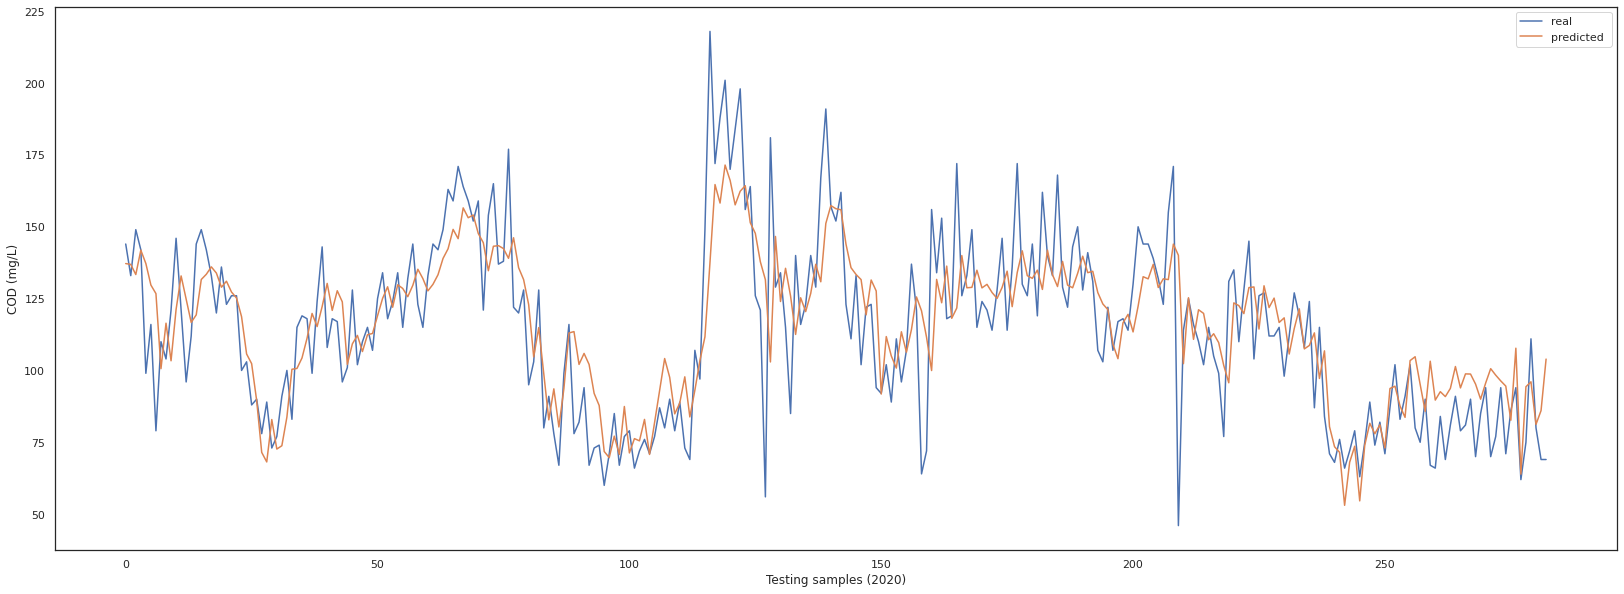

In [ ]:
ensemble_model.testing(dataset.iloc[:-cut_off], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

### Ensemble 2 - Model Fusion + Exo


In [ ]:
class Ensemble2:
  def __init__(self, df, goal, model1, model2, model3):
    self.df = df.iloc[-len(model1):]
    self.goal = goal
    self.df = self.df.reset_index(drop=True)
    
    self.df['model1'] = model1
    self.df['model2'] = model2
    self.df['model3'] = model3

    self.df['target'] = self.df[self.goal].shift(-1).fillna(method='ffill')

    self.X = self.df[[self.goal, 'model1', 'model2', 'model3']]
    self.Y = self.df['target'] 
    # print(self.X)

    self.x_mean = self.X.mean()
    self.x_std = self.X.std()
    self.y_mean = self.Y.mean()
    self.y_std = self.Y.std()
    # print(self.x_mean, self.y_mean)  
  
    self.X_train = (self.X - self.x_mean)/self.x_std
    self.Y_train = (self.Y - self.y_mean)/self.y_std
    # print(self.X_test, self.Y_train)
  
  def pearson_corr(self):
    pearson = self.df.corr(method='pearson')
    fig = plt.figure(figsize=(30,10))
    fig.suptitle('Pearson Correlation', fontsize=16)
    sns.heatmap(pearson,vmax=1, cmap="bwr", linewidths=0.1, annot=True)
    plt.show()

  def training(self, neurons = 8, max_epochs = 50):
    self.model = tf.keras.Sequential()
    self.model.add(Dense(neurons, activation='relu', input_dim= self.X_train.shape[1]))
    self.model.add(Dense(1))

    self.model.compile(optimizer= 'adam', loss='mse', metrics=['MAPE'])    
    history_Ann = self.model.fit(self.X_train, self.Y_train, epochs=max_epochs, verbose=1, validation_split=0.1)
    # Plot training & validation loss values
    plt.plot(history_Ann.history['loss'])
    plt.plot(history_Ann.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    self.model.save('Ensemble.h5')
  
  def testing(self, df_test, model1, model2, model3):
    self.df_test = df_test.iloc[-len(model1):]
    self.df_test = self.df_test.reset_index(drop=True)
    self.df_test[self.goal] = self.df_test[self.goal].fillna(method='ffill')
    
    self.df_test['model1'] = model1
    self.df_test['model2'] = model2
    self.df_test['model3'] = model3

    self.df_test['target'] = self.df_test[self.goal].shift(-1).fillna(method='ffill')

    self.Xt = self.df_test[[self.goal, 'model1', 'model2', 'model3']]
    self.Y_test = self.df_test['target'] 
    # print(self.Xt)
  
    self.X_test = (self.Xt - self.x_mean)/self.x_std
    # print(self.X_test, self.Y_train)
    
    self.prediction = pd.DataFrame(self.model.predict(self.X_test), columns=['Prediction'])

    self.full_prediction = self.prediction*self.y_std + self.y_mean
    

    print('*** ANN Ensemble estimation ***')
    print ('MAPEtf: ',tf.keras.losses.mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    # print ('MAPEsci: ',mean_absolute_error(self.Y_test.values, self.full_prediction.values)*100)
    print ('MAPE: ',mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    print ('R2: ',r2_score(self.Y_test.values, self.full_prediction))
    print ('RMSE: ',mean_squared_error(self.Y_test.values, self.full_prediction, squared=False))

    # plot baseline and predictions
    plt.figure(figsize=(28,10))
    plt.plot(self.Y_test.values, label = 'real ')
    plt.plot(self.full_prediction.values, label = 'predicted ')
    plt.ylabel('COD (mg/L)')
    plt.xlabel('Testing samples (2020)')
    plt.legend()
    plt.show()

Epoch 1/50
8/8 [==============================] - 1s 26ms/step - loss: 3.9071 - MAPE: 405.9400 - val_loss: 3.9856 - val_MAPE: 237.5388
Epoch 2/50
8/8 [==============================] - 0s 4ms/step - loss: 3.5980 - MAPE: 377.5129 - val_loss: 3.6763 - val_MAPE: 226.0307
Epoch 3/50
8/8 [==============================] - 0s 4ms/step - loss: 3.3226 - MAPE: 361.8347 - val_loss: 3.3824 - val_MAPE: 214.6201
Epoch 4/50
8/8 [==============================] - 0s 4ms/step - loss: 3.0594 - MAPE: 338.6479 - val_loss: 3.1185 - val_MAPE: 203.8112
Epoch 5/50
8/8 [==============================] - 0s 3ms/step - loss: 2.8335 - MAPE: 318.0099 - val_loss: 2.8694 - val_MAPE: 193.0510
Epoch 6/50
8/8 [==============================] - 0s 4ms/step - loss: 2.6270 - MAPE: 296.6722 - val_loss: 2.6355 - val_MAPE: 182.3241
Epoch 7/50
8/8 [==============================] - 0s 3ms/step - loss: 2.4324 - MAPE: 283.6176 - val_loss: 2.4278 - val_MAPE: 172.3294
Epoch 8/50
8/8 [==============================] - 0s 4ms/step

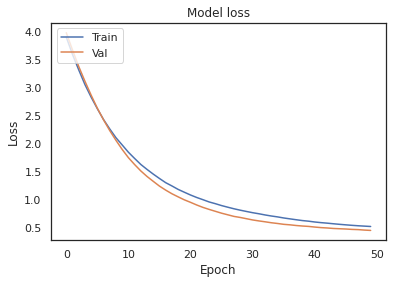

In [ ]:
ensemble_model2 = Ensemble2(dataset.iloc[:-cut_off], active_target, app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)
ensemble_model2.training()

*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(
[28.880968 32.46162  29.987993 34.3841   31.870825 25.568924 27.360943
 24.429691 25.131592 24.214342 27.165058 34.402077 27.908684 26.841223
 26.3904   34.3534   35.248787 32.428528 29.488256 27.559189 31.773281
 27.56681  29.608902 28.744009 24.186628 24.092499 25.105894 28.979788
 34.48479  26.616728 31.073553 30.259827 25.514656 24.159924 24.151787
 24.63382  26.234734 27.36097  25.955729 28.895676 32.25911  25.947332
 27.759773 26.096138 24.098831 24.183762 27.906668 24.239544 24.841682
 26.193726 28.066895 29.860071 31.001053 28.238348 28.659678 31.994646
 27.029568 30.079884 34.216328 27.767578 28.094234 30.284891 33.51677
 31.959364 34.14014  36.80656  37.15136  39.851727 36.933537 33.670315
 33.063164 35.88866  26.313549 35.52437  38.911594 30.316153 29.546448
 42.695133 27.871859 27.857483 29.88349  24.229118 24.390505 25.957426
 26.998875 24.382193 27.594894 24.518112 25.248268 26.08108  24.156078
 24.421303 24.092985 24.63

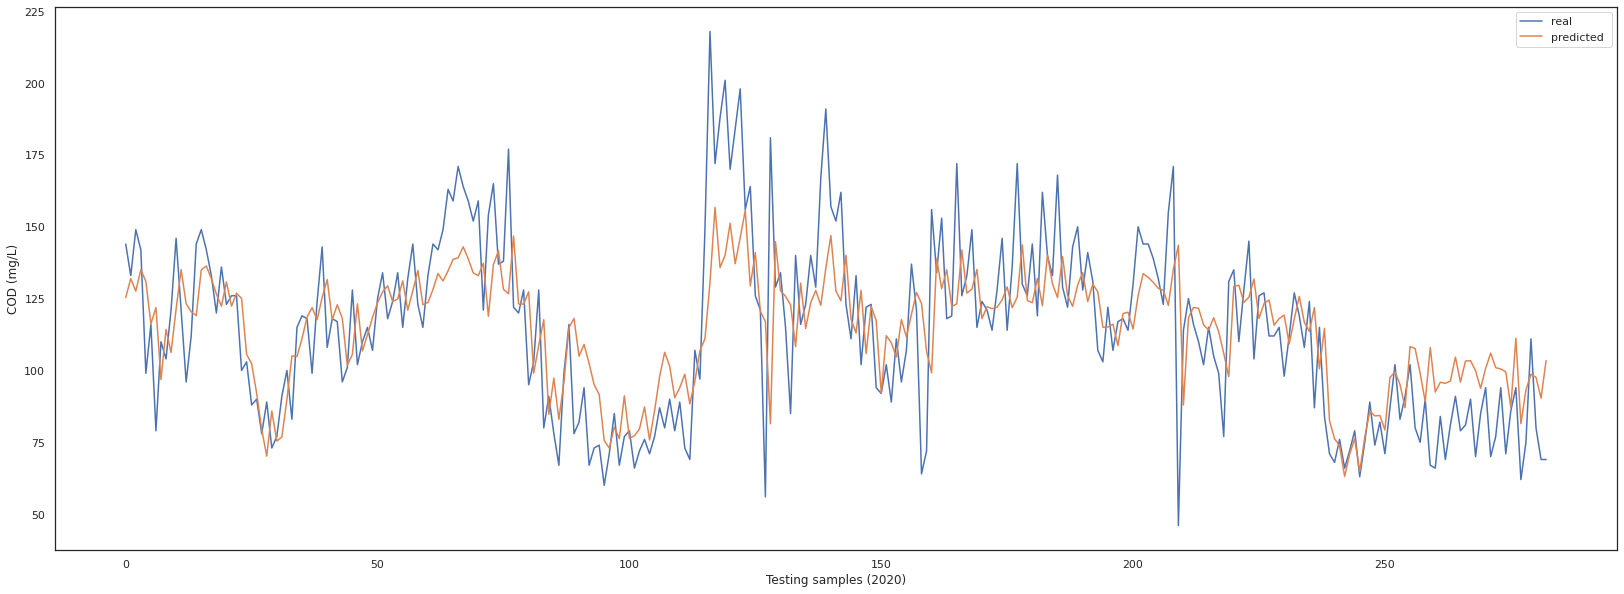

In [ ]:
ensemble_model2.testing(dataset.iloc[:-cut_off], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

### Ensemble 3 - Model Selection

In [ ]:
class Ensemble3:
  def __init__(self, df, goal, model1, model2, model3):
    self.df = df.iloc[-len(model1):]
    self.goal = goal
    self.df = self.df.reset_index(drop=True)

    self.df['model1'] = model1
    self.df['model2'] = model2
    self.df['model3'] = model3
 
    self.df['target'] = self.df[self.goal].shift(-1).fillna(method='ffill')
    self.X = self.df[[self.goal,'model1', 'model2', 'model3']]

    model1 = abs(self.df['model1'] - self.df['target'])
    model2 = abs(self.df['model2'] - self.df['target'])
    model3 = abs(self.df['model3'] - self.df['target'])

    temp = pd.concat([model1, model2, model3], axis=1)
    temp = temp.idxmin(axis=1)  
    self.Y = pd.get_dummies(temp)

    self.x_mean = self.X.mean()
    self.x_std = self.X.std()
  

    self.X_train = (self.X - self.x_mean)/self.x_std
    self.Y_train = self.Y
 
    print(self.Y_train)

  def pearson_corr(self):
    pearson = self.df.corr(method='pearson')
    fig = plt.figure(figsize=(30,10))
    fig.suptitle('Pearson Correlation', fontsize=16)
    sns.heatmap(pearson,vmax=1, cmap="bwr", linewidths=0.1, annot=True)
    plt.show()

  def training(self, neurons = 16, max_epochs = 50):
    self.model = tf.keras.Sequential()
    self.model.add(Dense(neurons/2, activation='relu', input_dim = self.X_train.shape[1]))
    self.model.add(Dense(neurons, activation='relu'))
    self.model.add(Dense(3, activation='softmax'))

    print(self.Y_train.shape)
    print(self.X_train.shape)

    self.model.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history_Ann = self.model.fit(self.X_train, self.Y_train, epochs=max_epochs, verbose=1, validation_split=0.1)
    # Plot training & validation loss values
    plt.plot(history_Ann.history['loss'])
    plt.plot(history_Ann.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    self.model.save('Ensemble.h5')

  def testing(self, df_test, model1, model2, model3):
    self.df_test = df_test.iloc[-len(model1):]
    self.df_test = self.df_test.reset_index(drop=True)
    self.df_test[self.goal] = self.df_test[self.goal].fillna(method='ffill')

    self.df_test['model1'] = model1
    self.df_test['model2'] = model2
    self.df_test['model3'] = model3

    self.df_test['target'] = self.df_test[self.goal].shift(-1).fillna(method='ffill')

    self.Xt = self.df_test[[self.goal,'model1', 'model2', 'model3']]

    model1 = abs(self.df_test['model1'] - self.df_test['target'])
    model2 = abs(self.df_test['model2'] - self.df_test['target'])
    model3 = abs(self.df_test['model3'] - self.df_test['target'])

    temp = pd.concat([model1, model2, model3], axis=1)
    temp = temp.idxmin(axis=1)  
    self.Yt = pd.get_dummies(temp)   

    self.Y_test = self.Yt
    self.X_test = (self.Xt - self.x_mean)/self.x_std
    # print(self.X_test, self.Y_train)

    self.score = self.model.evaluate(self.X_test, self.Y_test)
    self.prediction = self.model.predict(self.X_test)
    
    self.full_prediction = np.zeros(len(self.prediction))
    self.selection = pd.DataFrame(self.prediction).idxmax(axis=1)

    
    for i in range(len(self.prediction)):
      self.full_prediction[i] = self.df_test[f'model{int(self.selection[i])+1}'][i]
    # print(self.full_prediction)

    self.Ys_test = self.df_test['target']
    print('*** ANN Ensemble estimation ***')
    print ('MAPEtf: ',tf.keras.losses.mean_absolute_percentage_error(self.Ys_test, self.full_prediction))
    print ('MAPEsci: ',mean_absolute_error(self.Ys_test, self.full_prediction)*100)
    print ('MAPE: ',mean_absolute_percentage_error(self.Ys_test, self.full_prediction))
    print ('R2: ',r2_score(self.Ys_test, self.full_prediction))
    print ('RMSE: ',mean_squared_error(self.Ys_test, self.full_prediction, squared=False))

    # plot baseline and predictions
    plt.figure(figsize=(28,10))
    plt.plot(self.Ys_test, label = 'real ')
    plt.plot(self.full_prediction, label = 'predicted ')
    plt.ylabel('COD (mg/L)')
    plt.xlabel('Testing samples (2020)')
    plt.legend()
    plt.show()

     0  1  2
0    1  0  0
1    0  0  1
2    1  0  0
3    0  0  1
4    0  1  0
..  .. .. ..
278  0  0  1
279  0  1  0
280  0  1  0
281  1  0  0
282  1  0  0

[283 rows x 3 columns]
(283, 3)
(283, 4)
Epoch 1/50
8/8 [==============================] - 1s 23ms/step - loss: 1.3172 - accuracy: 0.2717 - val_loss: 1.2219 - val_accuracy: 0.2759
Epoch 2/50
8/8 [==============================] - 0s 4ms/step - loss: 1.2592 - accuracy: 0.2835 - val_loss: 1.2048 - val_accuracy: 0.1379
Epoch 3/50
8/8 [==============================] - 0s 4ms/step - loss: 1.2136 - accuracy: 0.3031 - val_loss: 1.1902 - val_accuracy: 0.1379
Epoch 4/50
8/8 [==============================] - 0s 4ms/step - loss: 1.1783 - accuracy: 0.3307 - val_loss: 1.1816 - val_accuracy: 0.1724
Epoch 5/50
8/8 [==============================] - 0s 4ms/step - loss: 1.1527 - accuracy: 0.3071 - val_loss: 1.1750 - val_accuracy: 0.2069
Epoch 6/50
8/8 [==============================] - 0s 3ms/step - loss: 1.1334 - accuracy: 0.3307 - val_loss: 1.1

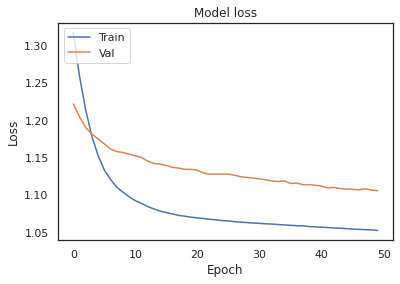

In [ ]:
ensemble_model3 = Ensemble3(dataset.iloc[:-cut_off], active_target, app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)
ensemble_model3.training()

9/9 [==============================] - 0s 3ms/step - loss: 1.0575 - accuracy: 0.4240
*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(14.556604810303803, shape=(), dtype=float64)
MAPEsci:  1471.2542039059676
MAPE:  14.556604810303794
R2:  0.6027248922288881
RMSE:  19.73588998017911


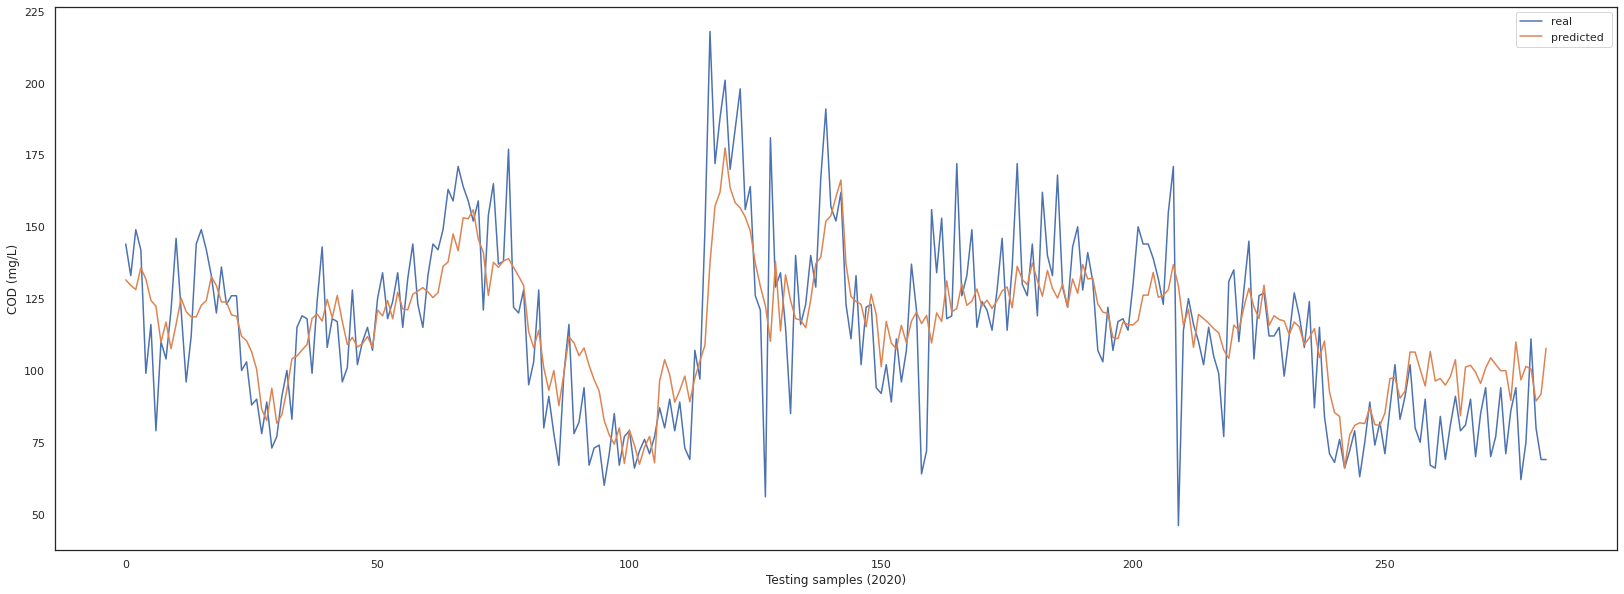

In [ ]:
ensemble_model3.testing(dataset.iloc[:-cut_off], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

In [ ]:
ensemble_model3.selection.to_list().count(1)

265

### Ensemble 4

In [ ]:
class Ensemble4:
  def __init__(self, df, goal, model1, model2, model3):
    self.df = df.iloc[-len(model1):]
    self.goal = goal
    self.df = self.df.reset_index(drop=True)

    self.df['model1'] = model1
    self.df['model2'] = model2
    self.df['model3'] = model3
 
    self.df['target'] = self.df[self.goal].shift(-1).fillna(method='ffill')
    self.X = self.df[['model1', 'model2', 'model3']]

    model1 = abs(self.df['model1'] - self.df['target'])
    model2 = abs(self.df['model2'] - self.df['target'])
    model3 = abs(self.df['model3'] - self.df['target'])

    temp = pd.concat([model1, model2, model3], axis=1)
    temp = temp.idxmin(axis=1)  
    self.Y = pd.get_dummies(temp)

    # self.Y = self.df['target']
    # print(self.X)

    self.x_mean = self.X.mean()
    self.x_std = self.X.std()
    # self.y_mean = self.Y.mean()
    # self.y_std = self.Y.std()
    # print(self.x_mean, self.y_mean)

    self.X_train = (self.X - self.x_mean)/self.x_std
    self.Y_train = self.Y
    # self.Y_train = (self.Y - self.y_mean)/self.y_std
    # print(self.X_test, self.Y_train)
    print(self.Y_train)

  def pearson_corr(self):
    pearson = self.df.corr(method='pearson')
    fig = plt.figure(figsize=(30,10))
    fig.suptitle('Pearson Correlation', fontsize=16)
    sns.heatmap(pearson,vmax=1, cmap="bwr", linewidths=0.1, annot=True)
    plt.show()

  def training(self, neurons = 8, max_epochs = 50):
    from sklearn.svm import SVR
    self.model = SVR(kernel='rbf', C=10, gamma=0.001, epsilon=0.2)
    self.model = self.model.fit(self.X_train.values, self.Y_train.values)
  

  def testing(self, df_test, model1, model2, model3):
    self.df_test = df_test.iloc[-len(model1):]
    self.df_test = self.df_test.reset_index(drop=True)

    self.df_test['model1'] = model1
    self.df_test['model2'] = model2
    self.df_test['model3'] = model3

    self.df_test['target'] = self.df_test[self.goal].shift(-1).fillna(method='ffill')

    self.Xt = self.df_test[[self.goal, 'model1', 'model2', 'model3']]
    self.Y_test = self.df_test['target']
    # print(self.Xt)

    self.X_test = (self.Xt - self.x_mean)/self.x_std
    # print(self.X_test, self.Y_train)

    self.prediction = pd.DataFrame(self.model.predict(self.X_test), columns=['Prediction'])

    self.full_prediction = self.prediction*self.y_std + self.y_mean


    print('*** ANN Ensemble estimation ***')
    print ('MAPEtf: ',tf.keras.losses.mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    print ('MAPEsci: ',mean_absolute_error(self.Y_test.values, self.full_prediction.values)*100)
    print ('MAPE: ',mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    print ('R2: ',r2_score(self.Y_test.values, self.full_prediction))
    print ('RMSE: ',mean_squared_error(self.Y_test.values, self.full_prediction, squared=False))

    # plot baseline and predictions
    plt.figure(figsize=(28,10))
    plt.plot(self.Y_test.values, label = 'real ')
    plt.plot(self.full_prediction.values, label = 'predicted ')
    plt.ylabel('COD (mg/L)')
    plt.xlabel('Testing samples (2020)')
    plt.legend()
    plt.show()

In [ ]:
# ensemble_model4 = Ensemble4(dataset.iloc[:-135], active_target, app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)
# ensemble_model4.training()

## Testing


*** ANN estimation ***
MAPE:  18.66375184463799
R2:  -0.01379940844295624
RMSE:  19.49089016421496


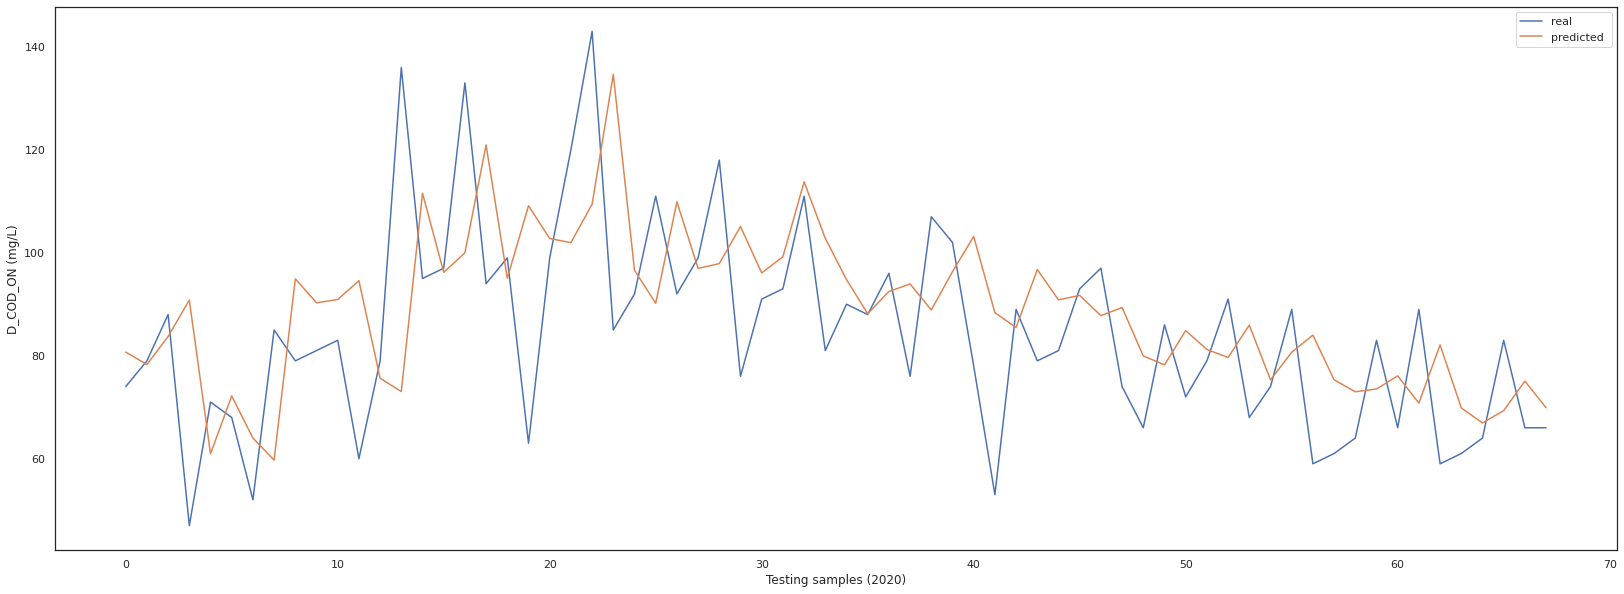

(68,)

In [ ]:
app1.testing(dataset.iloc[-(cut_off + 7):])
app1.full_prediction.shape

*** LSTM estimation ***
MAPE:  37.40841617776324
R2:  -2.2764348203676734
RMSE:  35.03938087032843


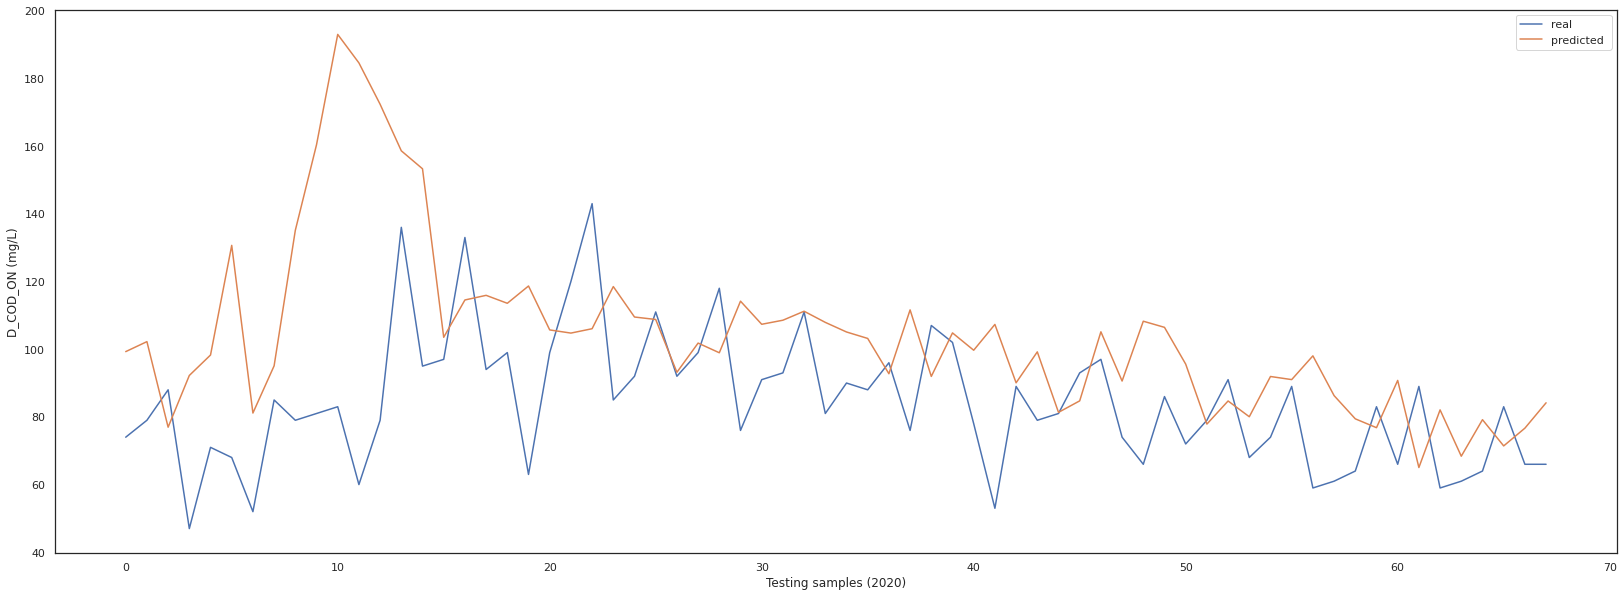

(68, 1)

In [ ]:
app2.testing(dataset.iloc[-(cut_off + 2):])
app2.full_prediction.shape

*** Delta estimation ***
MAPE:  23.487597292526978
R2:  -0.35400800454488435
RMSE:  22.525076431953796


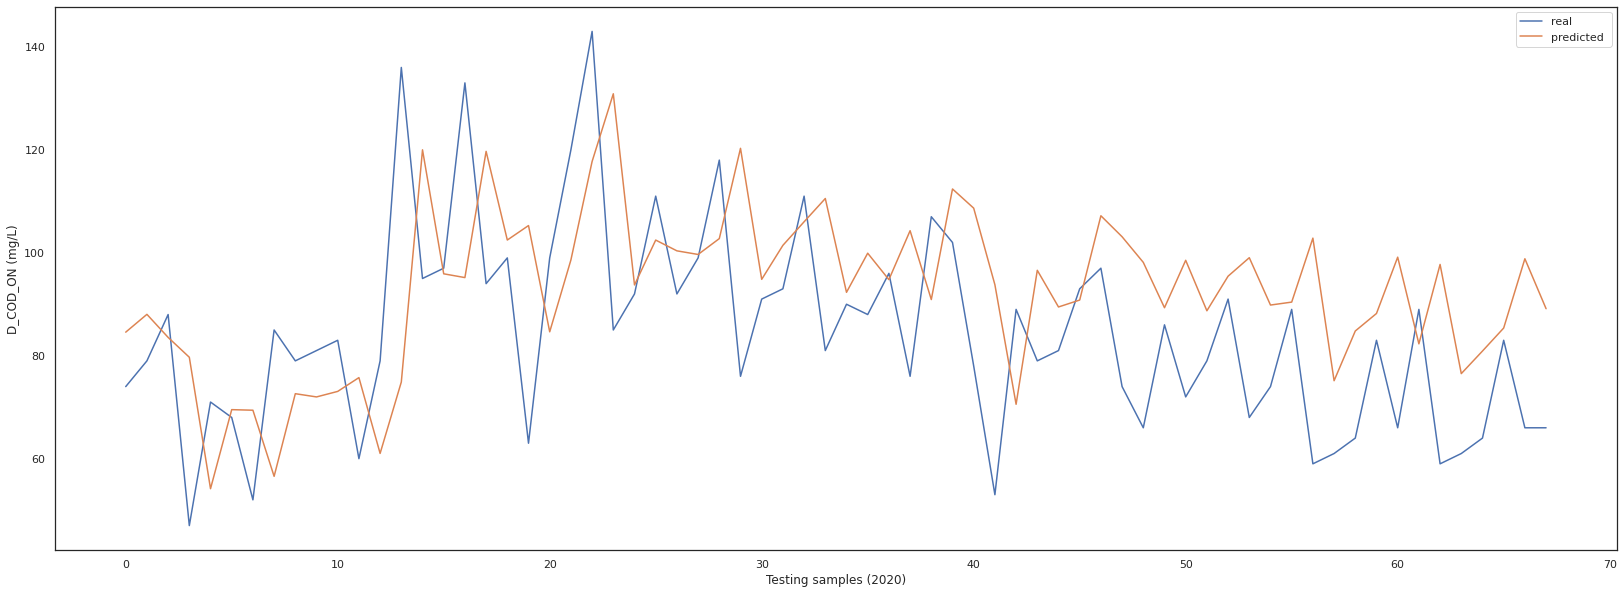

(68,)

In [ ]:
app3.testing(dataset.iloc[-cut_off:])
app3.full_prediction.shape

*** Ensemble estimation ***
MAPE:  23.327591599770283


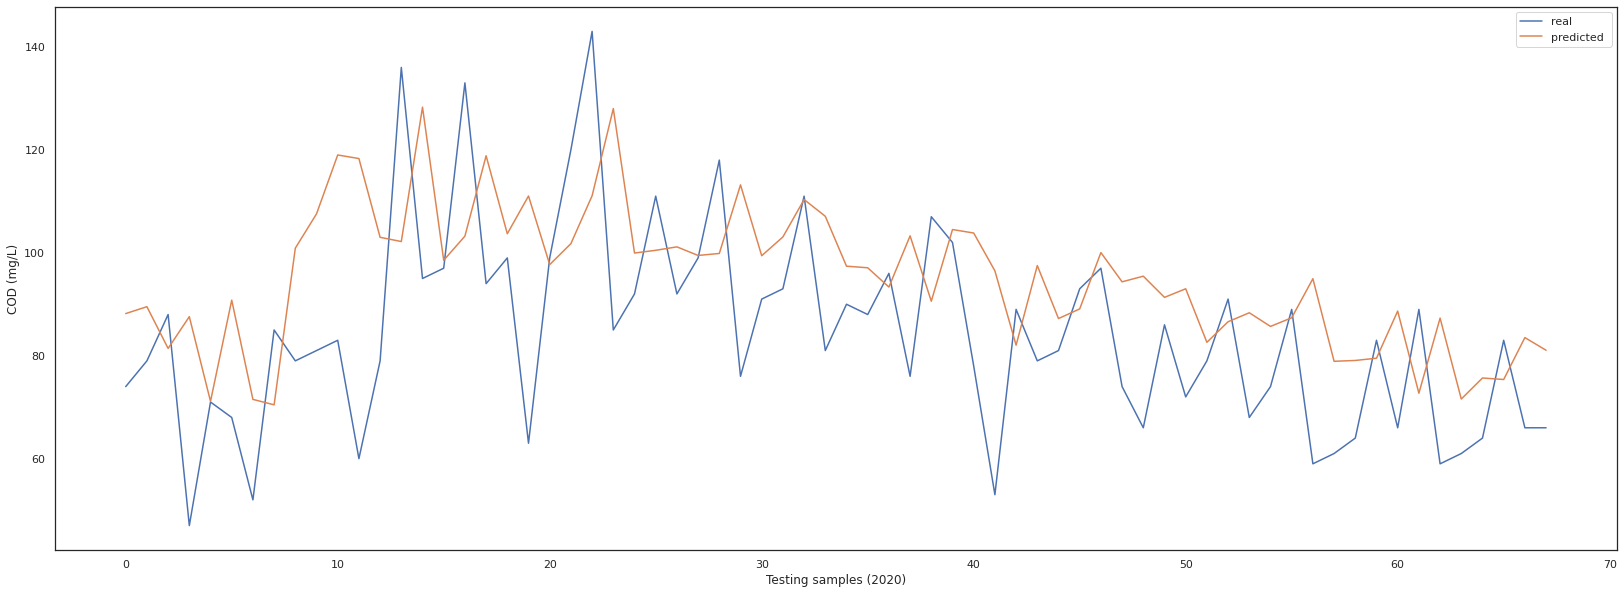

In [ ]:
ensemble = (app1.full_prediction + app2.full_prediction['Prediction'] + app3.full_prediction)/3
print('*** Ensemble estimation ***')
print ('MAPE: ',mean_absolute_percentage_error(app2.Y_test.values, ensemble.values))
#print ('R2: ',r2_score(app2.Y_test.values, ensemble.values))
# plot baseline and predictions
plt.figure(figsize=(28,10))
plt.plot(app2.Y_test.values, label = 'real ')
plt.plot(ensemble.values, label = 'predicted ')
plt.ylabel('COD (mg/L)')
plt.xlabel('Testing samples (2020)')
plt.legend()
plt.show()

*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(
[ 24.22992   28.639994  20.7766    18.167381  21.925941  61.37445
  18.337063  20.375254  60.69116   82.45286  102.121284  96.710846
  90.91763   80.644295  66.75725   27.01052   38.610558  54.8675
  40.911655  45.338127  25.022295  27.407372  36.82501   61.827408
  33.211952  36.62555   18.143446  25.90146   23.651003  50.68779
  31.105936  33.32149   35.517002  35.007748  28.205362  30.062479
  19.351221  39.361336  19.038345  36.113255  25.01646   33.10636
  17.757542  22.916435  19.038464  18.048662  35.912876  20.302673
  38.23842   33.945538  23.166643  19.291878  18.096172  18.093893
  20.80091   19.58853   27.055058  17.740606  18.330217  18.847382
  21.74662   27.285433  17.758188  25.414837  18.218536  21.005072
  17.862112  18.21426 ], shape=(68,), dtype=float32)
MAPEsci:  2278.126138799331
MAPE:  33.53011107555092
R2:  -1.4143238667145925
RMSE:  30.078309318489975


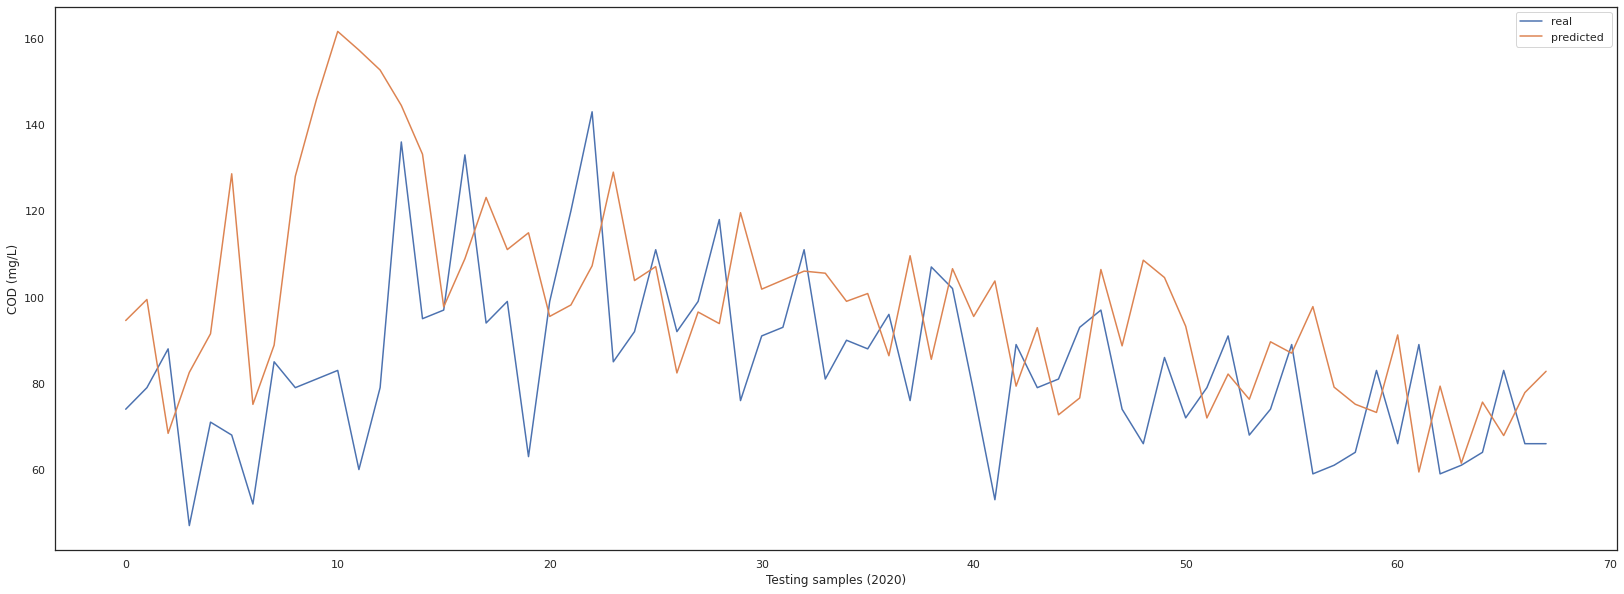

In [ ]:
ensemble_model.testing(dataset.iloc[-142:], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(
[27.14639  31.326256 18.383179 20.046389 19.106625 48.261955 17.964642
 18.972132 50.200195 55.700283 57.375942 57.070465 57.537704 56.308865
 54.017193 32.19675  41.547096 61.1441   45.25258  47.470856 24.841763
 32.288475 48.666264 68.58876  36.05561  42.265697 26.041254 29.970047
 29.074509 54.220993 33.741154 37.46747  35.40662  42.0456   31.883059
 34.93547  21.496387 45.109413 20.310097 39.251453 30.835072 35.666782
 17.878344 26.149494 17.861464 17.947065 36.581406 23.426207 40.212925
 34.1154   25.460238 18.356691 18.564281 18.432682 22.978233 21.40232
 27.618826 18.16714  17.927841 18.551313 20.807678 23.592716 18.331644
 23.280378 17.732166 20.542614 17.798878 18.710983], shape=(68,), dtype=float32)
MAPE:  32.34735995875727
R2:  -0.8324797300863818
RMSE:  26.204461964520743


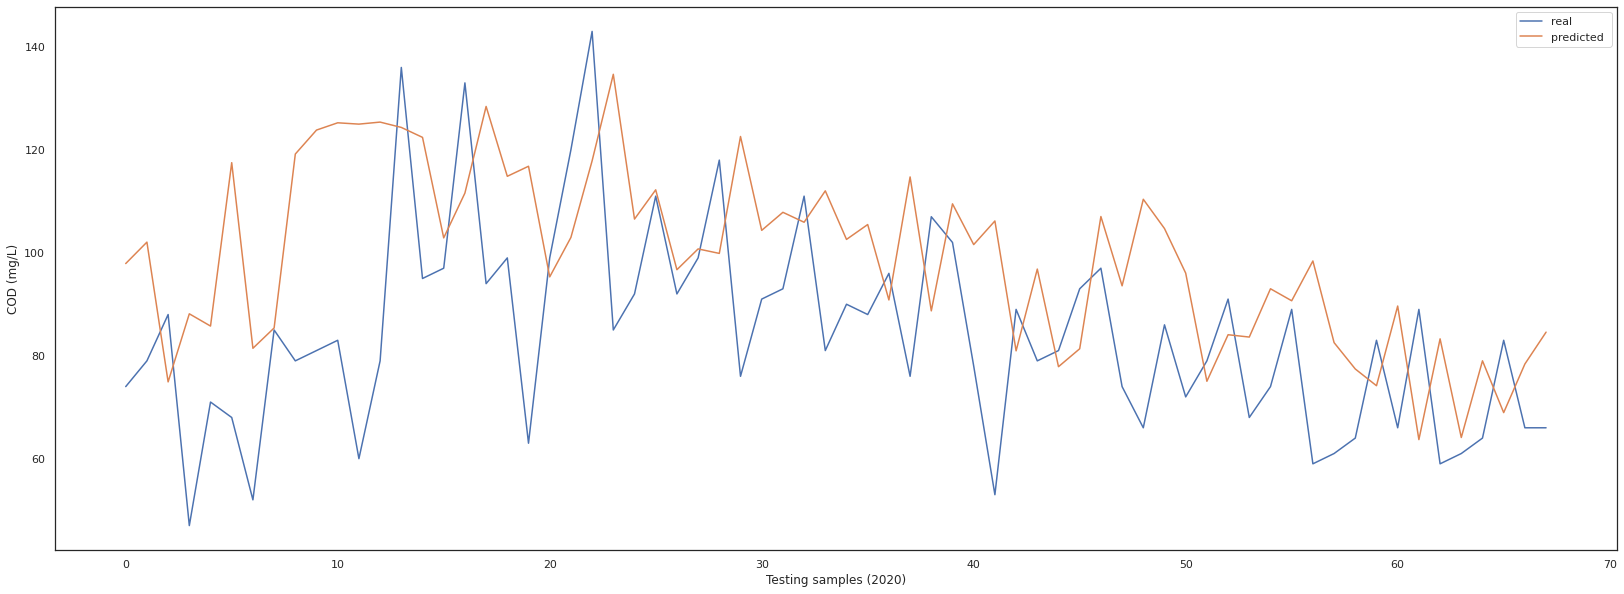

In [ ]:
ensemble_model2.testing(dataset.iloc[-142:], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

3/3 [==============================] - 0s 3ms/step - loss: 1.1478 - accuracy: 0.3529
*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(32.022125553556094, shape=(), dtype=float64)
MAPEsci:  2398.091122097871
MAPE:  32.02212555355608
R2:  -2.184175487875786
RMSE:  34.542530902500694


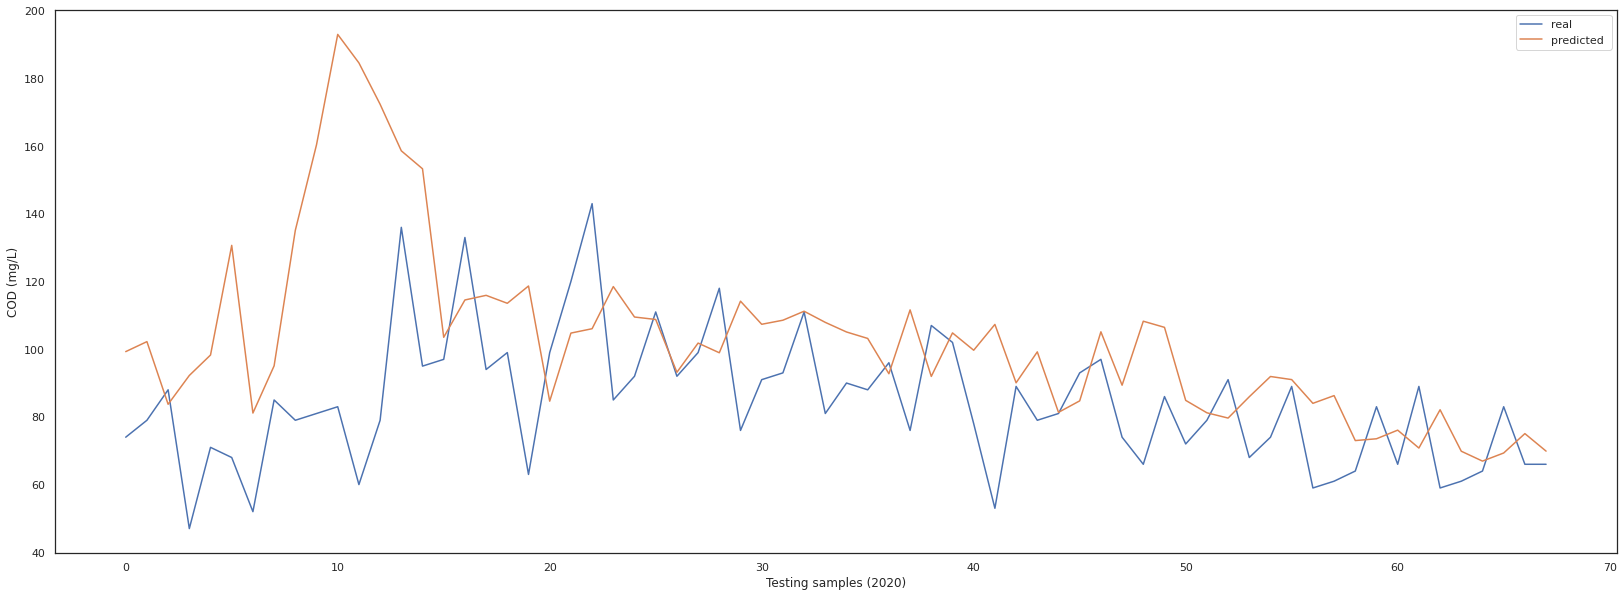

In [ ]:
ensemble_model3.testing(dataset.iloc[-142:], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

In [ ]:
ensemble_model3.selection.to_list().count(3)

0